In [1250]:
'''
TODO

- nel calcolo del diametro karst per le trincee considerare la distanza tra m_s-l_m e bedrock (h_quat+h_perm-h_rilevato)
- introdurre una distribuzione exponenziale troncata
- nel calcolo a ritroso dividere le subsidenze dagli inbuti
- la def funziona per gli inbuti, fare una nuova def per le subsidenze
- capire come gestire quegli inbuti che dal calcolo a ritroso non hanno soluzione (ex coperture alte)
- cambiare nome h_rilevato con h_livelletta
- in df0 dbase (contatto roccia) dave (superficie)
- in df_zo dbase(superficie) dave(contatto roccia)
- estrarre il num_karst medio in profondità (ad esempio per i viadotti e per stimare i riempimenti con il grout)

'''

'\nTODO\n\n- nel calcolo del diametro karst per le trincee considerare la distanza tra m_s-l_m e bedrock (h_quat+h_perm-h_rilevato)\n- introdurre una distribuzione exponenziale troncata\n- nel calcolo a ritroso dividere le subsidenze dagli inbuti\n- la def funziona per gli inbuti, fare una nuova def per le subsidenze\n- capire come gestire quegli inbuti che dal calcolo a ritroso non hanno soluzione (ex coperture alte)\n- cambiare nome h_rilevato con h_livelletta\n- in df0 dbase (contatto roccia) dave (superficie)\n- in df_zo dbase(superficie) dave(contatto roccia)\n- estrarre il num_karst medio in profondità (ad esempio per i viadotti e per stimare i riempimenti con il grout)\n\n'

In [1251]:
#!/usr/bin/env conda run -n newenv3 python
import sys
print(sys.executable)    ### C:\ProgramData\Anaconda3_1\envs\newenv3\python.exe
#!{sys.executable} -m pip install tables              ##  df.to_hdf

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
!jupyter kernelspec list
# pip install xlrd
# python -m pip install --user numpy scipy matplotlib ipython jupyter pandas sympy nose

C:\ProgramData\Anaconda3_1\envs\newenv3\python.exe


Available kernels:
  python3    C:\ProgramData\Anaconda3_1\envs\newenv3\share\jupyter\kernels\python3


## Note

- Non può prevedere le caverne e gli eventi con probabilità bassa
- L'assunzione principale si basa sul fatto che:
        - i diametri di karst piccoli hanno una probabilità alta
        - i diametri di karst grandi hanno una prob. bassa
        - da qui l'assunzione di utilizzare una prob exp troncata ad un valore massimo

In [1252]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from descartes import PolygonPatch
import math
from ipyleaflet import Map, GeoJSON
import geojson
import numpy as np
#from mpl_toolkits.basemap import Basemap
from ipyleaflet import Map
import mpld3
from dbfread import DBF
mpld3.enable_notebook()
#to import the basemap library give the direct path to the library
# import os
# os.environ["PROJ_LIB"]="C:\\Users\\Anaconda3\\Library\\share"
import pandas as pd
from simpledbf import Dbf5
import math
from Finddistribution import *
import numpy as np

from scipy.stats import expon
import matplotlib.pyplot as plt

import os
import types

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon


import plotly.graph_objects as go
from scipy.interpolate import griddata
from pyproj import Proj
import plotly.express as px

import random
from tqdm import tqdm

import sys
from tqdm import trange
import seaborn as sns

from IPython.display import display
pd.options.display.max_columns = None

from scipy.stats import gaussian_kde

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import truncexpon

#### Variabili globali

In [1253]:
# limite di altezza per distinguere tra viadotti alti e bridge bassi
lim_via_bridge = 12.5

vitautile = 100

# soglia_dia_karst per differenziare karst small da karst grandi
soglia_dia_karst = 3
#1000
epochs = 100
#109
pkfinale = 40
# 50 ogni km
# 5 ogni 100m
div_settori = 50
# km da studiare
km_analisi = 40
# correzione distr exp per aumentare stima diametri bassi
# questo perché in teoria la distribuzione è exp troncata
correzione_distr_exp = 2

### CHECK CONGRUENZA FILE INPUT

In [1254]:
df_prop = pd.read_csv('df_prop.csv', sep=';', index_col=0)
df_prop = df_prop.apply(pd.to_numeric, errors='ignore', downcast = 'float')
df_prop.set_index('IGE_princi', inplace=True)

if '3a' in df_prop.index: 
    print('OK: colonna index impostata correttamente come "IGE_princi"')
else:
    print('ERROR: colonna index potrebbe non avere gli IGE_princi')

list_ige = ['3', '3a', '12', '6', '2a-1', '5-1', '2', '9', '6a', '6-1', '13', '11',
       '4', '13-1', '17', '16', '19', '7', '18', '15a', '14', '340', '14-1',
       '14-2', '14']
err = 0
for i in list_ige:
    if i not in df_prop.index.tolist():
        print("IGE ",i,"ERROR: non è presente nella precedente lista di IGE")
        err = 1
    else:
        pass
if err==0: print("OK: Tutti i nuovi 'IGE' erano presenti nella lista precedente")




# index nome IGE il resto del dataframe è tutto numerico
df_prop_rock = pd.read_csv('df_prop_rock.csv', index_col=0)
df_prop_rock = df_prop_rock.apply(pd.to_numeric, errors='coerce', downcast = 'float')

if 'Gessi' in df_prop_rock.index: 
    print('OK: La colonna index del df_prop_rock è correttamente impostata sul tipo di roccia')
else:
    print('ERROR: La colonna index del df_prop_rock non è correttamente impostata sul tipo di roccia')


df_orig = pd.read_csv('Tabella_completa_karst2_3.csv', sep=';', index_col=0)

err = 0
for i in df_orig.IGE.tolist():
    if i not in df_prop.index.tolist():
        print('ERROR: non corrisponde l IGE: ', i)
        err += 1
for i in df_orig.IGE_sec.tolist():
    if i not in df_prop.index.tolist():
        print('ERROR: non corrisponde l IGE: ', i)
        err += 1
if err == 0 : print('OK: Tutti gli IGE nel dataframe principale sono contenuti nel dataframe prop_list')
    
if df_prop.shape[0] == len(df_prop.index.unique().tolist()):
    print('OK le IGE non sono ripetute sono univoche nel file df_prop')
else:
    print('ERROR gli IGE non sono univoci nel file df_prop')
    
    
### df0 =======================================================================================

df0 = pd.read_csv('kast-csv2.csv', sep=";")

err = 0
for i in ['long', 'lat', 'type', 'dave', 'era']:
    if i in df0.columns.tolist():
        pass
    else:
        print('ERROR The column -> ',i,' in df0 do not exists!')
        err +=1
if err==0: print('OK checked columns in df0')

if df0.type.unique().tolist() == ['Inbuto', 'Subsidenza']: 
    print('OK checked column type of df0')
else:
    print('ERROR check column type of df0')
    


OK: colonna index impostata correttamente come "IGE_princi"
OK: Tutti i nuovi 'IGE' erano presenti nella lista precedente
OK: La colonna index del df_prop_rock è correttamente impostata sul tipo di roccia
OK: Tutti gli IGE nel dataframe principale sono contenuti nel dataframe prop_list
OK le IGE non sono ripetute sono univoche nel file df_prop
OK checked columns in df0
OK checked column type of df0


### INIZIO

In [1255]:
df_orig = pd.read_csv('Tabella_completa_karst2_3.csv', sep=';', index_col=0)

In [1256]:
# controlla quali colonne sono stringhe

df_orig.select_dtypes('object').columns

Index(['Intensity', 'Int_simpl', 'Tipo', 'Tipo_plus', 'IGE_OLD', 'IGE',
       'Litho', 'IGE_sec', 'LITHO_SEC', 'sequenza'],
      dtype='object')

In [1257]:
# converti colonne che devono essere numeriche non necessario se la riga sopra fornisce un risultato corretto4

col_list = ['Road_level','m_s_l_m_','calc_top','gessi_top','marne_top','Arg_perm','Arg_giura','h_perm','h_calc','h_gessi','h_giur','h_quat','h_marne']

for col in col_list:
    df_orig[col] = round(df_orig[col].astype('float'),1)

In [1258]:
df_orig['h_livelletta'] = df_orig['Road_level'] - df_orig['m_s_l_m_']

#### Creo df_orig

In [1259]:
df_orig.columns

Index(['pk', 'zone', 'Intensity', 'STB_100Yr', 'Int_simpl', 'm_s_l_m_', 'Tipo',
       'Tipo_plus', 'progressiva', 'dist_sez', 'calc_top', 'gessi_top',
       'Arg_perm', 'Arg_giura', 'marne_top', 'Road_level', 'IGE_OLD', 'IGE',
       'Litho', 'IGE_sec', 'IGE_SEC_PERC', 'LITHO_SEC', 'POINT_X', 'POINT_Y',
       'sequenza', 'h_quat', 'h_marne', 'h_giur', 'h_perm', 'h_calc',
       'h_gessi', 'h_rilevato', 'h_livelletta'],
      dtype='object')

In [1260]:
# df = df_orig[['IGE', 'Litho', 'IGE_sec', 'IGE_SEC_PERC', 'LITHO_SEC', 'POINT_X', 'POINT_Y','h_quat','Tipo','Tipo_plus','h_rilevato']].copy()
df = df_orig.copy()

In [1261]:
# # se non trova la colonna Tipo_plus usare questo script
# df_temp_tipo = pd.read_csv('df_tipo_plus.csv', index_col=0)
# df['Tipo_plus'] = df_temp_tipo['Tipo_plus']

In [1262]:
df['h_perm'] = df_orig['h_perm'] + df_orig['h_giur'] + df_orig['h_marne']

In [1263]:
def f(row):
    if row['gessi_top'] > row['calc_top']:
        val = 'g'
    else:
        val = 'c'
    return val

df['bedrock'] = df_orig.apply(f, axis=1)

#### Correggo gli spessori negativi per errore precisione Leader / profilo GEO

In [1264]:
df.loc[df['h_quat']<0,['h_quat']] = 0
df.loc[df['h_perm']<0,['h_perm']] = 0

#### Creo Dataframe con le proprietà meccaniche  "df_prop" "df_prop_rock"

In [1265]:
df_prop = pd.read_csv('df_prop.csv', sep=';', index_col=0)

In [1266]:
#### Creo un dataframe con le proprietà meccaniche

# index nome IGE il resto del dataframe è tutto numerico
df_prop = pd.read_csv('df_prop.csv', sep=';', index_col=0)
df_prop = df_prop.apply(pd.to_numeric, errors='ignore', downcast = 'float')
df_prop.set_index('IGE_princi', inplace=True)


# index nome IGE il resto del dataframe è tutto numerico
df_prop_rock = pd.read_csv('df_prop_rock.csv', index_col=0)
df_prop_rock = df_prop_rock.apply(pd.to_numeric, errors='coerce', downcast = 'float')

In [1267]:
col_prop_base = [i if (("MAX" not in i)&("MIN" not in i)&("stdev" not in i)) else "" for i in df_prop.columns.to_list()]
col_prop_base = list(filter(None, col_prop_base))

In [1268]:
# litotipi associabili al permiano
df_prop.loc[['14','16','17'],col_prop_base]

lithotipo      gamma      e   e,cr    IP    IL    Sr     E    nu  \
IGE_princi                                                                    
14                 a  19.010000  0.806  1.008  0.21  0.10  0.91  28.6  0.35   
16                 a  19.209999  0.774  0.968  0.22  0.10  0.92  20.0  0.35   
17                 a  18.129999  0.991  1.239  0.21  0.16  0.93  24.0  0.35   

             phi      c   Dfis  
IGE_princi                      
14          21.0   82.0  0.029  
16          20.0  103.0  0.029  
17          17.0   42.0  0.025

In [1269]:
# alcune colonne importanti continuano ad essere stringe per la presenza di cambi N/A di excel

In [1270]:
df_prop.select_dtypes('object').columns

Index(['lithotipo'], dtype='object')

In [1271]:
df_prop_rock.select_dtypes('object').columns

Index([], dtype='object')

### Creo colonna progressive e gestisco punti tracciato

In [1272]:
df['POINT_X_Diff'] = df.POINT_X.diff().replace(np.nan, 0)
df['POINT_Y_Diff'] = df.POINT_Y.diff().replace(np.nan, 0)
df['length'] = np.sqrt(df.POINT_X_Diff**2 + df.POINT_Y_Diff**2).round().astype('int')
df['progressiva'] = df.length.cumsum().round().astype('int')

# correggo la prima lunghezza posso farlo dopo aver creato la colonna 'progressiva'
df.loc[0, 'length'] = 20

# verifico le colonne stringhe
df.select_dtypes('object').columns

Index(['Intensity', 'Int_simpl', 'Tipo', 'Tipo_plus', 'IGE_OLD', 'IGE',
       'Litho', 'IGE_sec', 'LITHO_SEC', 'sequenza', 'bedrock'],
      dtype='object')

# calcololo offset del tracciato

### creo colonna con differenza ogni 2 punti

In [1273]:
df['diff_X_roll2'] = df.POINT_X.diff(periods=2).shift(-1).fillna(method = 'bfill').fillna(method = 'ffill')
df['diff_Y_roll2'] = df.POINT_Y.diff(periods=2).shift(-1).fillna(method = 'bfill').fillna(method = 'ffill')

In [1274]:
df1 = df[[
 'POINT_X',
 'POINT_Y',
 'diff_X_roll2',
 'diff_Y_roll2']]

In [1275]:
df1.columns

Index(['POINT_X', 'POINT_Y', 'diff_X_roll2', 'diff_Y_roll2'], dtype='object')

In [1276]:
def perpendicular(a) :
    b = np.empty_like(a)
    b[0] = a[1]
    b[1] = -a[0]
    return b

def calcangle_2v(x):
    v2 = np.array([0, 1])
    v1 = x/np.linalg.norm(x)
    dot_prod = np.dot(v1, v2)
    return math.degrees(np.arccos(dot_prod))


def offset(cx, cy, vx, vy, offset):

    vdiff = np.array([vx, vy]).T
    
    # normalize the vector difference
    # vdiffnorm = vdiff/(np.linalg.norm(vdiff))
    # for row wise normalization need to set axis = 1 then to avoid errors on shape just use np.newaxis
    vdiffnorm = vdiff/(np.linalg.norm(vdiff, axis=1))[:, np.newaxis]
    # calculate its normalized perpendicular vector
    
    vnorm = np.apply_along_axis(perpendicular, 1, vdiffnorm)
    angle = np.apply_along_axis(calcangle_2v, 1, vnorm)
    voff = vnorm * offset
    
    vtrack = np.array([cx,cy]).T
    vtrackup = vtrack + voff
    vtrackdown = vtrack - voff
    
    #breakpoint()
    
    return vtrackup, vtrackdown, angle
    

In [1277]:
vtrackup, vtrackdown, angle = offset(df.POINT_X, df.POINT_Y, df1.diff_X_roll2, df1.diff_Y_roll2, 100 )
vtrackup500, vtrackdown500, angle500 = offset(df.POINT_X, df.POINT_Y, df1.diff_X_roll2, df1.diff_Y_roll2, 500 )
vtrackup2000, vtrackdown2000, angle2000 = offset(df.POINT_X, df.POINT_Y, df1.diff_X_roll2, df1.diff_Y_roll2, 2500 )

#### Creo colonne trackup , trackdown, 2000 500 100 nel df    (2000 è 2500m above below tracciato)

In [1278]:
columns_ = ['vtrackupx','vtrackdownx','vtrackup500x','vtrackdown500x','vtrackup2000x','vtrackdown2000x']
values_ = [vtrackup[:,0],vtrackdown[:,0],vtrackup500[:,0],vtrackdown500[:,0],vtrackup2000[:,0],vtrackdown2000[:,0]]
for e,i in enumerate(columns_):
    df[i] = values_[e]
columns_ = ['vtrackupy','vtrackdowny','vtrackup500y','vtrackdown500y','vtrackup2000y','vtrackdown2000y']
values_ = [vtrackup[:,1],vtrackdown[:,1],vtrackup500[:,1],vtrackdown500[:,1],vtrackup2000[:,1],vtrackdown2000[:,1]] 
for e,i in enumerate(columns_):
    df[i] = values_[e]

##### Creo le colonne utili per il calcolo delle contromisure

In [1283]:
# One hot encoding for Tipe (rilevato, trincea, viadotto)
df = pd.concat((df, pd.get_dummies(df['Tipo'])), axis=1)
df = df.loc[:,~df.columns.duplicated()]

In [1286]:
df['h_rilevato_true'] = np.where((df.Tipo == 'Rilevato'), df['h_rilevato'],np.nan)
df['h_trincea'] = np.where((df.Tipo == 'Trincea'), df['h_rilevato'],np.nan)
df['h_viadotto'] = np.where(((df.Tipo != 'Trincea')&(df.Tipo != 'Rilevato')), df['h_rilevato'],np.nan)
df['h_copertura'] = df.h_quat + df.h_perm
df['h_copertura_ril'] = np.where((df.Tipo == 'Rilevato'), df['h_copertura'],np.nan)
df['h_copertura_tri'] = np.where((df.Tipo == 'Trincea'), (df['h_copertura']+df['h_rilevato']),np.nan)
df['h_copertura_via'] = np.where(((df.Tipo != 'Trincea')&(df.Tipo != 'Rilevato')), df['h_copertura'],np.nan)

df['Viaduct'] = np.where(df['h_viadotto'] >= lim_via_bridge, df["Ponte/viadotto new"], np.nan)
df['Bridge'] = np.where(df['h_viadotto'] < lim_via_bridge, df["Ponte/viadotto new"], np.nan)  
df['LRilevato'] = df['Rilevato']*df['length']
df['LTrincea'] = df['Trincea']*df['length']
df['LViaduct'] = df['Viaduct']*df['length']
df['LBridge'] = df['Bridge']*df['length']

In [1288]:
df[(df.progressiva>=21000)&(df.progressiva<22000)]['h_copertura_tri'].mean()

23.497857142857146

#### Pulisco colonne inutili

In [478]:
df.drop(columns=['POINT_X_Diff','POINT_Y_Diff','diff_X_roll2','diff_Y_roll2'], inplace=True, errors='ignore')

### Carico il file con i Karst

In [506]:
# df0 = pd.read_csv('karst.csv')
df0 = pd.read_csv('kast-csv2.csv', sep=";")
# df0.to_csv('kast-csv2.csv', sep=";")
df0.select_dtypes('object').columns

Index(['type', 'type2', 'type3', 'era', 'fonte'], dtype='object')

In [508]:
df0.head(2)

Unnamed: 0  ref  n_occ          long           lat    type    type2  \
0           0    1     11  430000.85568  6.150061e+06  Inbuto  Ellisse   
1           1    2     12  430196.96080  6.150400e+06  Inbuto  Ellisse   

      type3  dmax  dmin  dave    h  h/d   area  volume     era  \
0  Piattino  23.1  11.7  17.4  0.0  0.0  212.2     0.0  Antica   
1     Tazza  16.1  10.2  13.2  0.0  0.0  128.9     0.0  Antica   

               fonte  
0  Immagini spaziali  
1  Immagini spaziali

### CREO df_g50 --> df (ogni 20m) condensato ogni 1km

In [1292]:
# perché la media sia efficace bisogna convertire lo zero con np.nan dove ci sono delle colonne parziali
# Attenzione quando condensi anche sul h_perm

df['h_rilevato_true'] = df['h_rilevato_true'].replace(0, np.NaN)
df['h_trincea'] = df['h_trincea'].replace(0, np.NaN)
df['h_viadotto'] = df['h_viadotto'].replace(0, np.NaN)
df['h_copertura_ril'] = df['h_copertura_ril'].replace(0, np.NaN)
df['h_copertura_tri'] = df['h_copertura_tri'].replace(0, np.NaN)
df['h_copertura_via'] = df['h_copertura_via'].replace(0, np.NaN)

df_g50 = df.groupby(df.index // div_settori).agg({'progressiva':'first', 'POINT_X':'first', 'POINT_Y':'first', 'IGE':max, 'Litho':max, 'h_quat':'mean', 'h_perm':'mean',
                                         'vtrackupx':'first', 'vtrackupy':'first', 'vtrackdownx':'first', 'vtrackdowny':'first',
                                         'vtrackup500x':'first', 'vtrackup500y':'first', 'vtrackdown500x':'first', 'vtrackdown500y':'first',
                                         'vtrackup2000x':'first', 'vtrackup2000y':'first', 'vtrackdown2000x':'first', 'vtrackdown2000y':'first',
                                         'length':'sum','h_rilevato':'mean','h_rilevato_true':'mean','h_trincea':'mean','h_viadotto':'max',
                                         'LRilevato':'sum','LTrincea':'sum','LViaduct':'sum','LBridge':'sum',
                                         'h_copertura':'mean', 'h_copertura_ril':'mean', 'h_copertura_tri':'mean', 'h_copertura_via':'mean', 'Tipo_plus':'max'})
# riaggiungo l'ultima riga

df_g50 = df_g50.append(df[df_g50.columns.tolist()].tail(1), ignore_index=True, sort=False)

# ripristino gli zeri sono obbligato perché il df lo uso per le interpolazioni
df.fillna(0, inplace=True)

In [1293]:
df_g50.loc[[21]]

progressiva   POINT_X    POINT_Y IGE Litho  h_quat  h_perm      vtrackupx  \
21        21000  449809.8  6145398.6   3     a   8.606  17.798  449809.300006   

       vtrackupy    vtrackdownx   vtrackdowny   vtrackup500x  vtrackup500y  \
21  6.145299e+06  449810.299994  6.145499e+06  449807.300031  6.144899e+06   

    vtrackdown500x  vtrackdown500y  vtrackup2000x  vtrackup2000y  \
21   449812.299969    6.145899e+06  449797.300156   6.142899e+06   

    vtrackdown2000x  vtrackdown2000y  length  h_rilevato  h_rilevato_true  \
21    449822.299844     6.147899e+06    1000      1.5412         2.341389   

    h_trincea  h_viadotto  LRilevato  LTrincea  LViaduct  LBridge  \
21  -0.516429         NaN        720       280       0.0      0.0   

    h_copertura  h_copertura_ril  h_copertura_tri  h_copertura_via Tipo_plus  
21       26.404        27.333333        23.497857              NaN   Trincea

In [511]:
# df_g50 = pd.read_csv('df_g50.csv', index_col=0, sep=';')

### CONTO I KARST CHE CADONO NELL'AREA DI 1KM 
####  - aggiorno il df0 con i carst con la colonna "sector2000_50" che associa al karst un settore g50 di riferimento
####  - aggiorno il df_g50 con le colonne 'n_karst' e 'sector_area'

In [512]:
df_g50['n_karst'] = np.nan
df_g50['sector_area'] = np.nan
df0['sector2000_50'] = np.nan
df0['check_100'] = False
df0['check_500'] = False

for i in range(df_g50.shape[0]-1):
    #######        prima escludevo tutti i punti oltre la pk 60000 adesso oltre la pk 110000
    if (df_g50.progressiva[i] > 110000):
        pass
    
    else:
        polygon = Polygon([tuple(df_g50[['vtrackup2000x','vtrackup2000y']].loc[i,:]),
                          tuple(df_g50[['vtrackup2000x','vtrackup2000y']].loc[i+1,:]),
                          tuple(df_g50[['vtrackdown2000x','vtrackdown2000y']].loc[i+1,:]),
                          tuple(df_g50[['vtrackdown2000x','vtrackdown2000y']].loc[i,:])])
        polygon2 = Polygon([tuple(df_g50[['vtrackupx','vtrackupy']].loc[i,:]),
                          tuple(df_g50[['vtrackupx','vtrackupy']].loc[i+1,:]),
                          tuple(df_g50[['vtrackdownx','vtrackdowny']].loc[i+1,:]),
                          tuple(df_g50[['vtrackdownx','vtrackdowny']].loc[i,:])])
        polygon3 = Polygon([tuple(df_g50[['vtrackup500x','vtrackup500y']].loc[i,:]),
                          tuple(df_g50[['vtrackup500x','vtrackup500y']].loc[i+1,:]),
                          tuple(df_g50[['vtrackdown500x','vtrackdown500y']].loc[i+1,:]),
                          tuple(df_g50[['vtrackdown500x','vtrackdown500y']].loc[i,:])])
        n_karst = 0
        
        # ogni volta itero sul n° di karst di df0
        # TODO : per ottimizzare se finisce in un settore rimuovo la riga dal dataframe
        
        for e in range(df0.shape[0]):
            point = Point(df0.loc[df0.index[e],['long']], df0.loc[df0.index[e],['lat']])
            if polygon.contains(point):
                df0.loc[df0.index[e], 'sector2000_50'] = i
                n_karst += 1
            else:
                pass
            if polygon.contains(point): df0.loc[df0.index[e], 'check_2000'] = True
            if polygon2.contains(point): df0.loc[df0.index[e], 'check_100'] = True
            if polygon3.contains(point): df0.loc[df0.index[e], 'check_500'] = True
        
        df_g50.loc[df_g50.index[i], 'n_karst'] = n_karst
        # area in km^2
        df_g50.loc[df_g50.index[i], 'sector_area'] = polygon.area/1e6

In [513]:
df_g50['n_karst'] = df_g50['n_karst'].fillna(0)
df_g50['sector_area'] = df_g50['sector_area'].fillna(method = 'ffill')   # oltre la pk50 tutto uguale

#### Drop karst row outside 2500m boundary  (recall that sector2000 is 2500m)

In [514]:
# rimuovo i punti che finiscono fuori settore
df0.dropna(subset=['sector2000_50'], inplace=True)
df0['check_500'] = df0.check_500.fillna(False)
df0['check_100'] = df0.check_100.fillna(False)

In [515]:
df0['sector2000_50'] = df0.sector2000_50.astype('float')
df0['sector2000_50_str'] = df0.sector2000_50.astype('str')

In [516]:
### Creo colonna con gli indici dei karst  "sector2000_50" inizialmente è nell'indice ma la sposto in una colonna

df_g50.reset_index(inplace = True)
df_g50.rename(columns={'index':'sector2000_50'}, inplace = True)

In [517]:
df_g50.to_csv('df_g50.csv', sep=";")

### CREO LA FUNZIONE PER CALCOLARE DIA KARST

#### Creo le funzioni di interpolazione per associare ad ogni karst di df0 delle proprieta: progressiva, h_rilevato, Tipo, IGE, h_perm ect

In [518]:
df_pred = df[['POINT_X','POINT_Y','h_perm','h_quat','IGE', 'IGE_sec', 'IGE_SEC_PERC','Tipo', 'Tipo_plus', 'h_rilevato_true', 'h_trincea', 
              'h_viadotto', 'h_copertura_tri', 'h_copertura_ril', 'h_copertura', 'h_copertura_via', 'h_rilevato', 'progressiva']].append(
    df[['vtrackup2000x','vtrackup2000y','h_perm','h_quat','IGE', 'IGE_sec', 'IGE_SEC_PERC','Tipo', 'Tipo_plus', 'h_rilevato_true', 'h_trincea', 
        'h_viadotto', 'h_copertura_tri', 'h_copertura_ril', 'h_copertura', 'h_copertura_via', 'h_rilevato', 'progressiva']].rename(columns={'vtrackup2000x':'POINT_X','vtrackup2000y':'POINT_Y'}), 
    ignore_index=True).append(
    df[['vtrackdown2000x','vtrackdown2000y','h_perm','h_quat','IGE', 'IGE_sec', 'IGE_SEC_PERC','Tipo', 'Tipo_plus', 'h_rilevato_true', 'h_trincea', 
        'h_viadotto', 'h_copertura_tri', 'h_copertura_ril', 'h_copertura', 'h_copertura_via', 'h_rilevato', 'progressiva']].rename(columns={'vtrackdown2000x':'POINT_X','vtrackdown2000y':'POINT_Y'}), 
    ignore_index=True)

In [519]:
def predict(points,values,points_pred):
    '''
    input
     points = numpy.array(i,2)
     values = numpy array(i,)
     points_pred = numpy.array(i,2)
    output
     predicted_values 
    '''
    points = np.array(points)
    values = np.array(values)
    points_pred = np.array(points_pred)
    if (type(values[0].item()) == float) | (type(values[0].item()) == int):
        values_pred = griddata(points, values, points_pred, method='linear')
    else:
        values_pred = griddata(points, values, points_pred, method='nearest')
    
    return values_pred

In [520]:
df.shape, df_orig.shape, df_pred.shape

((5439, 63), (5439, 33), (16317, 18))

In [1371]:
df_pred.head(3)

POINT_X    POINT_Y  h_perm  h_quat IGE IGE_sec  IGE_SEC_PERC      Tipo  \
0  430496.2  6151614.4     0.0    27.1  3a       3          0.04  Rilevato   
1  430516.2  6151613.8     0.0    27.2  3a       3          0.04  Rilevato   
2  430536.2  6151613.3     0.0    27.3  3a       3          0.04  Rilevato   

  Tipo_plus  h_rilevato_true  h_trincea  h_viadotto  h_copertura_tri  \
0  Rilevato             4.95        0.0         0.0              0.0   
1  Rilevato             4.38        0.0         0.0              0.0   
2  Rilevato             3.91        0.0         0.0              0.0   

   h_copertura_ril  h_copertura  h_copertura_via  h_rilevato  progressiva  
0             27.1         27.1              0.0        4.95            0  
1             27.2         27.2              0.0        4.38           20  
2             27.3         27.3              0.0        3.91           40

In [522]:
points = df_pred.loc[:,['POINT_X','POINT_Y']]
values_h_perm = df_pred.loc[:,['h_perm']]
values_h_quat = df_pred.loc[:,['h_quat']]
values_ige = df_pred.loc[:,['IGE']]
values_ige_sec = df_pred.loc[:,['IGE_sec']]
values_ige_sec_perc = df_pred.loc[:,['IGE_SEC_PERC']]
values_tipo = df_pred.loc[:,['Tipo']]
values_tipo_plus = df_pred.loc[:,['Tipo_plus']]

values_h_rilevato = df_pred.loc[:,['h_rilevato']]
values_h_rilevato_true = df_pred.loc[:,['h_rilevato_true']]
values_h_trincea = df_pred.loc[:,['h_trincea']]
values_h_viadotto = df_pred.loc[:,['h_viadotto']]

values_h_copertura = df_pred.loc[:,['h_copertura']]
values_h_copertura_ril = df_pred.loc[:,['h_copertura_ril']]
values_h_copertura_tri = df_pred.loc[:,['h_copertura_tri']]
values_h_copertura_via = df_pred.loc[:,['h_copertura_via']]

values_progressiva = df_pred.loc[:,['progressiva']]

In [523]:
point_pred = df0.loc[:,['long','lat']]
df0['h_perm'] = predict(points, values_h_perm, point_pred)
df0['h_quat'] = predict(points, values_h_quat, point_pred)
df0['IGE'] = predict(points, values_ige, point_pred)
df0['IGE_sec'] = predict(points, values_ige_sec, point_pred)
df0['IGE_SEC_PERC'] = predict(points, values_ige_sec_perc, point_pred)
df0['progressiva'] = predict(points, values_progressiva, point_pred)
df0['Litho'] = df_prop.lithotipo[df0.IGE].tolist()

df0['Tipo'] = predict(points, values_tipo, point_pred)
df0['Tipo_plus'] = predict(points, values_tipo_plus, point_pred)
df0['h_copertura'] = predict(points, values_h_copertura, point_pred)
df0['h_copertura_ril'] = predict(points, values_h_copertura_ril, point_pred)
df0['h_copertura_tri'] = predict(points, values_h_copertura_tri, point_pred)
df0['h_copertura_via'] = predict(points, values_h_copertura_via, point_pred)
df0['h_rilevato'] = predict(points, values_h_rilevato, point_pred)
df0['h_rilevato_true'] = predict(points, values_h_rilevato_true, point_pred)
df0['h_trincea'] = predict(points, values_h_trincea, point_pred)
df0['h_viadotto'] = predict(points, values_h_viadotto, point_pred)

df0['vol_dave'] = 4/3*np.pi*(df0.dave/2)**3 / 2
df0.fillna(0, inplace=True)
# attribuisco ad ogni karst il lithotipo principale
d1 = dict(zip(df_prop.index, df_prop.lithotipo))
df0['Litho'] = df0.replace({'IGE':d1})['IGE']

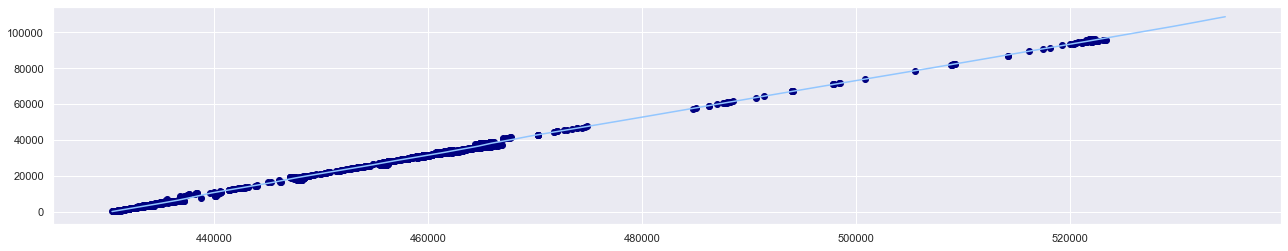

In [524]:
with plt.style.context(("seaborn-pastel",)):
    fig, ax = plt.subplots(1,1, figsize=(22,4))
    ax.plot(df.POINT_X, df.progressiva)
    ax.scatter(df0.long, df0.progressiva, c='navy')
#     plt.xlim(df.POINT_X.min(), df[df.progressiva<40000]['POINT_X'].max())

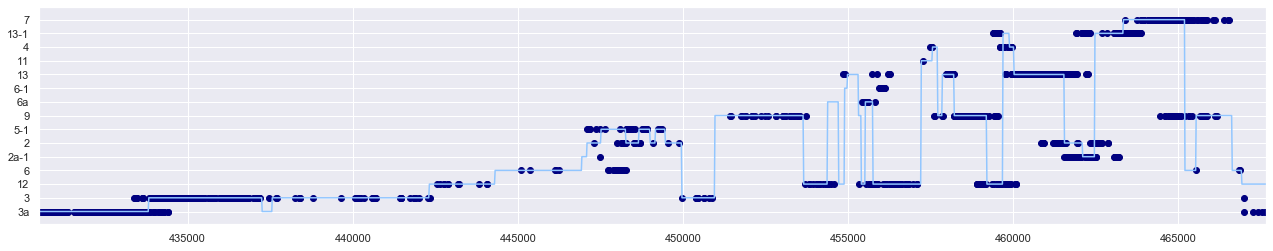

In [525]:
with plt.style.context(("seaborn-pastel",)):
    fig, ax = plt.subplots(1,1, figsize=(22,4))
    ax.plot(df.POINT_X, df.IGE)
    ax.scatter(df0.long, df0.IGE, c='navy')
    plt.xlim(df.POINT_X.min(), df[df.progressiva<40000]['POINT_X'].max())

In [526]:
###  ATTENZIONE PER AVERE UNA BUONA CORRISPONDENZA KARST VS LITOGRAFIA PLOTTARE I KARST CHE SONO PROSSIMI AL TRACCIATO!!! 
#check 100 = True troppi pochi punti
# con check 500 si ha un buon compromesso tra distorsione data dalla distanza dall'asse e il numero di karst

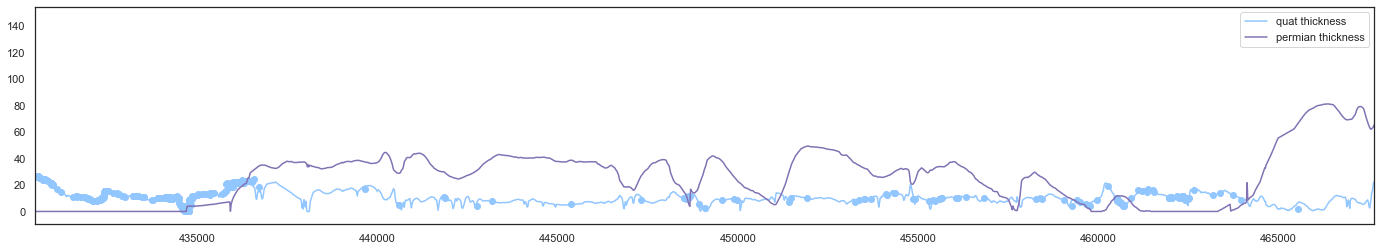

In [1374]:
#with plt.style.context(("dark_background",)):
with plt.style.context(("seaborn-pastel",)):
    
    fig, ax = plt.subplots(1,1, figsize=(24,4))
    ax.plot(df.POINT_X, df.h_quat, label='quat thickness')
    ax.plot(df.POINT_X, df.h_perm, c='m', label='permian thickness')
    
    # se uso check  100 troppi pochi karst
    #ax.scatter(df0[df0.check_100 == True].long, df0[df0.check_100 == True].h_quat)
    #ax.scatter(df0.long, df0.h_quat)
    ax.scatter(df0[df0.check_500 == True].long, df0[df0.check_500 == True].h_quat)
    
    plt.legend()

    
    plt.xlim(df.POINT_X.min(), df[df.progressiva<40000]['POINT_X'].max())
    
    plt.savefig('Karst_andprofile.png')
    

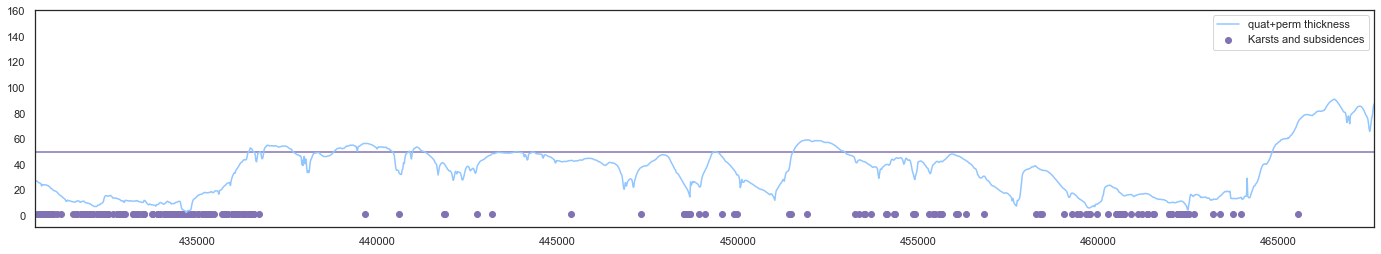

In [1378]:
with plt.style.context(("seaborn-pastel",)):
    
    fig, ax = plt.subplots(1,1, figsize=(24,4))
    ax.plot(df.POINT_X, df.h_quat+df.h_perm, label='quat+perm thickness')
    ax.hlines(50,df.POINT_X.min(), df.POINT_X.max(), colors="m")
    
    #ax.scatter(df0.long, np.ones(df0.shape[0])*50, c="m", label="Karsts and subsidences")
    ax.scatter(df0[df0.check_500 == True].long, np.ones(df0[df0.check_500 == True].shape[0]), c="m", label="Karsts and subsidences")
    
    plt.legend()

    
    plt.xlim(df.POINT_X.min(), df[df.progressiva<40000]['POINT_X'].max())
    
    plt.savefig('Karst_andprofile_50mline.png')

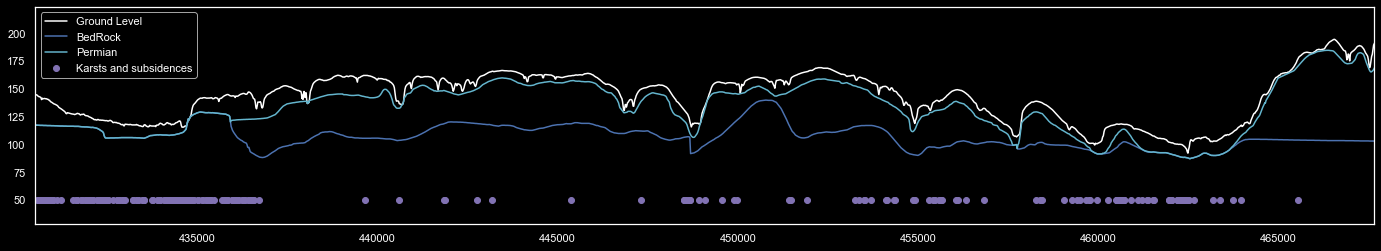

In [1376]:
with plt.style.context(("dark_background",)):
    
    fig, ax = plt.subplots(1,1, figsize=(24,4))
    ax.plot(df.POINT_X, df_orig.m_s_l_m_, c="w", label="Ground Level")
    ax.plot(df.POINT_X, df_orig.calc_top, c="b", label="BedRock")
    ax.plot(df.POINT_X, df_orig.Arg_perm, c="c", label="Permian")

    #ax.scatter(df0.long, np.ones(df0.shape[0])*50, c="m", label="Karsts and subsidences")
    ax.scatter(df0[df0.check_500 == True].long, np.ones(df0[df0.check_500 == True].shape[0])*50, c="m", label="Karsts and subsidences")
    
    
    plt.legend()

    
    plt.xlim(df.POINT_X.min(), df[df.progressiva<40000]['POINT_X'].max())
    plt.savefig('Karst_andprofile_legend.png')


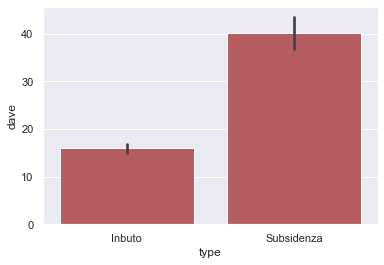

In [530]:
sns.set(style="darkgrid")
 
# plotting both distibutions on the same figure
fig = sns.barplot(df0[df0.Litho=='s'].type, df0[df0.Litho=='s'].dave, color="r")
# fig = sns.barplot(df0[df0.Litho=='a'].type, df0[df0.Litho=='a'].dave, color="b")
plt.show()

### Calcolo Karst alla base con formula inversa

#### FUNZIONE PER IL CALCOLO INVERSO

In [663]:
def calculate_dia(row, t, df_prop, df_prop_rock):
    
    # il diametro iniziale "d0" = 0.1 incrementato per step
    # when doing back calculation use t= 0
    
    lista_argille = df_prop[df_prop.lithotipo == 'a'].index.tolist()
    lista_sabbie = df_prop[df_prop.lithotipo == 's'].index.tolist()
    
    #==========================================================================================
    #                   QUI CREO LA LISTA CON GLI IGE IN QUEL KARST SPECIFICO
    #           PUO' ESSERE MESSA COME DATO DI INPUT SE INTERPOLATA ESTERNAMENTE
    #   OPPURE PUO ESSERE CREATA QUI DI SEGUITO PER INTERPOLAZIONE CON I BOREHOLES FITTIZI
    
    if row.h_perm>0:
        # TODO chiedere a Walter il permiano a che unità corrisponde
        # 14 --> J3 -->  "Clay grayish-brown, dusty, light, hard, J3
        list_layer = ['17']
        list_lathick = [row.h_perm]
    else:
        list_layer = []
        list_lathick  =[]

    if row.h_quat < 5:
        list_layer.append(row.IGE)
        list_lathick.append(row.h_quat)
    else:
        # se la litologia principale è argilla
        if df_prop.loc[row.IGE, 'lithotipo'] == 'a':
            # DO IT
            # crea una funzione che interpone un litotipo in sabbia
            # di spessore random uniform da 1/10 a 1/5 dello spessore totale dell'argilla
            list_layer.append(row.IGE)
            #list_layer.append(random.choice(lista_sabbie))
            list_layer.append(row.IGE_sec)
            list_layer.append(row.IGE)
            ige_perc = row.IGE_SEC_PERC
            randthick = random.uniform(row.h_quat*ige_perc*1.2, row.h_quat*ige_perc*0.8)
            list_lathick.append((row.h_quat - randthick)/2)
            list_lathick.append(randthick)
            list_lathick.append((row.h_quat - randthick)/2)
        else:  
            # se la litologia principale è sabbia
            # DO IT
            # crea una funzione che interpone un litotipo in argilla
            # di spessore random uniform da 1/10 a 1/5 dello spessore totale della sabbia  
            list_layer.append(row.IGE)
            list_layer.append(random.choice(lista_argille))
            list_layer.append(row.IGE)
            randthick = random.uniform(row.h_quat/10, row.h_quat/5)
            list_lathick.append((row.h_quat - randthick)/2)
            list_lathick.append(randthick)
            list_lathick.append((row.h_quat - randthick)/2)
    
    list_sv = []
    sv_temp = 0
    # invertire layer e calc sv
    for i in range(len(list_layer)):
        sv_temp += df_prop.gamma[i] * list_lathick[-1*(1+i)]
        list_sv.append(sv_temp)
    
    # come per list_layer ordino dal basso verso l'alto
    list_sv.reverse()
  
    #print(list_layer, list_lathick, df_prop.lithotipo[list_layer].tolist())
    
    # a questo punto ho la lista con litotipi e spessori
    # per le rocce usa solo calcari ma tieni in conto una futura revisione
    
    d_0 = 0.33
    d_target = row.dave
    sv = 0   # sigma inizializzata a zero
    
    # per la versione a ritroso d0 =0.1 e incrementato di 0.1 fin quando al top dello strato non si trova
    # lo stesso valore di dave

    
    #=================================================   inizio calcdia_strato   =================================================
    
    def calcdia_strato(df_prop, d_pod, layer_i, thick_i, sv, sv_i):
        # creare una funzione che restituisce il diametro strato superiore        
        # return i parametri che si aggiornano: d_top e sv 
        
        primoloop = True if sv == 0 else False
        
        radphi = np.radians(df_prop.phi[layer_i])
        _gamma = df_prop.gamma[layer_i]
        
        z1 = d_pod/2 * (1+2*np.sin(radphi))/(2*np.tan(radphi)*np.sin(radphi))
        
        x_2 = d_pod/2 * (1 + np.sin(radphi))**2/(4*np.sin(radphi)**3)
        X_2 = x_2 * 2
        
        z2 = z1 + d_pod/2*(1+np.sin(radphi))/(4*np.tan(radphi)*np.sin(radphi)**2)

        z3 = z2 + x_2/(np.tan(radphi))

        
        
        zone = 1 if(thick_i < z2) else (2 if thick_i < z3 else 3)   
        
        
        #sv = sv + df_prop.gamma[layer_i] * thick_i
        sv = 1 # per indicare loop successivi al primo
            
        eta = 0
       
        if df_prop.lithotipo[layer_i] == 'a':
            
            '''
            ********* ARGILLE  *******
            '''
                  
            _IL = float(df_prop.IL[layer_i])
            _c = df_prop.c[layer_i]
            if _c == 0: _c = 1
            _dfis = df_prop.Dfis[layer_i]
            

            dcrit = 2 * thick_i * ((np.tan(np.pi/4-radphi/2))**2 * np.tan(radphi) + 2 *_c * (1 - _IL)/sv_i)
            if dcrit < 0.01: dcrit = 0.01
            dpipe = np.exp(_IL) * _dfis * _gamma * thick_i / _c
            
            # parametro per il calcolo Pds
            eta = thick_i * dpipe / dcrit
            
            ## primo loop
            
            d_top = d_pod
            
            if (not primoloop) and (d_pod > dpipe): 
                if d_pod > dcrit:
                    d_top = dcrit
                else:
                    d_top = dpipe
            else:
                #d_top = d_pod   ********** ATTENZIONE ************
                d_top = d_pod
                pass
        
        else:
            '''
            *********  SABBIE   *******
            '''
            
            if zone == 1 :
                d_top = (X_2 - d_pod) / z2 * thick_i + d_pod
                #print('zone1 :',zone,'z2',z2,'z3',z3,'dpod: ',d_pod, 'phi: ', df_prop.phi[layer_i], 'radphi: ', radphi, 'gamma: ', _gamma)
            elif zone == 2 :
                d_top = X_2
                #print('zone2 :',zone,'z2',z2,'z3',z3,'dpod: ',d_pod, 'phi: ', df_prop.phi[layer_i], 'radphi: ', radphi, 'gamma: ', _gamma)
            else :
                #d_top = 0    ********** ATTENZIONE ************
                d_top = X_2
                #print('zone3 :',zone,'z2',z2,'z3',z3,'dpod: ',d_pod, 'phi: ', df_prop.phi[layer_i], 'radphi: ', radphi, 'gamma: ', _gamma)
        
        vol = np.pi * thick_i / 3 * (d_pod**2 / 4 + d_pod * d_top / 4 + d_top**2 / 4)
        
        if zone == 3: vol = vol + np.pi * d_pod**2 * (thick_i - z3) / 4
            
        e_i = float(df_prop.e[layer_i])
        ecr_i = float(df_prop["e,cr"][layer_i])
            
        deltav = (ecr_i - e_i) /(1 + ecr_i) * vol
        
        return d_top, sv, vol, eta
    
    #===========================================  end calcdia_strato      ============================================================  
    
    
    
    
    
    
    
    #================================================================================================================================        
        
    def calc_fixed_par(t, df_prop_rock, d_0, list_layer):
        
        # when doing back calculation use t=0
        
        v_r = df_prop_rock.v_r.Calcari
        h_p = d_0/2.5  # da controllare
        D1 = v_r * t + d_0
        m_k = df_prop_rock.m_k.Calcari
        k_k = df_prop_rock.k_k.Calcari
        phiradmedio = df_prop.phi[list_layer].mean()

        return(v_r, h_p, D1, m_k, k_k, phiradmedio)
    
    #===========================================   end  calc_fixed_par       =======================================================  
    
    
    v_r, h_p, d_0, m_k, k_k, phiradmedio  = calc_fixed_par(t, df_prop_rock, d_0, list_layer)  
    
    
    
    
    
    
    
    
    
    
    #===========================================   inizio ciclo iterativo       =======================================================
    step = 1
    report = 'other'
    
    while True:
        
        # inizializzo a d_0 finito il ciclo sarà quello in superficie
        d_top = d_0
           
        list_dia = [d_0] # il primo della lista è il d_pod
        list_vol = []
        list_eta = []
        
        for i, e in enumerate(list_layer):
            
            # calcola per tutti i layer quando esce dal loop d_0 = diam al piano campagna
            layer_i = e
            thick_i = list_lathick[i]
            sv_i = list_sv[i]
            
            d_top, sv, vol, eta = calcdia_strato(df_prop, d_top, layer_i, thick_i, sv, sv_i)
            
            list_dia.append(d_top)
            list_vol.append(vol)
            list_eta.append(eta)
            
        # calc subsidence
        
        dpod1 = list_dia[-2] # devo prendere la penultima perché l'ultima è in superficie
        sv1 = list_sv[-1]    # sv' al primo strato in alto (ultimo nella lista)
        lay1 = list_layer[-1] # layer del primo strato ovvero l'IGE principale
        th1  = list_lathick[-1] # thickness del primo strato superficiale (ultimo nella lista)
        
        d_sub = 2 * np.sqrt(th1**2 - (dpod1/2)**2)
        
        # per spessori piccoli th1 < raggio-pod quindi non c'è soluzione imporre un diametro minimo d_0 = 0.33
        # aumentando il dpod ad un certo punto ottengo Dpod/2 > th1 --> Nan
        # impondo il break
        # per entrare nel break impongo
        
        if (th1**2 - (dpod1/2)**2)<0: d_sub = d_target
        
            
        
        h_sub = sv1 * dpod1**3 * th1 * (1-df_prop.nu[lay1]**2) * (1+((df_prop.nu[lay1])/(1-df_prop.nu[lay1]))
                                                                 ) / (df_prop.E[lay1] * 1000 * ((4 * dpod1**2) - th1**2))
        # per evitare soluzioni negative
        if ((4 * dpod1**2) - th1**2) <= 0: h_sub = 100
               
        # d_0 è il d alla base stimato
        # d_top è quello calcolato a piano campagna (che appena supera il d_target stoppa i calcoli)
        
        #if (d_top < d_target) & (d_0 < d_target) & (row.type == 'Inbuto'):
        if (d_top < d_target) & (d_0 < d_target):
            step += 1
            d_0 += 0.33
            
            # ricomincia il loop da while con il valore d_0 incrementato
            if step >= 100: 
                d_0 = d_target
                #print('Risultato finale max iteration: ', d_0, d_top, list_dia)
                report = ('100_iter')
                break
            else:
                pass
        
        #elif (d_sub < d_target) & (d_0 < d_target) & (row.type != 'Inbuto'):
        elif (d_sub < d_target) & (d_0 < d_target):
            step += 1
            d_0 += 0.33
            
            # ricomincia il loop da while con il valore d_0 incrementato
            if step >= 100: 
                d_0 = d_target
                #print('Risultato finale max iteration: ', d_0, d_top, list_dia)
                report = ('100_iter')
                break
            else:
                pass
                
        else:
            # esci dal loop il primo valore d_0 che porta d_top > d_target è quello finale
            #print('Risultato finale : ', d_0, d_top, list_dia)
            report = ('sltn_found')
            break
    
    
    #===========================================   fine ciclo iterativo       =======================================================
    
    
    
    
    
    
    
    
    #===========================================    inizio calcprob         =========================================================    
    
    def calc_prob(df_prop, df_prop_rock, list_layer, d_top, v_r, h_p, D1, m_k, k_k, phiradmedio, t, list_vol, list_eta):

        # H_k = non richiesta
        
        Va_0 = np.pi * D1**2 * h_p/4
        
        Va_1 = np.pi * m_k * (k_k + v_r * t / m_k) * (3*D1**2 + ( 2 * m_k * (3*D1 + \
                2 * m_k / np.tan(phiradmedio)) / (np.tan(phiradmedio))))/12

        Va = Va_0 + Va_1
        
        list_Va0i = list_vol + Va_0
        
        sum_Va0i = np.array(list_Va0i).sum()
        sum_eta = np.array(list_eta).sum()
        sum_m = np.array(list_lathick).sum()

        Pds = 1 - np.exp(-Va / sum_Va0i * sum_eta / sum_m)

        return Pds
    
    #===========================================     fine  calcprob         ========================================================= 

    
    
    
    

    # Nel calcolo non a ritroso se Pds < 0.3 --> d_0 = 0
    
    #Pds = calc_prob(df_prop, df_prop_rock, list_layer, d_target, v_r, h_p, d_0, m_k, k_k, phiradmedio, t, list_vol, list_eta)
    
    if (row.h_perm == 0) & (row.h_quat <1) : d_0 = d_target
    
    #print("\n", "===========================================================================================================", "\n")
    
    return pd.Series([d_0, d_sub, h_sub, step, report])



In [664]:
# nel df0 dbase è diametro al contatto con la roccia mentre nel df_zo è il diametro in superficie!

df0[['dbase', 'd_sub', 'h_sub', 'step', 'report']] = df0.apply(calculate_dia, axis=1, args=(0, df_prop, df_prop_rock))

In [1314]:
df0['vol_dbase'] = 4/3*np.pi*(df0.dbase/2)**3 / 2

## DA QUI INIZIANO LE 1000 SIMULAZIONI

- n_karst_soglia confermato = 70 (totale giovani + antichi)
- ritorno a considerare solo quelli giovani
- confermo : permiano > 40m d_top = 0
- confermo : permiano + quat > 50m d_top = 0
- la funzione calcola strato return d_top e Pds
- creo prima il df_zo poi seleziono il check100 per creare df_zo_100


### TROVA DISTRIBUZIONE PER OGNI ZONA E CREA STOCH

In [893]:
def trova_distr_exp(df_g50, hh = 'none'):

    # cerco l'area con più karst
    # e quella con karst minimo (il minimo viene definito qui)
    # sotto un certo numero di karst per area uso una quantità minima prefissata
    n_karst_soglia = 40
    #size dei dati simulati
    size = 1000
    # numero max in tutti i settori di 1km
    n_max_settore = int(df_g50.n_karst.max())
    # settore con numero max
    settore_nmax= df_g50[df_g50.n_karst == df_g50.n_karst.max()].sector2000_50.tolist()[0]
    # settore con numero karst basso ma maggiore della soglia (ex 40):
    settore_nmin= df_g50[df_g50.n_karst >= n_karst_soglia].sort_values("n_karst").sector2000_50.tolist()[0]
    
    # se non metto nulla negli attributi della def usa il max
    if hh  == 'none':
        h = settore_nmax
        
    elif df_g50[df_g50.sector2000_50==hh].n_karst.tolist()[0] < n_karst_soglia:
        h = settore_nmin
        
    else:
        h = hh
    
    # ricorda in df0 dbase e dave sono invertiti
    zo_dave = df0[(df0.sector2000_50==h)&(df0.era == "Giovane")].dbase
    # per aumentare la stima del numero considero anche quelli antichi
    #zo_dave = df0[df0.sector2000_50==h].dbase

    # TO DO TRY WITH st.truncexp
    #params = st.expon.fit(zo_dave, floc=0)
    #scale = params[1]/correzione_distr_exp
    
    
    #====================================================================================
    n_bins = int(zo_dave.max() - zo_dave.min())
    y, x = np.histogram(zo_dave.values, bins=n_bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0  #per ogni bin (x + x2)/2 trovo xc centroid
    x_inf = x[np.argmax(y)]
    x_sup = x.max()
    
    data_trunc = zo_dave[zo_dave>x_inf].values
    params = st.expon.fit(data_trunc, floc=0)
    scale = round(params[-1],3)
    
    # area sotto le barre da x_inf -> x.max()
    cdfdata = expon.cdf(x_sup, scale=scale) - expon.cdf(x_inf, scale=scale) 
    # area sotto le barre da 0 a x_inf  (quantità da stimare)
    cdfinf = expon.cdf(x_inf, scale=scale) 
    # area oltre x.max()
    cdfsup = 1 - expon.cdf(x_sup, scale=scale)

    k_range = int(zo_dave[zo_dave>x_inf].shape[0])
    k_inf = int(k_range/cdfdata*cdfinf)
    k_sup = int(k_range/cdfdata*cdfsup)
    
    k_tot_pop = k_range + k_inf + k_sup
    
    
    #===========================================================================================================
    

    zo_perc5 = int(np.percentile(zo_dave, 5))
    zo_perc95 = int(np.percentile(zo_dave, 95))
    zo_karstnum = zo_dave.shape[0]
    
    


    # calcolo le proporzioni tra i karst sotto il 5p
    # 1. zo_karstnum_simul è il numero su 1000 dei karst individuati a rilievo
    # 2. zo_nbelow5p_simul è la stima su 1000 dei karst non individuati
    # zo_tot è il totale della popolazione (tolto il frattile superiore al 95% che viene considerato un errore)
    # zo_tot_prop è la proporzione tra il totale della simulazione e 1+2
    # zo_pop_prop è la proporzione tra il totale della popolazione (compreso frattile >95%) e 1+2

    
    r = expon.rvs(scale=scale, size=size)

    zo_karstnum_simul = r[(zo_perc5<r)&(r<zo_perc95)].shape[0]
    zo_nbelow5p_simul = r[r<zo_perc5].shape[0]
    zo_tot = zo_karstnum_simul + zo_nbelow5p_simul
    zo_tot_prop = zo_tot/zo_karstnum_simul
    zo_pop_prop = size/zo_karstnum_simul

    zo_karstnum_simul, zo_nbelow5p_simul, zo_tot, zo_tot_prop, zo_pop_prop

    zo_nbelow5p = int(round(zo_karstnum/zo_karstnum_simul*zo_nbelow5p_simul,0))
    zo_nbelow5p

    # the number of data to obtain 27 karst less than 6m is
    # 37/538*1000

    zo_karstnum_pop = int(round(zo_karstnum/zo_karstnum_simul*r.shape[0],0))
    zo_karstnum_pop

    # zo_karstnum_pop = sono quelli totali della simulazione
    # zo_karstnum = sono quelli effettivi individuati 95p e non individuati)

    zo_karstnum_pop = int(round(zo_pop_prop *zo_karstnum, 0))
    
    # k_inf, k_tot_pop, k_range, k_sup
    # sono gli indici nuovi aggiunti con il nuovo approccio
    
    return zo_nbelow5p, zo_karstnum_pop, zo_karstnum, settore_nmax, scale, k_inf, k_tot_pop, k_range, k_sup

### calcolo diametro per ogni strato

In [896]:
def calculate_dia_diretto(row, t, df_prop, df_prop_rock, stochastic = False):
    
    '''
    input:
    row del df_zo
    t = int(vita utile dell'opera serve per calcolare la dissoluzione e il dia finale)
    df_prop = dataframe con le proprietà per ogni IG
    df_prop_rock = dataframe con le proprietpà del substrato
    stochastic = False use deterministic values True use uniform distribution MIN-MAX
    return:
    d_top : float (diametro parte alta dello strato)
    
    versioni:
    1° deterministico, ogni d_0 crea un d_top, e Pds se permiano e quat = 0 d_top = d_0

    2° prob usa MIN-MAX, d_top = 0 se h_perm > 40 o se h_perm+h_quat >50
    
    3°  considerazioni circa il Pds e la formazione di inbuti o subsidenze
        si fanno a posteriori
        
    4° Nota assunzione df['h_perm'] = df_orig['h_perm'] + df_orig['h_giur'] + df_orig['h_marne'] --> unità 17
        scorporare il h_perm --> unità 17
                      h_giur --> unità 16
                      h_marne --> unità 14
    '''
    
    d_0 = row.dave
    
    lista_argille = df_prop[df_prop.lithotipo == 'a'].index.tolist()
    lista_sabbie = df_prop[df_prop.lithotipo == 's'].index.tolist()
    
    
    #==========================================================================================
    #                   QUI CREO LA LISTA CON GLI IGE IN QUEL KARST SPECIFICO
    #           PUO' ESSERE MESSA COME DATO DI INPUT SE INTERPOLATA ESTERNAMENTE
    #   OPPURE PUO ESSERE CREATA QUI DI SEGUITO PER INTERPOLAZIONE CON I BOREHOLES FITTIZI
    
    
    if row.h_perm>0:
        list_layer = ['17']
        list_lathick = [row.h_perm]
    else:
        list_layer = []
        list_lathick  =[]

    if row.h_quat < 5:
        list_layer.append(row.IGE)
        list_lathick.append(row.h_quat)
    else:
        # se la litologia principale è argilla
        if df_prop.loc[row.IGE, 'lithotipo'] == 'a':
            # DO IT
            # crea una funzione che interpone un litotipo in sabbia
            # di spessore random uniform da 1/10 a 1/5 dello spessore totale dell'argilla
            list_layer.append(row.IGE)
            #list_layer.append(random.choice(lista_sabbie))
            list_layer.append(row.IGE_sec)
            list_layer.append(row.IGE)
            ige_perc = row.IGE_SEC_PERC
            randthick = random.uniform(row.h_quat*ige_perc*1.2, row.h_quat*ige_perc*0.8)
            list_lathick.append((row.h_quat - randthick)/2)
            list_lathick.append(randthick)
            list_lathick.append((row.h_quat - randthick)/2)
        else:  
            # se la litologia principale è sabbia
            # DO IT
            # crea una funzione che interpone un litotipo in argilla
            # di spessore random uniform da 1/10 a 1/5 dello spessore totale della sabbia  
            list_layer.append(row.IGE)
            list_layer.append(random.choice(lista_argille))
            list_layer.append(row.IGE)
            randthick = random.uniform(row.h_quat/10, row.h_quat/5)
            list_lathick.append((row.h_quat - randthick)/2)
            list_lathick.append(randthick)
            list_lathick.append((row.h_quat - randthick)/2)
    
    list_sv = []
    sv_temp = 0
    # invertire layer e calc sv
    for i in range(len(list_layer)):
        sv_temp += df_prop.gamma[i] * list_lathick[-1*(1+i)]
        list_sv.append(sv_temp)
    
    # come per list_layer ordino dal basso verso l'alto
    list_sv.reverse()

    # a questo punto ho la lista con litotipi e spessori
    # per le rocce usa solo calcari ma tieni in conto una futura revisione
    
    #===================================================================================================

    nloop = 0   # nloop inizializzato a zero

    #=================================================   inizio calcdia_strato   =================================================

    def calcdia_strato(df_prop, d_pod, layer_i, thick_i, nloop, sv_i):
        # creare una funzione che restituisce il diametro strato superiore        
        # return i parametri che si aggiornano: d_top e sv 

        primoloop = True if nloop == 0 else False

        _phi = df_prop.phi[layer_i]
        if stochastic: _phi = random.uniform(df_prop.phi_MIN[layer_i], df_prop.phi_MAX[layer_i])
        # nel caso in cui min max non siano definiti
        if _phi == 0: _phi = df_prop.phi[layer_i]
        radphi = np.radians(_phi)

        _gamma = df_prop.gamma[layer_i]
        if stochastic: _gamma = random.uniform(df_prop.gamma_MIN[layer_i], df_prop.gamma_MAX[layer_i])
        # nel caso in cui min max non siano definiti
        if _gamma == 0: _gamma = df_prop.gamma[layer_i]
            
        z1 = d_pod/2 * (1+2*np.sin(radphi))/(2*np.tan(radphi)*np.sin(radphi))
        x_2 = d_pod/2 * (1 + np.sin(radphi))**2/(4*np.sin(radphi)**3)
        X_2 = x_2 * 2
        z2 = z1 + d_pod/2*(1+np.sin(radphi))/(4*np.tan(radphi)*np.sin(radphi)**2)
        z3 = z2 + x_2/(np.tan(radphi))

        zone = 1 if(thick_i < z2) else (2 if thick_i < z3 else 3)   

        #sv = sv + df_prop.gamma[layer_i] * thick_i
        nloop += 1 # per indicare loop successivi al primo

        eta = 0

        if df_prop.lithotipo[layer_i] == 'a':

            '''
            ********* ARGILLE  *******
            '''

            _IL = float(df_prop.IL[layer_i])
            # ci sono casi in cui il IL risulta negativo
            if _IL <0 : _IL = 0.05 


            _c = df_prop.c[layer_i]              
            if stochastic: _c = random.uniform(df_prop.c_MIN[layer_i], df_prop.c_MAX[layer_i])
            # nel caso in cui min max non siano definiti
            if _c == 0: df_prop.c[layer_i]
            # se c è effettivamente prossimo a zero metter un valore minimo
            if _c == 0: _c = 1


            _dfis = df_prop.Dfis[layer_i]
            if stochastic: _dfis = random.uniform(df_prop.Dfis_MIN[layer_i], df_prop.Dfis_MAX[layer_i])
            # nel caso in cui min max non siano definiti
            if _dfis == 0: df_prop.Dfis[layer_i]


            dcrit = 2 * thick_i * ((np.tan(np.pi/4-radphi/2))**2 * np.tan(radphi) + 2 *_c * (1 - _IL)/sv_i)
            if dcrit < 0.01: dcrit = 0.01
            dpipe = np.exp(_IL) * _dfis * _gamma * thick_i / _c

            # parametro per il calcolo Pds
            eta = thick_i * dpipe / dcrit

            ## primo loop

            d_top = d_pod

            if (not primoloop) and (d_pod > dpipe): 
                if d_pod > dcrit:
                    d_top = dcrit
                else:
                    d_top = dpipe
            else:
                #per il primo loop solamente o se d_pod < dpipe
                #d_top = d_pod   ********** ATTENZIONE ************
                d_top = d_pod
                pass

        else:
            '''
            *********  SABBIE   *******
            '''

            if zone == 1 :
                d_top = (X_2 - d_pod) / z2 * thick_i + d_pod
                ##print('zone1 :',zone,'z2',z2,'z3',z3,'dpod: ',d_pod, 'phi: ', df_prop.phi[layer_i], 'radphi: ', radphi, 'gamma: ', _gamma)
            elif zone == 2 :
                d_top = X_2
                ##print('zone2 :',zone,'z2',z2,'z3',z3,'dpod: ',d_pod, 'phi: ', df_prop.phi[layer_i], 'radphi: ', radphi, 'gamma: ', _gamma)
#                 elif thick_i > (z3*3):
#                     #print("thick_i > (z3*3)")
#                     d_top = 0
            else :
                #d_top = 0    ********** ATTENZIONE ************
                d_top = X_2
                ##print('zone3 :',zone,'z2',z2,'z3',z3,'dpod: ',d_pod, 'phi: ', df_prop.phi[layer_i], 'radphi: ', radphi, 'gamma: ', _gamma)

        vol = np.pi * thick_i / 3 * (d_pod**2 / 4 + d_pod * d_top / 4 + d_top**2 / 4)

        if zone == 3: vol = vol + np.pi * d_pod**2 * (thick_i - z3) / 4

        e_i = float(df_prop.e[layer_i])
        ecr_i = float(df_prop["e,cr"][layer_i])

        deltav = (ecr_i - e_i) /(1 + ecr_i) * vol

        return d_top, nloop, vol, eta

    #===========================================  end calcdia_strato      ============================================================  







    #================================================================================================================================        

    def calc_fixed_par(t, df_prop_rock, d_0, list_layer):

        # when doing back calculation use t=0

        v_r = df_prop_rock.v_r.Calcari
        h_p = d_0/2.5  # da controllare
        D1 = v_r * t + d_0
        m_k = df_prop_rock.m_k.Calcari
        k_k = df_prop_rock.k_k.Calcari
        phiradmedio = df_prop.phi[list_layer].mean()

        return(v_r, h_p, D1, m_k, k_k, phiradmedio)

    #===========================================   end  calc_fixed_par       =======================================================  


    # sovrascrivo d_0 a quello originale in teoria dovrebbe chiamarsi D1 ovverso il diametro d_0 allargato con dissoluzione a t anni

    v_r, h_p, d_0, m_k, k_k, phiradmedio  = calc_fixed_par(t, df_prop_rock, d_0, list_layer)  










    #===========================================   inizio calcolo       =======================================================


    d_top = d_0

    list_dia = [d_0] # il primo della lista è il d_pod
    list_vol = []
    list_eta = []

    for i, e in enumerate(list_layer):
        # calcola per tutti i layer quando esce dal loop d_0 = diam al piano campagna
        layer_i = e
        thick_i = list_lathick[i]
        sv_i = list_sv[i]
        
        d_top, nloop, vol, eta = calcdia_strato(df_prop, d_top, layer_i, thick_i, nloop, sv_i)

        list_dia.append(d_top)
        list_vol.append(vol)
        list_eta.append(eta)

    # d_0 è il d alla base (INPUT)
    # d_top è quello calcolato a piano campagna (OUTPUT)


    #===========================================   fine ciclo iterativo       =======================================================



    #===========================================    inizio calc subsidenze    =======================================================
    # TODO: aggiungere un check if list_dia[-2] == 0 allora prendere il precedente [-3] ecc...    
    
    
    dpod1 = list_dia[-2] # _pod che genera subsidenza devo prendere la penultima perché l'ultima è in superficie
    sv1 = list_sv[-1]    # sv' al primo strato in alto (ultimo nella lista)
    lay1 = list_layer[-1] # layer del primo strato ovvero l'IGE principale
    th1  = list_lathick[-1] # thickness del primo strato superficiale (ultimo nella lista)
    
    d_sub = 2 * np.sqrt(th1**2 - (dpod1/2)**2)
    # per spessori di strato modesti gestisco radici negative 
    if (th1**2 - (dpod1/2)**2)<0: d_sub = dpod1
           
    h_sub = sv1 * dpod1**3 * th1 * (1-df_prop.nu[lay1]**2) * (1+((df_prop.nu[lay1])/(1-df_prop.nu[lay1]))
                                                             ) / (df_prop.E[lay1] * 1000 * ((4 * dpod1**2) - th1**2))
    # per evitare soluzioni negative 
    # associare alla subsidenza un numero alto, si associerà anziche una subsidenza un inbuto
    if ((4 * dpod1**2) - th1**2) <= 0: h_sub = 100
    
    
        
    #===========================================    inizio calcprob         =========================================================    

    def calc_prob(df_prop, df_prop_rock, list_layer, d_top, v_r, h_p, D1, m_k, k_k, phiradmedio, t, list_vol, list_eta):

        # H_k = non richiesta

        Va_0 = np.pi * D1**2 * h_p/4

        Va_1 = np.pi * m_k * (k_k + v_r * t / m_k) * (3*D1**2 + ( 2 * m_k * (3*D1 + \
                2 * m_k / np.tan(phiradmedio)) / (np.tan(phiradmedio))))/12

        Va = Va_0 + Va_1

        list_Va0i = list_vol + Va_0

        sum_Va0i = np.array(list_Va0i).sum()
        sum_eta = np.array(list_eta).sum()
        sum_m = np.array(list_lathick).sum()

        Pds = 1 - np.exp(-Va / sum_Va0i * sum_eta / sum_m)

        return Pds

    #===========================================     fine  calcprob         ========================================================= 





    # Aggiungere che se la Pds < 0.3 si forma una sinclinale con diametro da calcolare

    Pds = calc_prob(df_prop, df_prop_rock, list_layer, d_top, v_r, h_p, d_0, m_k, k_k, phiradmedio, t, list_vol, list_eta)
    #print("Pds is :", Pds, "d_top is: ", d_top)

    #  IL CALCOLO IN FUNZIONE DI PDS LO FACCIO MANUALMENTE DOPO
    #         if ((Pds < 0.1) & (row.h_perm <20)): 
    #             d_top = 0
    #             #print('(Pds < 0.3) & (row.h_perm <20)')
    #         elif ((Pds < 0.3) & (row.h_perm >=20)):
    #             d_top = 0
    #             #print('(Pds < 0.5) & (row.h_perm >20)')
    #         else:
    #             pass
            

    
    ##print("\n", "===========================================================================================================", "\n")

    return pd.Series([d_top, Pds, d_sub, h_sub])


### CREO UN QUADRATO GRANDE ATTORNO ALL'AREA

In [906]:
def create_df_zo(df_g50, h, zo_nbelow5p, zo_karstnum, zo_karstnum_pop, df_pred, scale):
    # per i diametri
    # devo fare una distribuzione con 68 elementi e inserire solo i primi 
    # 27 elementi ordinati per grandezza

    xmin = min(df_g50.loc[df_g50.index[h],'vtrackdown2000x'],
                               df_g50.loc[df_g50.index[h+1],'vtrackdown2000x'],
                               df_g50.loc[df_g50.index[h],'vtrackup2000x'],
                               df_g50.loc[df_g50.index[h+1],'vtrackup2000x']
                              )
    xmax = max(df_g50.loc[df_g50.index[h],'vtrackdown2000x'],
                               df_g50.loc[df_g50.index[h+1],'vtrackdown2000x'],
                               df_g50.loc[df_g50.index[h],'vtrackup2000x'],
                               df_g50.loc[df_g50.index[h+1],'vtrackup2000x']
                              )
    ymin = min(df_g50.loc[df_g50.index[h],'vtrackdown2000y'],
                               df_g50.loc[df_g50.index[h+1],'vtrackdown2000y'],
                               df_g50.loc[df_g50.index[h],'vtrackup2000y'],
                               df_g50.loc[df_g50.index[h+1],'vtrackup2000y']
                              )
    ymax = max(df_g50.loc[df_g50.index[h],'vtrackdown2000y'],
                               df_g50.loc[df_g50.index[h+1],'vtrackdown2000y'],
                               df_g50.loc[df_g50.index[h],'vtrackup2000y'],
                               df_g50.loc[df_g50.index[h+1],'vtrackup2000y']
                              )
    area_gr = (xmax-xmin)*(ymax-ymin)/1e6
    n_karst_5p_areag = int(round(zo_nbelow5p/df_g50.sector_area[h]*area_gr,0))
    # 5p + visiblekarst
    n_karst_areag = int(round(zo_nbelow5p + zo_karstnum / df_g50.sector_area[h] * area_gr,0))
    # 5p + visiblekarst + outofsize
    zo_karstnum_pop_areag = int(round(zo_karstnum_pop / df_g50.sector_area[h] * area_gr,0))

    # n_karst_5p_areag, n_karst_areag, zo_karstnum_pop_areag

    stoch_karstx = np.random.uniform(xmin, xmax, n_karst_areag)
    stoch_karsty = np.random.uniform(ymin, ymax, n_karst_areag)
    # creo the full curve in the areagrande areag estraggo i primi n-karst-5p-areag valori
    stoch_karstdia = expon.rvs(scale=scale, size=zo_karstnum_pop_areag)
    stoch_karstdia.sort()
    stoch_karstdia = stoch_karstdia[:n_karst_areag]

    #### creo l'array con tutti i karst sotchastici nell'area grande

    zo_arr = np.vstack([stoch_karstx, stoch_karsty, stoch_karstdia]).T

    #### Rimuovo i karst fuori dall'area di settore

    def abs_sum(row, i):
        check = False
        polygon = Polygon([tuple(df_g50[['vtrackup2000x','vtrackup2000y']].loc[i,:]),
                      tuple(df_g50[['vtrackup2000x','vtrackup2000y']].loc[i+1,:]),
                      tuple(df_g50[['vtrackdown2000x','vtrackdown2000y']].loc[i+1,:]),
                      tuple(df_g50[['vtrackdown2000x','vtrackdown2000y']].loc[i,:])])

        point = Point(row[0], row[1])

        if polygon.contains(point): check = True

        return check

    zo_arr = np.vstack([zo_arr.T, np.apply_along_axis(abs_sum, 1, zo_arr, h)]).T
    zo_arr = zo_arr[zo_arr[:,3]==True][:,:3]
    df_zo = pd.DataFrame(zo_arr, columns=['long','lat','dave'])
    # rinomino le colonne 
    # zo_arr = np.vstack([stoch_karstx, stoch_karsty, stoch_karstdia])
    # "dave" qui è il d alla base attenzione ho invertito nel df0 dave è al piano campagna

    df_zo['sector2000_50'] = int(h)           # per associazione con df0 e df_g50
    df_zo['sector2000_50_str'] = str(h)     # per associazione con df0
    
    points = df_pred.loc[:,['POINT_X','POINT_Y']]
    values_h_perm = df_pred.loc[:,['h_perm']]
    values_h_quat = df_pred.loc[:,['h_quat']]
    values_ige = df_pred.loc[:,['IGE']]
    values_ige_sec = df_pred.loc[:,['IGE_sec']]
    values_ige_sec_perc = df_pred.loc[:,['IGE_SEC_PERC']]
    values_tipo = df_pred.loc[:,['Tipo']]
    values_h_rilevato = df_pred.loc[:,['h_rilevato']]

    point_pred = df_zo.loc[:,['long','lat']]
    df_zo['h_perm'] = predict(points, values_h_perm, point_pred)
    df_zo['h_quat'] = predict(points, values_h_quat, point_pred)
    df_zo['IGE'] = predict(points, values_ige, point_pred)
    df_zo['IGE_sec'] = predict(points, values_ige_sec, point_pred)
    df_zo['IGE_SEC_PERC'] = predict(points, values_ige_sec_perc, point_pred)
    df_zo['Tipo'] = predict(points, values_tipo, point_pred)
    df_zo['h_rilevato'] = predict(points, values_h_rilevato, point_pred)
    


    #### Calcolo diametro in superficie
    
    df_zo[['dbase','Pds', 'd_sub', 'h_sub']] = df_zo.apply(calculate_dia_diretto, axis=1, args=(100, df_prop, df_prop_rock, True))
    df_zo['dbase'] = df_zo['dbase'].astype('float', errors='ignore')
    
    def create_df_zo_100(row, df_g50, df_zo):

        for i in range(df_g50.shape[0]-1):

            check = False

            polygon = Polygon([tuple(df_g50[['vtrackupx','vtrackupy']].loc[i,:]),
                          tuple(df_g50[['vtrackupx','vtrackupy']].loc[i+1,:]),
                          tuple(df_g50[['vtrackdownx','vtrackdowny']].loc[i+1,:]),
                          tuple(df_g50[['vtrackdownx','vtrackdowny']].loc[i,:])])

            point = Point(row['long'], row['lat'])

            if polygon.contains(point): 
                check = True        
                break
            else:
                pass

        return check
    
    df_zo['check_100'] = df_zo.apply(create_df_zo_100, axis=1, args = (df_g50, df_zo))
    
    return df_zo



#### Applico la def "create_df_zo" per creare il dataframe con la colonna dbase --> il diametro in superficie  --> una sola iterazione stochastica
#### Risultati non utizzati

In [ ]:
df_zo = pd.DataFrame(columns=['long', 'lat', 'dave', 'sector2000_50', 'sector2000_50_str', 'h_perm',
       'h_quat', 'IGE', 'IGE_sec', 'IGE_SEC_PERC', 'dbase','Tipo','h_rilevato','check_100'])

#zo_nbelow5p, zo_karstnum_pop, zo_karstnum, settore_nmax, scale = trova_distr_exp(df_g50)


##109
## pkfinale = 40
for hh in range(pkfinale):
    
    zo_nbelow5p, zo_karstnum_pop, zo_karstnum, settore_nmax, scale, k_inf, k_tot_pop, k_range, k_sup = trova_distr_exp(df_g50, hh==hh)
    df_zo = df_zo.append(create_df_zo(df_g50, hh, zo_nbelow5p, zo_karstnum, zo_karstnum_pop, df_pred, scale), ignore_index=True, sort=True)
    
# associo le tipologie di dato corrette

df_zo['dbase'] = df_zo['dbase'].astype('float')
df_zo['sector2000_50'] = df_zo['sector2000_50'].astype('int')

In [ ]:
df_zo[df_zo.dbase>0]

## Creo file df_zo  con iterazioni stochastiche per mappe
## Creo file df_zo_100 ma con iterazioni stochastiche e solo nell'intorno 100m

####  Funzioni propedeutiche al calcolo

In [899]:
def rilevato_ksmall(row):
    
    if (row['Tipo'] == 'Rilevato') & (row['dbase'] < soglia_dia_karst):
        quantity = 1     
    else:
        quantity = 0
    return quantity


def rilevato_klarge(row):
    
    if (row['Tipo'] == 'Rilevato') & (row['dbase'] >= soglia_dia_karst): 
        quantity = 1
    else:
        quantity = 0    
    return quantity

def trincea_ksmall(row):
    
    if (row['Tipo'] == 'Trincea') & (row['dbase'] < soglia_dia_karst):
        quantity = 1     
    else:
        quantity = 0
    return quantity


def trincea_klarge(row):
    
    if (row['Tipo'] == 'Trincea') & (row['dbase'] >= soglia_dia_karst): 
        quantity = 1
    else:
        quantity = 0    
    return quantity


def vidotto_ksmall(row):
    
    if (row['Tipo'] != 'Rilevato') & (row['Tipo'] != 'Trincea') & (row['dbase'] < soglia_dia_karst) & (row['h_rilevato'] > lim_via_bridge):        
        quantity = 1        
    else:        
        quantity = 0        
    return quantity


def vidotto_klarge(row):
    
    if (row['Tipo'] != 'Rilevato') & (row['Tipo'] != 'Trincea') & (row['dbase'] >= soglia_dia_karst) & (row['h_rilevato'] > lim_via_bridge):        
        quantity = 1        
    else:        
        quantity = 0        
    return quantity


def passaggio_ksmall(row):
    
    if (row['Tipo'] != 'Rilevato') & (row['Tipo'] != 'Trincea') & (row['dbase'] < soglia_dia_karst) & (row['h_rilevato'] <= lim_via_bridge):        
        quantity = 1        
    else:        
        quantity = 0        
    return quantity


def passaggio_klarge(row):
    
    if (row['Tipo'] != 'Rilevato') & (row['Tipo'] != 'Trincea') & (row['dbase'] >= soglia_dia_karst) & (row['h_rilevato'] <= lim_via_bridge):        
        quantity = 1        
    else:        
        quantity = 0        
    return quantity

#### INIZIO IL CALCOLO STOCHASTICO

In [907]:
# inizializzo df_zo

df_zo = pd.DataFrame(columns=['long', 'lat', 'dave', 'sector2000_50', 'sector2000_50_str', 'h_perm',
       'h_quat', 'IGE', 'IGE_sec', 'IGE_SEC_PERC', 'dbase', 'Tipo', 'h_rilevato', 'Pds', 'check_100', 'epoch'])

# se voglio una simulazione con la distribuzione spaziale più sfigata
#zo_nbelow5p, zo_karstnum_pop, zo_karstnum, settore_nmax, scale = trova_distr_exp(df_g50, hh='none')

#======================================================================================================

for epoch in trange(epochs, file=sys.stdout, desc='epoch advance'):
    
    for hh in range(pkfinale):
        
        zo_nbelow5p, zo_karstnum_pop, zo_karstnum, settore_nmax, scale, k_inf, k_tot_pop, k_range, k_sup = trova_distr_exp(df_g50, hh=hh)
        
        row_temp = create_df_zo(df_g50, hh, zo_nbelow5p, zo_karstnum, zo_karstnum_pop, df_pred, scale)
        row_temp['epoch'] = epoch
        
        # sort=True --> to avoid warning appearing
        df_zo = df_zo.append(row_temp, ignore_index=True, sort=False)
        
#======================================================================================================
    
# nel df_zo_100 devono rimanere i punti che stanno nella fascia 100m e che hanno dia > 0
df_zo_100 = df_zo[df_zo.check_100 == True]
df_zo_100 = df_zo_100[df_zo_100.dbase > 0]

# creo colonne per la definizione delle quantita di interventi
try:
    df_zo_100['ril_ksmall'] = df_zo_100.apply(rilevato_ksmall, axis=1)
    df_zo_100['ril_klarge'] = df_zo_100.apply(rilevato_klarge, axis=1)
    df_zo_100['tri_ksmall'] = df_zo_100.apply(trincea_ksmall, axis=1)
    df_zo_100['tri_klarge'] = df_zo_100.apply(trincea_klarge, axis=1)
    df_zo_100['via_ksmall'] = df_zo_100.apply(vidotto_ksmall, axis=1)
    df_zo_100['via_klarge'] = df_zo_100.apply(vidotto_klarge, axis=1)
    df_zo_100['pas_ksmall'] = df_zo_100.apply(passaggio_ksmall, axis=1)
    df_zo_100['pas_klarge'] = df_zo_100.apply(passaggio_klarge, axis=1)
except:
    pass

# area della semisfera

df_zo['vol_dave'] = 4/3*np.pi*(df_zo.dave/2)**3 / 2
df_zo_100['vol_dave'] = 4/3*np.pi*(df_zo_100.dave/2)**3 / 2
df_zo['Litho'] = df_prop.lithotipo[df_zo.IGE].tolist()

df_zo.fillna(0, inplace=True)
df_zo_100.fillna(0, inplace=True)

df_zo['h_copertura'] = df_zo.h_quat + df_zo.h_perm
df_zo_100['h_copertura'] = df_zo.h_quat + df_zo.h_perm
    
df_zo.to_csv('df_zo.csv', sep=';')
df_zo_100.to_csv('df_zo_100.csv', sep=';')
df.to_csv('df.csv', sep=';')
df0.to_csv('df0.csv', sep=';')
df.to_csv('df.csv', sep=';')
df_g50.to_csv('df_g50.csv', sep=';')

epoch advance: 100%|█████████████████████████████████████████████████████████████| 100/100 [13:43:43<00:00, 494.24s/it]



## ===================================================================================

#### MAKE df0 similar to df_zo mancano check_100

In [908]:
# ###  gia fatto!!!  ##########
# point_pred = df0.loc[:,['long','lat']]
# df0['h_perm'] = predict(points, values_h_perm, point_pred)
# df0['h_quat'] = predict(points, values_h_quat, point_pred)
# df0['IGE'] = predict(points, values_ige, point_pred)
# df0['Tipo'] = predict(points, values_tipo, point_pred)
# df0['h_rilevato'] = predict(points, values_h_rilevato, point_pred)

In [909]:
df0_100 = df0[df0.check_100==True]

In [910]:
try:
    df0_100['ril_ksmall'] = df0_100.apply(rilevato_ksmall, axis=1)
    df0_100['ril_klarge'] = df0_100.apply(rilevato_klarge, axis=1)
    df0_100['tri_ksmall'] = df0_100.apply(trincea_ksmall, axis=1)
    df0_100['tri_klarge'] = df0_100.apply(trincea_klarge, axis=1)
    df0_100['via_ksmall'] = df0_100.apply(vidotto_ksmall, axis=1)
    df0_100['via_klarge'] = df0_100.apply(vidotto_klarge, axis=1)
    df0_100['pas_ksmall'] = df0_100.apply(passaggio_ksmall, axis=1)
    df0_100['pas_klarge'] = df0_100.apply(passaggio_klarge, axis=1)
except:
    pass

In [911]:
df0_100['epoch'] = 100000
df0_100['h_copertura'] = df0_100.h_quat + df0_100.h_perm
df0_100['Pds'] = np.where(df0_100.type == 'Subsidenza', 0.09, 1)
df0_100 = df0_100[df_zo_100.columns.tolist()]
df0_100.fillna(0, inplace=True)

In [1438]:
df_g50['s_dsub_min'] = df_zo[df_zo.Pds <= 0.1][['d_sub','sector2000_50']].groupby('sector2000_50').min()
df_g50['s_dsub_mean'] = df_zo[df_zo.Pds <= 0.1][['d_sub','sector2000_50']].groupby('sector2000_50').mean()
df_g50['s_dsub_max'] = df_zo[df_zo.Pds <= 0.1][['d_sub','sector2000_50']].groupby('sector2000_50').max()
df_g50['s_dsub_count'] = df_zo[df_zo.Pds <= 0.1][['d_sub','sector2000_50']].groupby('sector2000_50').count()
df_g50['s_dbase_min'] = df_zo[df_zo.Pds > 0.1][['dbase','sector2000_50']].groupby('sector2000_50').min()
df_g50['s_dbase_mean'] = df_zo[df_zo.Pds > 0.1][['dbase','sector2000_50']].groupby('sector2000_50').mean()
df_g50['s_dbase_max'] = df_zo[df_zo.Pds > 0.1][['dbase','sector2000_50']].groupby('sector2000_50').max()
df_g50['s_dbase_count'] = df_zo[df_zo.Pds > 0.1][['dbase','sector2000_50']].groupby('sector2000_50').count()
df_g50['s_dsub_min_100'] = df_zo[(df_zo.Pds <= 0.1)&(df_zo.check_100 == True)][['d_sub','sector2000_50']].groupby('sector2000_50').min()
df_g50['s_dsub_mean_100'] = df_zo[(df_zo.Pds <= 0.1)&(df_zo.check_100 == True)][['d_sub','sector2000_50']].groupby('sector2000_50').mean()
df_g50['s_dsub_max_100'] = df_zo[(df_zo.Pds <= 0.1)&(df_zo.check_100 == True)][['d_sub','sector2000_50']].groupby('sector2000_50').max()
df_g50['s_dsub_count_100'] = df_zo[(df_zo.Pds <= 0.1)&(df_zo.check_100 == True)][['d_sub','sector2000_50']].groupby('sector2000_50').count()
df_g50['s_dbase_min_100'] = df_zo[(df_zo.Pds > 0.1)&(df_zo.check_100 == True)][['dbase','sector2000_50']].groupby('sector2000_50').min()
df_g50['s_dbase_mean_100'] = df_zo[(df_zo.Pds > 0.1)&(df_zo.check_100 == True)][['dbase','sector2000_50']].groupby('sector2000_50').mean()
df_g50['s_dbase_max_100'] = df_zo[(df_zo.Pds > 0.1)&(df_zo.check_100 == True)][['dbase','sector2000_50']].groupby('sector2000_50').max()
df_g50['s_dbase_count_100'] = df_zo[(df_zo.Pds > 0.1)&(df_zo.check_100 == True)][['dbase','sector2000_50']].groupby('sector2000_50').count()

In [1440]:
df_g50[['sector2000_50','s_dsub_min','s_dsub_mean','s_dsub_max','s_dsub_count','s_dbase_min','s_dbase_mean','s_dbase_max','s_dbase_count',
       's_dsub_min_100','s_dsub_mean_100','s_dsub_max_100','s_dsub_count_100','s_dbase_min_100','s_dbase_mean_100',
        's_dbase_max_100', 's_dbase_count_100']][df_g50.sector2000_50<=39].to_csv('diametriminmaxave.csv', sep=';')

In [1436]:
df_zo.to_csv('df_zo.csv', sep=';')
df_zo_100.to_csv('df_zo_100.csv', sep=';')
df.to_csv('df.csv', sep=';')
df0.to_csv('df0.csv', sep=';')
df.to_csv('df.csv', sep=';')
df_g50.to_csv('df_g50.csv', sep=';')
df0_100.to_csv('df0_100.csv', sep=';')

### Per farlo partire senza far girare la macro caricare i file di salvataggio

In [1302]:
df_zo = pd.read_csv('df_zo.csv', sep=';', index_col=0)
df_zo_100 = pd.read_csv('df_zo_100.csv', sep=';', index_col=0)
df = pd.read_csv('df.csv', sep=';', index_col=0)
df0 = pd.read_csv('df0.csv', sep=';', index_col=0)
df0_100 = pd.read_csv('df0_100.csv', sep=';', index_col=0)
df = pd.read_csv('df.csv', sep=';', index_col=0)
df_g50 = pd.read_csv('df_g50.csv', sep=';', index_col=0)
df0_100 = pd.read_csv('df0_100.csv', sep=';', index_col=0)

In [1318]:
df_g50.loc[[21]]

sector2000_50  progressiva   POINT_X    POINT_Y IGE Litho  h_quat  h_perm  \
21             21        21000  449809.8  6145398.6   3     a   8.606  17.798   

        vtrackupx     vtrackupy    vtrackdownx   vtrackdowny   vtrackup500x  \
21  449809.300006  6.145299e+06  449810.299994  6.145499e+06  449807.300031   

    vtrackup500y  vtrackdown500x  vtrackdown500y  vtrackup2000x  \
21  6.144899e+06   449812.299969    6.145899e+06  449797.300156   

    vtrackup2000y  vtrackdown2000x  vtrackdown2000y  length  h_rilevato  \
21   6.142899e+06    449822.299844     6.147899e+06    1000      1.5412   

    h_rilevato_true  h_trincea  h_viadotto  LRilevato  LTrincea  LViaduct  \
21         2.341389  -0.516429         NaN        720       280       0.0   

    LBridge  h_copertura  h_copertura_ril  h_copertura_tri  h_copertura_via  \
21      0.0       26.404        27.333333        23.497857              NaN   

   Tipo_plus  n_karst  sector_area  
21   Trincea     11.0     5.000092

## Plotto tabelle separate

#### Tabella deterministico 100

In [1319]:
# Deterministico --> Dati esistenti (da splittare in subsidenze Pds>0.1-0.001 e inbuti Pds>0.1)

collist = [
       'epoch', 'ril_ksmall', 'ril_klarge', 'tri_ksmall', 'tri_klarge',
       'via_ksmall', 'via_klarge', 'pas_ksmall', 'pas_klarge']

collistred = [
       'ril_ksmall', 'ril_klarge', 'tri_ksmall', 'tri_klarge',
       'via_ksmall', 'via_klarge', 'pas_ksmall', 'pas_klarge']

df_grouped = pd.DataFrame({})

for hh in range(40):
    df_temp = df0_100[df0_100.sector2000_50==hh][collist].groupby('epoch').sum()
    
    if df_temp.shape[0]==0: df_temp= pd.DataFrame(np.zeros((1,len(collistred))), columns=collistred)
        
    df_temp = df_temp.replace(np.nan, 0).apply(pd.to_numeric)
    df_temp['index'] = hh
    df_temp['sector2000_50'] = hh
    ###
    df_temp['vol_dave'] = df0_100[df0_100.sector2000_50==hh][['epoch','vol_dave']].groupby('epoch').sum().astype('int32')
    '''
    attenzione nel df_zo stochastico 
              dbase : diametro al piano campagna e 
              dave: diametro al contatto calcari/copertura
    nel df0 invece è il contrario ma mi adatto al df_zo
    '''

    df_temp['dbase'] = df0_100[df0_100.sector2000_50==hh][['epoch','dave']].groupby('epoch').mean().astype('int32')
    df_temp['dave'] = df0_100[df0_100.sector2000_50==hh][['epoch','dbase']].groupby('epoch').mean().astype('int32')
    df_temp.set_index('index', inplace=True)
    df_grouped = df_grouped.append(df_temp)


df_grouped['viaducts'] = df_grouped.via_klarge + df_grouped.via_ksmall
df_grouped['bridges'] = df_grouped.pas_klarge + df_grouped.pas_ksmall
df_grouped = df_grouped[['sector2000_50','dbase','dave','vol_dave','ril_klarge', 'ril_ksmall', 'tri_klarge',
       'tri_ksmall', 'viaducts', 'bridges']]
df_grouped_determ = df_grouped.fillna(0)
df_grouped.to_csv('df_grouped_determ.csv', sep=';')
df_grouped_determ.head(4)

sector2000_50  dbase  dave  vol_dave  ril_klarge  ril_ksmall  \
index                                                                 
0                  0    9.0   0.0     203.0         0.0         1.0   
1                  1    4.0   0.0      25.0         0.0         1.0   
2                  2    3.0   2.0      34.0         1.0         0.0   
3                  3   18.0  18.0   35199.0         7.0         1.0   

       tri_klarge  tri_ksmall  viaducts  bridges  
index                                             
0             0.0         0.0       0.0      0.0  
1             0.0         0.0       0.0      0.0  
2             0.0         0.0       0.0      1.0  
3             0.0         0.0       0.0      0.0

#### Tabella stoch 100 q0.95

In [1320]:
# scenario pessimista quantile 0.95 (actually 0.975)


collist = [
       'epoch', 'ril_ksmall', 'ril_klarge', 'tri_ksmall', 'tri_klarge',
       'via_ksmall', 'via_klarge', 'pas_ksmall', 'pas_klarge']

df_grouped = pd.DataFrame({})
for hh in range(40):
    df_temp = df_zo_100[(df_zo_100['check_100']==True) & (df_zo_100.sector2000_50==hh)][collist].groupby('epoch').sum().quantile(0.95).round(0)
    df_temp['index'] = hh
    df_temp['sector2000_50'] = hh
    
    df_temp['vol_dave'] = df_zo_100[(df_zo_100['check_100']==True) & (df_zo_100.sector2000_50==hh)][['epoch','vol_dave']].groupby('epoch').sum().mean()[0].round(2)
    df_temp['h_copertura'] = df_zo_100[df_zo_100.sector2000_50==hh][['epoch','h_copertura']].groupby('epoch').mean().mean()[0].round(2)
    df_temp['dbase'] = df_zo_100[df_zo_100.sector2000_50==hh][['epoch','dbase']].groupby('epoch').mean().mean()[0].round(2)
    df_temp['dave'] = df_zo_100[df_zo_100.sector2000_50==hh][['epoch','dave']].groupby('epoch').mean().mean()[0].round(2)
    # df_temp = pd.to_numeric(df_temp.replace(np.nan, 0), downcast='integer')
    df_grouped = df_grouped.append(df_temp)
    
df_grouped.set_index('index', inplace=True)
df_grouped['viaducts'] = df_grouped.via_klarge + df_grouped.via_ksmall
df_grouped['bridges'] = df_grouped.pas_klarge + df_grouped.pas_ksmall
df_grouped = df_grouped[['sector2000_50','dave','dbase','vol_dave','h_copertura','ril_klarge', 'ril_ksmall', 'tri_klarge',
       'tri_ksmall', 'viaducts', 'bridges']]
df_grouped_95 = df_grouped.fillna(0)
df_grouped.to_csv('df_grouped_mean.csv', sep=';')
df_grouped_95.head(4)

sector2000_50  dave  dbase  vol_dave  h_copertura  ril_klarge  \
index                                                                  
0.0              0.0  3.56   6.37     60.81        18.59         2.0   
1.0              1.0  5.44   4.14    259.70        10.20         2.0   
2.0              2.0  7.67   5.26    671.25        12.49         2.0   
3.0              3.0  9.55   3.25    995.33         9.78         2.0   

       ril_ksmall  tri_klarge  tri_ksmall  viaducts  bridges  
index                                                         
0.0           1.0         0.0         0.0       0.0      0.0  
1.0           2.0         0.0         0.0       0.0      0.0  
2.0           2.0         0.0         0.0       0.0      1.0  
3.0           3.0         0.0         0.0       0.0      0.0

#### Tabella stoch 100 q0.75

In [1321]:
# scenario normale (quantile 0.75)

collist = [
       'epoch', 'ril_ksmall', 'ril_klarge', 'tri_ksmall', 'tri_klarge',
       'via_ksmall', 'via_klarge', 'pas_ksmall', 'pas_klarge']

df_grouped = pd.DataFrame({})
for hh in range(40):
    df_temp = df_zo_100[(df_zo_100['check_100']==True) & (df_zo_100.sector2000_50==hh)][collist].groupby('epoch').sum().quantile(0.75).round(0)
    df_temp['index'] = hh
    df_temp['sector2000_50'] = hh
    
    df_temp['vol_dave'] = df_zo_100[(df_zo_100['check_100']==True) & (df_zo_100.sector2000_50==hh)][['epoch','vol_dave']].groupby('epoch').sum().mean()[0].round(2)
    df_temp['h_copertura'] = df_zo_100[df_zo_100.sector2000_50==hh][['epoch','h_copertura']].groupby('epoch').mean().mean()[0].round(2)
    df_temp['dbase'] = df_zo_100[df_zo_100.sector2000_50==hh][['epoch','dbase']].groupby('epoch').mean().mean()[0].round(2)
    df_temp['dave'] = df_zo_100[df_zo_100.sector2000_50==hh][['epoch','dave']].groupby('epoch').mean().mean()[0].round(2)
    # df_temp = pd.to_numeric(df_temp.replace(np.nan, 0), downcast='integer')
    df_grouped = df_grouped.append(df_temp)
    
df_grouped.set_index('index', inplace=True)
df_grouped['viaducts'] = df_grouped.via_klarge + df_grouped.via_ksmall
df_grouped['bridges'] = df_grouped.pas_klarge + df_grouped.pas_ksmall
df_grouped = df_grouped[['sector2000_50','dave','dbase','vol_dave','h_copertura','ril_klarge', 'ril_ksmall', 'tri_klarge',
       'tri_ksmall', 'viaducts', 'bridges']]
df_grouped_75 = df_grouped.fillna(0)
df_grouped.to_csv('df_grouped_mean.csv', sep=';')
df_grouped_75.head(4)


sector2000_50  dave  dbase  vol_dave  h_copertura  ril_klarge  \
index                                                                  
0.0              0.0  3.56   6.37     60.81        18.59         1.0   
1.0              1.0  5.44   4.14    259.70        10.20         1.0   
2.0              2.0  7.67   5.26    671.25        12.49         1.0   
3.0              3.0  9.55   3.25    995.33         9.78         1.0   

       ril_ksmall  tri_klarge  tri_ksmall  viaducts  bridges  
index                                                         
0.0           1.0         0.0         0.0       0.0      0.0  
1.0           1.0         0.0         0.0       0.0      0.0  
2.0           1.0         0.0         0.0       0.0      0.0  
3.0           1.0         0.0         0.0       0.0      0.0

#### Tabella stoch 100 q0.50

In [1322]:
# scenario ottimista (quantile 0.5)

collist = [
       'epoch', 'ril_ksmall', 'ril_klarge', 'tri_ksmall', 'tri_klarge',
       'via_ksmall', 'via_klarge', 'pas_ksmall', 'pas_klarge']

df_grouped = pd.DataFrame({})
for hh in range(40):
    df_temp = df_zo_100[(df_zo_100['check_100']==True) & (df_zo_100.sector2000_50==hh)][collist].groupby('epoch').sum().quantile(0.5).round(0)
    df_temp['index'] = hh
    df_temp['sector2000_50'] = hh
    
    df_temp['vol_dave'] = df_zo_100[(df_zo_100['check_100']==True) & (df_zo_100.sector2000_50==hh)][['epoch','vol_dave']].groupby('epoch').sum().mean()[0].round(2)
    df_temp['h_copertura'] = df_zo_100[df_zo_100.sector2000_50==hh][['epoch','h_copertura']].groupby('epoch').mean().mean()[0].round(2)
    df_temp['dbase'] = df_zo_100[df_zo_100.sector2000_50==hh][['epoch','dbase']].groupby('epoch').mean().mean()[0].round(2)
    df_temp['dave'] = df_zo_100[df_zo_100.sector2000_50==hh][['epoch','dave']].groupby('epoch').mean().mean()[0].round(2)
    # df_temp = pd.to_numeric(df_temp.replace(np.nan, 0), downcast='integer')
    df_grouped = df_grouped.append(df_temp)
    
df_grouped.set_index('index', inplace=True)
df_grouped['viaducts'] = df_grouped.via_klarge + df_grouped.via_ksmall
df_grouped['bridges'] = df_grouped.pas_klarge + df_grouped.pas_ksmall
df_grouped = df_grouped[['sector2000_50','dave','dbase','vol_dave','h_copertura','ril_klarge', 'ril_ksmall', 'tri_klarge',
       'tri_ksmall', 'viaducts', 'bridges']]
df_grouped_50 = df_grouped.fillna(0)
df_grouped.to_csv('df_grouped_mean.csv', sep=';')
df_grouped_50.head(4)

sector2000_50  dave  dbase  vol_dave  h_copertura  ril_klarge  \
index                                                                  
0.0              0.0  3.56   6.37     60.81        18.59         1.0   
1.0              1.0  5.44   4.14    259.70        10.20         1.0   
2.0              2.0  7.67   5.26    671.25        12.49         1.0   
3.0              3.0  9.55   3.25    995.33         9.78         0.0   

       ril_ksmall  tri_klarge  tri_ksmall  viaducts  bridges  
index                                                         
0.0           0.0         0.0         0.0       0.0      0.0  
1.0           1.0         0.0         0.0       0.0      0.0  
2.0           0.0         0.0         0.0       0.0      0.0  
3.0           1.0         0.0         0.0       0.0      0.0

#### Tabella stoch 100 q0.25

In [1324]:
# scenario normale (quantile 0.25)

collist = [
       'epoch', 'ril_ksmall', 'ril_klarge', 'tri_ksmall', 'tri_klarge',
       'via_ksmall', 'via_klarge', 'pas_ksmall', 'pas_klarge']

df_grouped = pd.DataFrame({})
for hh in range(40):
    df_temp = df_zo_100[(df_zo_100['check_100']==True) & (df_zo_100.sector2000_50==hh)][collist].groupby('epoch').sum().quantile(0.25).round(0)
    df_temp['index'] = hh
    df_temp['sector2000_50'] = hh
    
    df_temp['vol_dave'] = df_zo_100[(df_zo_100['check_100']==True) & (df_zo_100.sector2000_50==hh)][['epoch','vol_dave']].groupby('epoch').sum().mean()[0].round(2)
    df_temp['h_copertura'] = df_zo_100[df_zo_100.sector2000_50==hh][['epoch','h_copertura']].groupby('epoch').mean().mean()[0].round(2)
    df_temp['dbase'] = df_zo_100[df_zo_100.sector2000_50==hh][['epoch','dbase']].groupby('epoch').mean().mean()[0].round(2)
    df_temp['dave'] = df_zo_100[df_zo_100.sector2000_50==hh][['epoch','dave']].groupby('epoch').mean().mean()[0].round(2)
    # df_temp = pd.to_numeric(df_temp.replace(np.nan, 0), downcast='integer')
    df_grouped = df_grouped.append(df_temp)
    
df_grouped.set_index('index', inplace=True)
df_grouped['viaducts'] = df_grouped.via_klarge + df_grouped.via_ksmall
df_grouped['bridges'] = df_grouped.pas_klarge + df_grouped.pas_ksmall
df_grouped = df_grouped[['sector2000_50','dave','dbase','vol_dave','h_copertura','ril_klarge', 'ril_ksmall', 'tri_klarge',
       'tri_ksmall', 'viaducts', 'bridges']]
df_grouped_25 = df_grouped.fillna(0)
df_grouped.to_csv('df_grouped_mean.csv', sep=';')
df_grouped_25.head(4)


sector2000_50  dave  dbase  vol_dave  h_copertura  ril_klarge  \
index                                                                  
0.0              0.0  3.56   6.37     60.81        18.59         1.0   
1.0              1.0  5.44   4.14    259.70        10.20         0.0   
2.0              2.0  7.67   5.26    671.25        12.49         0.0   
3.0              3.0  9.55   3.25    995.33         9.78         0.0   

       ril_ksmall  tri_klarge  tri_ksmall  viaducts  bridges  
index                                                         
0.0           0.0         0.0         0.0       0.0      0.0  
1.0           0.0         0.0         0.0       0.0      0.0  
2.0           0.0         0.0         0.0       0.0      0.0  
3.0           0.0         0.0         0.0       0.0      0.0

#### Tabella stoch 2000 q0.50 q0.75  q0.95  --> n°karst per quantile nella zona grande 2000

In [1325]:
# scenario df_zo su area 2000_50
# scenario ottimista media, normale quantile 0.75, pessimista quantile 0.95

df_grouped = pd.DataFrame({})
df_temp = pd.DataFrame({})
for hh in range(40):
    df_temp['n_karst_2000_95'] = df_zo[(df_zo.sector2000_50==hh)&(df_zo.dbase>0)][['sector2000_50','epoch']].groupby('epoch').count().quantile(0.95)
    df_temp['n_karst_2000_75'] = df_zo[(df_zo.sector2000_50==hh)&(df_zo.dbase>0)][['sector2000_50','epoch']].groupby('epoch').count().quantile(0.75)
    df_temp['n_karst_2000_50'] = df_zo[(df_zo.sector2000_50==hh)&(df_zo.dbase>0)][['sector2000_50','epoch']].groupby('epoch').count().quantile(0.5)
    df_temp['n_karst_2000_25'] = df_zo[(df_zo.sector2000_50==hh)&(df_zo.dbase>0)][['sector2000_50','epoch']].groupby('epoch').count().quantile(0.25)
    df_temp['index'] = hh
    df_temp['sector2000_50'] = hh
    df_temp = df_temp.replace(np.nan, 0)
    df_grouped = df_grouped.append(df_temp)

df_grouped.set_index('index', inplace=True)
df_grouped = df_grouped[['sector2000_50','n_karst_2000_25','n_karst_2000_50','n_karst_2000_75','n_karst_2000_95']]
df_grouped_2000 = df_grouped.fillna(0)
df_grouped_2000.head(3)

sector2000_50  n_karst_2000_25  n_karst_2000_50  n_karst_2000_75  \
index                                                                     
0                  0             17.0             18.0            19.00   
1                  1             33.0             35.0            36.00   
2                  2             20.0             22.0            24.25   

       n_karst_2000_95  
index                   
0                20.00  
1                38.00  
2                28.05

#### Tabella deterministico 2000 n_karst  --> n° karst nella zona grande    

In [1345]:
# deterministico n_karst 2000

list_col_g50 = ['sector2000_50','Litho','Tipo_plus','h_rilevato', 'h_rilevato_true','h_trincea','h_viadotto','h_copertura','h_copertura_ril','h_copertura_tri','h_copertura_via',
                'LRilevato', 'LTrincea', 'LViaduct', 'LBridge','n_karst', 'sector_area']
df_g50[list_col_g50]

sector2000_50 Litho Tipo_plus  h_rilevato  h_rilevato_true  h_trincea  \
0                0     s  Rilevato     2.60380         2.603800        NaN   
1                1     s  Rilevato     2.43760         2.437600        NaN   
2                2     s        V1     2.99500         2.827556        NaN   
3                3     s   Trincea     1.60160         1.744894  -0.643333   
4                4     a   Trincea    -1.06220         3.507333  -3.020571   
..             ...   ...       ...         ...              ...        ...   
105            105     a   Trincea     1.70480         1.968913  -1.332500   
106            106     a  Rilevato     1.45700         1.457000        NaN   
107            107     a   Trincea     1.00960         3.971667  -6.607143   
108            108     a   Trincea    -0.78641         2.741364  -5.351765   
109            109     a  Rilevato     4.90000         4.900000        NaN   

     h_viadotto  h_copertura  h_copertura_ril  h_copertura_tri  \
0           NaN    19.788000        19.788000              NaN   
1           NaN    10.270000        10.270000              NaN   
2          5.35    12.526000        12.651111              NaN   
3           NaN     9.676000         9.621277         9.890000   
4           NaN    12.114000         4.273333        12.453714   
..          ...          ...              ...              ...   
105         NaN   142.448000       141.786957       148.717500   
106         NaN   112.858000       112.858000              NaN   
107         NaN    84.572000        83.505556        80.707143   
108         NaN    75.392308        68.686364        78.718824   
109         NaN    60.600000        60.600000              NaN   

     h_copertura_via  LRilevato  LTrincea  LViaduct  LBridge  n_karst  \
0                NaN       1000         0       0.0      0.0     76.0   
1                NaN       1000         0       0.0      0.0     98.0   
2               11.4        900         0       0.0    100.0     87.0   
3                NaN        940        60       0.0      0.0    104.0   
4                NaN        300       700       0.0      0.0    120.0   
..               ...        ...       ...       ...      ...      ...   
105              NaN        920        80       0.0      0.0      0.0   
106              NaN       1000         0       0.0      0.0      0.0   
107              NaN        720       280       0.0      0.0      0.0   
108              NaN        440       340       0.0      0.0      0.0   
109              NaN         20         0       NaN      NaN      0.0   

     sector_area  
0       4.986937  
1       4.987872  
2       4.913807  
3       4.979008  
4       4.983751  
..           ...  
105     4.984692  
106     4.997157  
107     4.985379  
108     3.799819  
109     3.799819  

[110 rows x 17 columns]

#### Karst superficiali e profondi nel df0   --> per stimare riempimento cavità m3

In [1346]:
df_vol_sup = df0[df0.check_100==True][['sector2000_50','volume']].groupby('sector2000_50').sum()
df_vol_sup.reset_index(inplace=True)
df_vol_sup.rename(columns={df_vol_sup.columns.tolist()[-1]:'df0_volk_superf_100'}, inplace=True)
df_vol_sup.to_csv('df_vol_sup.csv', sep=";")
display(df_vol_sup.head(3))
df_vol_prof = df0[df0.check_100==True][['sector2000_50','vol_dbase']].groupby('sector2000_50').sum()
df_vol_prof.reset_index(inplace=True)
df_vol_prof.rename(columns={df_vol_prof.columns.tolist()[-1]:'df0_volk_prof_100'}, inplace=True)
df_vol_prof.to_csv('df_vol_prof.csv', sep=";")
display(df_vol_prof.head(3))

sector2000_50  df0_volk_superf_100
0            0.0                 33.2
1            1.0                 12.8
2            2.0                  9.6

sector2000_50  df0_volk_prof_100
0            0.0           0.254024
1            1.0           0.075266
2            2.0          38.611600

### Tabelle finali riepilogative delle quantità

##### Quantile 95   df_grouped_95_t

In [1350]:
# from df_grouped95 -> to -> df_grouped_95_t ovvero completato con altre informazioni
# from df_g50 ['sector2000_50', 'Litho', 'Tipo_plus','h_rilevato', 'h_rilevato_true', 'h_trincea', 'h_viadotto', 'h_copertura',
# 'h_copertura_ril', 'h_copertura_tri', 'h_copertura_via', 'LRilevato', 'LTrincea', 'LViaduct', 'LBridge', 'n_karst', 'sector_area']
# n_karst_2000_95_t sono i # karst nella banda 2km sia da deterministico (analisi karst in superficie) che da stochastico q95
# ril-klarge ril-ksmall tri_klarge tri_ksmall viaducts bridges sono i numeri di karst nella banda 100m

cols_totsum = ['vol_dave', 'dbase','dave','ril_klarge', 'ril_ksmall', 'tri_klarge', 'tri_ksmall', 'viaducts', 'bridges',
              'sector2000_50']

# somma algebrica dei due dataframe
df_temp = df_grouped_95[cols_totsum] + df_grouped_determ[cols_totsum]
# correggo le colonne che non devono essere sommate
df_temp[['dbase','dave','sector2000_50']] = df_grouped_95[['dbase','dave','sector2000_50']]

df_temp = pd.merge(df_temp, df_g50[list_col_g50], on='sector2000_50', left_index=True)
df_temp = pd.merge(df_temp, df_grouped_2000[['sector2000_50','n_karst_2000_95']], on='sector2000_50', left_index=True)
df_temp['n_karst_2000_95_t'] = df_temp['n_karst'] + df_temp['n_karst_2000_95']
df_temp = df_temp.drop(columns=['n_karst','n_karst_2000_95'])
df_temp['nk_kmq_100y'] = df_temp.n_karst_2000_95_t / df_temp.sector_area / vitautile
df_temp['nk_kmq_100y'] = df_temp['nk_kmq_100y'].round(3)
df_temp['h_rilevato'] = df_temp['h_rilevato'].round(2)
df_temp['sector_area'] = df_temp['sector_area'].round(2)
df_temp['h_copertura'] = df_temp['h_copertura'].round(2)
df_temp['h_copertura_ril'] = df_temp['h_copertura_ril'].round(2)
df_temp['h_copertura_tri'] = df_temp['h_copertura_tri'].round(2)
df_temp['h_copertura_via'] = df_temp['h_copertura_via'].round(2)
df_temp['h_trincea'] = df_temp['h_trincea'].round(2)
df_temp['h_viadotto'] = df_temp['h_viadotto'].round(2)
df_temp['LViabri'] = df_temp.LBridge + df_temp.LViaduct
df_temp['nk_viabri'] = df_temp.viaducts + df_temp.bridges
df_temp['nk_tot'] = df_temp[['ril_klarge', 'ril_ksmall', 'tri_klarge', 'tri_ksmall']].sum(axis = 1)
df_temp['vol_dave_check'] = 4/3*np.pi*(df_temp.dave/2)**3 / 2 * df_temp['nk_tot']
df_temp = df_temp.merge(df_vol_sup, on='sector2000_50', how='left')
df_temp = df_temp.merge(df_vol_prof, on='sector2000_50', how='left')

df_grouped_95_t = df_temp
### Viadotti ###
df_via_grouped_95_t = df_grouped_95_t[['Tipo_plus','sector2000_50','LViabri','nk_viabri',
                                       'h_viadotto','h_copertura_via','nk_kmq_100y']]
df_via_grouped_95_t = df_via_grouped_95_t.groupby('Tipo_plus').agg({
    'sector2000_50':'first','LViabri':'sum','nk_viabri':'sum','h_viadotto':'max','h_copertura_via':'mean','nk_kmq_100y':'mean'
    })

df_via_grouped_95_t = df_via_grouped_95_t[(df_via_grouped_95_t.index != 'Rilevato') & (df_via_grouped_95_t.index != 'Trincea')]
df_via_grouped_95_t['Tipo_viabri'] = np.where(df_via_grouped_95_t.h_viadotto >= lim_via_bridge, 'viaduct', 'bridge')
### ultimi aggiustamenti ####
df_grouped_95_t = df_grouped_95_t.fillna(0)
df_via_grouped_95_t = df_via_grouped_95_t.fillna(0)

df_grouped_95_t.head(4)
display(df_grouped_95_t.head(4))
display(df_via_grouped_95_t.head(4))

vol_dave  dbase  dave  ril_klarge  ril_ksmall  tri_klarge  tri_ksmall  \
0    263.81   6.37  3.56         2.0         2.0         0.0         0.0   
1    284.70   4.14  5.44         2.0         3.0         0.0         0.0   
2    705.25   5.26  7.67         3.0         2.0         0.0         0.0   
3  36194.33   3.25  9.55         9.0         4.0         0.0         0.0   

   viaducts  bridges  sector2000_50 Litho Tipo_plus  h_rilevato  \
0       0.0      0.0            0.0     s  Rilevato        2.60   
1       0.0      0.0            1.0     s  Rilevato        2.44   
2       0.0      2.0            2.0     s        V1        3.00   
3       0.0      0.0            3.0     s   Trincea        1.60   

   h_rilevato_true  h_trincea  h_viadotto  h_copertura  h_copertura_ril  \
0         2.603800       0.00        0.00        19.79            19.79   
1         2.437600       0.00        0.00        10.27            10.27   
2         2.827556       0.00        5.35        12.53            12.65   
3         1.744894      -0.64        0.00         9.68             9.62   

   h_copertura_tri  h_copertura_via  LRilevato  LTrincea  LViaduct  LBridge  \
0             0.00              0.0       1000         0       0.0      0.0   
1             0.00              0.0       1000         0       0.0      0.0   
2             0.00             11.4        900         0       0.0    100.0   
3             9.89              0.0        940        60       0.0      0.0   

   sector_area  n_karst_2000_95_t  nk_kmq_100y  LViabri  nk_viabri  nk_tot  \
0         4.99              96.00        0.193      0.0        0.0     4.0   
1         4.99             136.00        0.273      0.0        0.0     5.0   
2         4.91             115.05        0.234    100.0        2.0     5.0   
3         4.98             143.00        0.287      0.0        0.0    13.0   

   vol_dave_check  df0_volk_superf_100  df0_volk_prof_100  
0       47.247476                 33.2           0.254024  
1      210.734349                 12.8           0.075266  
2      590.642540                  9.6          38.611600  
3     2964.299588               2172.3       35356.056088

sector2000_50  LViabri  nk_viabri  h_viadotto  h_copertura_via  \
Tipo_plus                                                                   
V1                   2.0    100.0        2.0        5.35           11.400   
V11                 28.0     20.0        1.0        8.54           30.400   
V12                 31.0     80.0        1.0        6.27            7.880   
V13                 33.0    200.0        4.0       14.92            9.555   

           nk_kmq_100y Tipo_viabri  
Tipo_plus                           
V1               0.234      bridge  
V11              0.119      bridge  
V12              0.343      bridge  
V13              0.285     viaduct

In [1351]:
df_grouped_95_t.loc[[21]]

vol_dave  dbase   dave  ril_klarge  ril_ksmall  tri_klarge  tri_ksmall  \
21  34264.96   3.01  17.16         3.0         2.0         1.0         2.0   

    viaducts  bridges  sector2000_50 Litho Tipo_plus  h_rilevato  \
21       0.0      0.0           21.0     a   Trincea        1.54   

    h_rilevato_true  h_trincea  h_viadotto  h_copertura  h_copertura_ril  \
21         2.341389      -0.52         0.0         26.4            27.33   

    h_copertura_tri  h_copertura_via  LRilevato  LTrincea  LViaduct  LBridge  \
21             23.5              0.0        720       280       0.0      0.0   

    sector_area  n_karst_2000_95_t  nk_kmq_100y  LViabri  nk_viabri  nk_tot  \
21          5.0               50.0          0.1      0.0        0.0     8.0   

    vol_dave_check  df0_volk_superf_100  df0_volk_prof_100  
21    10583.040648               1733.7       27180.797839

##### Quantile 75   --> df_grouped_75_t & df_via_grouped_75_t

In [1352]:
# from df_grouped75 -> to -> df_grouped_75_t ovvero completato con altre informazioni
# from df_g50 ['sector2000_50', 'Litho', 'Tipo_plus','h_rilevato', 'h_rilevato_true', 'h_trincea', 'h_viadotto', 'h_copertura',
# 'h_copertura_ril', 'h_copertura_tri', 'h_copertura_via', 'LRilevato', 'LTrincea', 'LViaduct', 'LBridge', 'n_karst', 'sector_area']
# n_karst_2000_75_t sono i # karst nella banda 2km sia da deterministico (analisi karst in superficie) che da stochastico q75
# ril-klarge ril-ksmall tri_klarge tri_ksmall viaducts bridges sono i numeri di karst nella banda 100m

cols_totsum = ['vol_dave', 'dbase','dave','ril_klarge', 'ril_ksmall', 'tri_klarge', 'tri_ksmall', 'viaducts', 'bridges',
              'sector2000_50']

# somma algebrica dei due dataframe
df_temp = df_grouped_75[cols_totsum] + df_grouped_determ[cols_totsum]
# correggo le colonne che non devono essere sommate
df_temp[['dbase','dave','sector2000_50']] = df_grouped_75[['dbase','dave','sector2000_50']]

df_temp = pd.merge(df_temp, df_g50[list_col_g50], on='sector2000_50', left_index=True)
df_temp = pd.merge(df_temp, df_grouped_2000[['sector2000_50','n_karst_2000_75']], on='sector2000_50', left_index=True)
df_temp['n_karst_2000_75_t'] = df_temp['n_karst'] + df_temp['n_karst_2000_75']
df_temp = df_temp.drop(columns=['n_karst','n_karst_2000_75'])
df_temp['nk_kmq_100y'] = df_temp.n_karst_2000_75_t / df_temp.sector_area / vitautile
df_temp['nk_kmq_100y'] = df_temp['nk_kmq_100y'].round(3)
df_temp['h_rilevato'] = df_temp['h_rilevato'].round(2)
df_temp['sector_area'] = df_temp['sector_area'].round(2)
df_temp['h_copertura'] = df_temp['h_copertura'].round(2)
df_temp['h_copertura_ril'] = df_temp['h_copertura_ril'].round(2)
df_temp['h_copertura_tri'] = df_temp['h_copertura_tri'].round(2)
df_temp['h_copertura_via'] = df_temp['h_copertura_via'].round(2)
df_temp['h_trincea'] = df_temp['h_trincea'].round(2)
df_temp['h_viadotto'] = df_temp['h_viadotto'].round(2)
df_temp['LViabri'] = df_temp.LBridge + df_temp.LViaduct
df_temp['nk_viabri'] = df_temp.viaducts + df_temp.bridges
df_temp['nk_tot'] = df_temp[['ril_klarge', 'ril_ksmall', 'tri_klarge', 'tri_ksmall']].sum(axis = 1)
df_temp['vol_dave_check'] = 4/3*np.pi*(df_temp.dave/2)**3 / 2 * df_temp['nk_tot']
df_temp = df_temp.merge(df_vol_sup, on='sector2000_50', how='left')
df_temp = df_temp.merge(df_vol_prof, on='sector2000_50', how='left')

df_grouped_75_t = df_temp
### Viadotti ###
df_via_grouped_75_t = df_grouped_75_t[['Tipo_plus','sector2000_50','LViabri','nk_viabri',
                                       'h_viadotto','h_copertura_via','nk_kmq_100y']]
df_via_grouped_75_t = df_via_grouped_75_t.groupby('Tipo_plus').agg({
    'sector2000_50':'first','LViabri':'sum','nk_viabri':'sum','h_viadotto':'max','h_copertura_via':'mean','nk_kmq_100y':'mean'
    })

df_via_grouped_75_t = df_via_grouped_75_t[(df_via_grouped_75_t.index != 'Rilevato') & (df_via_grouped_75_t.index != 'Trincea')]
df_via_grouped_75_t['Tipo_viabri'] = np.where(df_via_grouped_75_t.h_viadotto >= lim_via_bridge, 'viaduct', 'bridge')
### ultimi aggiustamenti ####
df_grouped_75_t = df_grouped_75_t.fillna(0)
df_via_grouped_75_t = df_via_grouped_75_t.fillna(0)

df_grouped_75_t.head(4)
display(df_grouped_75_t.head(4))
display(df_via_grouped_75_t.head(4))

vol_dave  dbase  dave  ril_klarge  ril_ksmall  tri_klarge  tri_ksmall  \
0    263.81   6.37  3.56         1.0         2.0         0.0         0.0   
1    284.70   4.14  5.44         1.0         2.0         0.0         0.0   
2    705.25   5.26  7.67         2.0         1.0         0.0         0.0   
3  36194.33   3.25  9.55         8.0         2.0         0.0         0.0   

   viaducts  bridges  sector2000_50 Litho Tipo_plus  h_rilevato  \
0       0.0      0.0            0.0     s  Rilevato        2.60   
1       0.0      0.0            1.0     s  Rilevato        2.44   
2       0.0      1.0            2.0     s        V1        3.00   
3       0.0      0.0            3.0     s   Trincea        1.60   

   h_rilevato_true  h_trincea  h_viadotto  h_copertura  h_copertura_ril  \
0         2.603800       0.00        0.00        19.79            19.79   
1         2.437600       0.00        0.00        10.27            10.27   
2         2.827556       0.00        5.35        12.53            12.65   
3         1.744894      -0.64        0.00         9.68             9.62   

   h_copertura_tri  h_copertura_via  LRilevato  LTrincea  LViaduct  LBridge  \
0             0.00              0.0       1000         0       0.0      0.0   
1             0.00              0.0       1000         0       0.0      0.0   
2             0.00             11.4        900         0       0.0    100.0   
3             9.89              0.0        940        60       0.0      0.0   

   sector_area  n_karst_2000_75_t  nk_kmq_100y  LViabri  nk_viabri  nk_tot  \
0         4.99              95.00        0.190      0.0        0.0     3.0   
1         4.99             134.00        0.269      0.0        0.0     3.0   
2         4.91             111.25        0.226    100.0        1.0     3.0   
3         4.98             138.00        0.277      0.0        0.0    10.0   

   vol_dave_check  df0_volk_superf_100  df0_volk_prof_100  
0       35.435607                 33.2           0.254024  
1      126.440609                 12.8           0.075266  
2      354.385524                  9.6          38.611600  
3     2280.230453               2172.3       35356.056088

sector2000_50  LViabri  nk_viabri  h_viadotto  h_copertura_via  \
Tipo_plus                                                                   
V1                   2.0    100.0        1.0        5.35           11.400   
V11                 28.0     20.0        0.0        8.54           30.400   
V12                 31.0     80.0        0.0        6.27            7.880   
V13                 33.0    200.0        1.0       14.92            9.555   

           nk_kmq_100y Tipo_viabri  
Tipo_plus                           
V1               0.226      bridge  
V11              0.113      bridge  
V12              0.337      bridge  
V13              0.276     viaduct

##### Quantile 50   --> df_grouped_50_t & df_via_grouped_50_t

In [1353]:
# from df_grouped50 -> to -> df_grouped_50_t ovvero completato con altre informazioni
# from df_g50 ['sector2000_50', 'Litho', 'Tipo_plus','h_rilevato', 'h_rilevato_true', 'h_trincea', 'h_viadotto', 'h_copertura',
# 'h_copertura_ril', 'h_copertura_tri', 'h_copertura_via', 'LRilevato', 'LTrincea', 'LViaduct', 'LBridge', 'n_karst', 'sector_area']
# n_karst_2000_50_t sono i # karst nella banda 2km sia da deterministico (analisi karst in superficie) che da stochastico q50
# ril-klarge ril-ksmall tri_klarge tri_ksmall viaducts bridges sono i numeri di karst nella banda 100m

cols_totsum = ['vol_dave', 'dbase','dave','ril_klarge', 'ril_ksmall', 'tri_klarge', 'tri_ksmall', 'viaducts', 'bridges',
              'sector2000_50']

# somma algebrica dei due dataframe
df_temp = df_grouped_50[cols_totsum] + df_grouped_determ[cols_totsum]
# correggo le colonne che non devono essere sommate
df_temp[['dbase','dave','sector2000_50']] = df_grouped_50[['dbase','dave','sector2000_50']]

df_temp = pd.merge(df_temp, df_g50[list_col_g50], on='sector2000_50', left_index=True)
df_temp = pd.merge(df_temp, df_grouped_2000[['sector2000_50','n_karst_2000_50']], on='sector2000_50', left_index=True)
df_temp['n_karst_2000_50_t'] = df_temp['n_karst'] + df_temp['n_karst_2000_50']
df_temp = df_temp.drop(columns=['n_karst','n_karst_2000_50'])
df_temp['nk_kmq_100y'] = df_temp.n_karst_2000_50_t / df_temp.sector_area / vitautile
df_temp['nk_kmq_100y'] = df_temp['nk_kmq_100y'].round(3)
df_temp['h_rilevato'] = df_temp['h_rilevato'].round(2)
df_temp['sector_area'] = df_temp['sector_area'].round(2)
df_temp['h_copertura'] = df_temp['h_copertura'].round(2)
df_temp['h_copertura_ril'] = df_temp['h_copertura_ril'].round(2)
df_temp['h_copertura_tri'] = df_temp['h_copertura_tri'].round(2)
df_temp['h_copertura_via'] = df_temp['h_copertura_via'].round(2)
df_temp['h_trincea'] = df_temp['h_trincea'].round(2)
df_temp['h_viadotto'] = df_temp['h_viadotto'].round(2)
df_temp['LViabri'] = df_temp.LBridge + df_temp.LViaduct
df_temp['nk_viabri'] = df_temp.viaducts + df_temp.bridges
df_temp['nk_tot'] = df_temp[['ril_klarge', 'ril_ksmall', 'tri_klarge', 'tri_ksmall']].sum(axis = 1)
df_temp['vol_dave_check'] = 4/3*np.pi*(df_temp.dave/2)**3 / 2 * df_temp['nk_tot']
df_temp = df_temp.merge(df_vol_sup, on='sector2000_50', how='left')
df_temp = df_temp.merge(df_vol_prof, on='sector2000_50', how='left')

df_grouped_50_t = df_temp
### Viadotti ###
df_via_grouped_50_t = df_grouped_50_t[['Tipo_plus','sector2000_50','LViabri','nk_viabri',
                                       'h_viadotto','h_copertura_via','nk_kmq_100y']]
df_via_grouped_50_t = df_via_grouped_50_t.groupby('Tipo_plus').agg({
    'sector2000_50':'first','LViabri':'sum','nk_viabri':'sum','h_viadotto':'max','h_copertura_via':'mean','nk_kmq_100y':'mean'
    })

df_via_grouped_50_t = df_via_grouped_50_t[(df_via_grouped_50_t.index != 'Rilevato') & (df_via_grouped_50_t.index != 'Trincea')]
df_via_grouped_50_t['Tipo_viabri'] = np.where(df_via_grouped_50_t.h_viadotto >= lim_via_bridge, 'viaduct', 'bridge')
### ultimi aggiustamenti ####
df_grouped_50_t = df_grouped_50_t.fillna(0)
df_via_grouped_50_t = df_via_grouped_50_t.fillna(0)

df_grouped_50_t.head(4)
display(df_grouped_50_t.head(4))
display(df_via_grouped_50_t.head(4))

vol_dave  dbase  dave  ril_klarge  ril_ksmall  tri_klarge  tri_ksmall  \
0    263.81   6.37  3.56         1.0         1.0         0.0         0.0   
1    284.70   4.14  5.44         1.0         2.0         0.0         0.0   
2    705.25   5.26  7.67         2.0         0.0         0.0         0.0   
3  36194.33   3.25  9.55         7.0         2.0         0.0         0.0   

   viaducts  bridges  sector2000_50 Litho Tipo_plus  h_rilevato  \
0       0.0      0.0            0.0     s  Rilevato        2.60   
1       0.0      0.0            1.0     s  Rilevato        2.44   
2       0.0      1.0            2.0     s        V1        3.00   
3       0.0      0.0            3.0     s   Trincea        1.60   

   h_rilevato_true  h_trincea  h_viadotto  h_copertura  h_copertura_ril  \
0         2.603800       0.00        0.00        19.79            19.79   
1         2.437600       0.00        0.00        10.27            10.27   
2         2.827556       0.00        5.35        12.53            12.65   
3         1.744894      -0.64        0.00         9.68             9.62   

   h_copertura_tri  h_copertura_via  LRilevato  LTrincea  LViaduct  LBridge  \
0             0.00              0.0       1000         0       0.0      0.0   
1             0.00              0.0       1000         0       0.0      0.0   
2             0.00             11.4        900         0       0.0    100.0   
3             9.89              0.0        940        60       0.0      0.0   

   sector_area  n_karst_2000_50_t  nk_kmq_100y  LViabri  nk_viabri  nk_tot  \
0         4.99               94.0        0.188      0.0        0.0     2.0   
1         4.99              133.0        0.267      0.0        0.0     3.0   
2         4.91              109.0        0.222    100.0        1.0     2.0   
3         4.98              135.5        0.272      0.0        0.0     9.0   

   vol_dave_check  df0_volk_superf_100  df0_volk_prof_100  
0       23.623738                 33.2           0.254024  
1      126.440609                 12.8           0.075266  
2      236.257016                  9.6          38.611600  
3     2052.207407               2172.3       35356.056088

sector2000_50  LViabri  nk_viabri  h_viadotto  h_copertura_via  \
Tipo_plus                                                                   
V1                   2.0    100.0        1.0        5.35           11.400   
V11                 28.0     20.0        0.0        8.54           30.400   
V12                 31.0     80.0        0.0        6.27            7.880   
V13                 33.0    200.0        1.0       14.92            9.555   

           nk_kmq_100y Tipo_viabri  
Tipo_plus                           
V1               0.222      bridge  
V11              0.107      bridge  
V12              0.328      bridge  
V13              0.271     viaduct

#### Quantile 25 --> df_grouped_25_t & df_via_grouped_25_t

In [1354]:
# from df_grouped25 -> to -> df_grouped_25_t ovvero completato con altre informazioni
# from df_g50 ['sector2000_50', 'Litho', 'Tipo_plus','h_rilevato', 'h_rilevato_true', 'h_trincea', 'h_viadotto', 'h_copertura',
# 'h_copertura_ril', 'h_copertura_tri', 'h_copertura_via', 'LRilevato', 'LTrincea', 'LViaduct', 'LBridge', 'n_karst', 'sector_area']
# n_karst_2000_25_t sono i # karst nella banda 2km sia da deterministico (analisi karst in superficie) che da stochastico q25
# ril-klarge ril-ksmall tri_klarge tri_ksmall viaducts bridges sono i numeri di karst nella banda 100m

cols_totsum = ['vol_dave', 'dbase','dave','ril_klarge', 'ril_ksmall', 'tri_klarge', 'tri_ksmall', 'viaducts', 'bridges',
              'sector2000_50']

# somma algebrica dei due dataframe
df_temp = df_grouped_25[cols_totsum] + df_grouped_determ[cols_totsum]
# correggo le colonne che non devono essere sommate
df_temp[['dbase','dave','sector2000_50']] = df_grouped_25[['dbase','dave','sector2000_50']]

df_temp = pd.merge(df_temp, df_g50[list_col_g50], on='sector2000_50', left_index=True)
df_temp = pd.merge(df_temp, df_grouped_2000[['sector2000_50','n_karst_2000_25']], on='sector2000_50', left_index=True)
df_temp['n_karst_2000_25_t'] = df_temp['n_karst'] + df_temp['n_karst_2000_25']
df_temp = df_temp.drop(columns=['n_karst','n_karst_2000_25'])
df_temp['nk_kmq_100y'] = df_temp.n_karst_2000_25_t / df_temp.sector_area / vitautile
df_temp['nk_kmq_100y'] = df_temp['nk_kmq_100y'].round(3)
df_temp['h_rilevato'] = df_temp['h_rilevato'].round(2)
df_temp['sector_area'] = df_temp['sector_area'].round(2)
df_temp['h_copertura'] = df_temp['h_copertura'].round(2)
df_temp['h_copertura_ril'] = df_temp['h_copertura_ril'].round(2)
df_temp['h_copertura_tri'] = df_temp['h_copertura_tri'].round(2)
df_temp['h_copertura_via'] = df_temp['h_copertura_via'].round(2)
df_temp['h_trincea'] = df_temp['h_trincea'].round(2)
df_temp['h_viadotto'] = df_temp['h_viadotto'].round(2)
df_temp['LViabri'] = df_temp.LBridge + df_temp.LViaduct
df_temp['nk_viabri'] = df_temp.viaducts + df_temp.bridges
df_temp['nk_tot'] = df_temp[['ril_klarge', 'ril_ksmall', 'tri_klarge', 'tri_ksmall']].sum(axis = 1)
df_temp['vol_dave_check'] = 4/3*np.pi*(df_temp.dave/2)**3 / 2 * df_temp['nk_tot']
df_temp = df_temp.merge(df_vol_sup, on='sector2000_50', how='left')
df_temp = df_temp.merge(df_vol_prof, on='sector2000_50', how='left')

df_grouped_25_t = df_temp
### Viadotti ###
df_via_grouped_25_t = df_grouped_25_t[['Tipo_plus','sector2000_50','LViabri','nk_viabri',
                                       'h_viadotto','h_copertura_via','nk_kmq_100y']]
df_via_grouped_25_t = df_via_grouped_25_t.groupby('Tipo_plus').agg({
    'sector2000_50':'first','LViabri':'sum','nk_viabri':'sum','h_viadotto':'max','h_copertura_via':'mean','nk_kmq_100y':'mean'
    })

df_via_grouped_25_t = df_via_grouped_25_t[(df_via_grouped_25_t.index != 'Rilevato') & (df_via_grouped_25_t.index != 'Trincea')]
df_via_grouped_25_t['Tipo_viabri'] = np.where(df_via_grouped_25_t.h_viadotto >= lim_via_bridge, 'viaduct', 'bridge')
### ultimi aggiustamenti ####
df_grouped_25_t = df_grouped_25_t.fillna(0)
df_via_grouped_25_t = df_via_grouped_25_t.fillna(0)

df_grouped_25_t.head(4)
display(df_grouped_25_t.head(4))
display(df_via_grouped_25_t.head(4))

vol_dave  dbase  dave  ril_klarge  ril_ksmall  tri_klarge  tri_ksmall  \
0    263.81   6.37  3.56         1.0         1.0         0.0         0.0   
1    284.70   4.14  5.44         0.0         1.0         0.0         0.0   
2    705.25   5.26  7.67         1.0         0.0         0.0         0.0   
3  36194.33   3.25  9.55         7.0         1.0         0.0         0.0   

   viaducts  bridges  sector2000_50 Litho Tipo_plus  h_rilevato  \
0       0.0      0.0            0.0     s  Rilevato        2.60   
1       0.0      0.0            1.0     s  Rilevato        2.44   
2       0.0      1.0            2.0     s        V1        3.00   
3       0.0      0.0            3.0     s   Trincea        1.60   

   h_rilevato_true  h_trincea  h_viadotto  h_copertura  h_copertura_ril  \
0         2.603800       0.00        0.00        19.79            19.79   
1         2.437600       0.00        0.00        10.27            10.27   
2         2.827556       0.00        5.35        12.53            12.65   
3         1.744894      -0.64        0.00         9.68             9.62   

   h_copertura_tri  h_copertura_via  LRilevato  LTrincea  LViaduct  LBridge  \
0             0.00              0.0       1000         0       0.0      0.0   
1             0.00              0.0       1000         0       0.0      0.0   
2             0.00             11.4        900         0       0.0    100.0   
3             9.89              0.0        940        60       0.0      0.0   

   sector_area  n_karst_2000_25_t  nk_kmq_100y  LViabri  nk_viabri  nk_tot  \
0         4.99               93.0        0.186      0.0        0.0     2.0   
1         4.99              131.0        0.263      0.0        0.0     1.0   
2         4.91              107.0        0.218    100.0        1.0     1.0   
3         4.98              133.0        0.267      0.0        0.0     8.0   

   vol_dave_check  df0_volk_superf_100  df0_volk_prof_100  
0       23.623738                 33.2           0.254024  
1       42.146870                 12.8           0.075266  
2      118.128508                  9.6          38.611600  
3     1824.184362               2172.3       35356.056088

sector2000_50  LViabri  nk_viabri  h_viadotto  h_copertura_via  \
Tipo_plus                                                                   
V1                   2.0    100.0        1.0        5.35           11.400   
V11                 28.0     20.0        0.0        8.54           30.400   
V12                 31.0     80.0        0.0        6.27            7.880   
V13                 33.0    200.0        1.0       14.92            9.555   

           nk_kmq_100y Tipo_viabri  
Tipo_plus                           
V1               0.218      bridge  
V11              0.103      bridge  
V12              0.322      bridge  
V13              0.265     viaduct

## CALCOLO GLI INTERVENTI

#### creo le funzioni per calcolare gli interventi

In [1447]:

####       sostituisci h_rilevato con h_copertura_ril h_copertura_tri

# trattamento rilevato_tipo per numero di karst per tratta
# ridotto il 17/3 prima era 200
tratt_pernk = 100

def ril_tipo12b(row):
    
    if ((row['h_copertura_ril']<10) & (row['nk_kmq_100y']>=0.01)):
        # rilevati
        ltot1 = int(row['ril_klarge']) * tratt_pernk + int(row['ril_ksmall']) * tratt_pernk
        if ltot1 > row['LRilevato'] : ltot1 = row['LRilevato']
    else:
        ltot1 = 0
    
    if ((row['h_copertura_tri']<10) & (row['nk_kmq_100y']>=0.01)):
        # trincee
        ltot2 = int(row['tri_klarge']) * tratt_pernk + int(row['tri_ksmall']) * tratt_pernk
        if ltot2 > row['LTrincea'] : ltot2 = row['LTrincea']
    else:
        ltot2=0
    
    ltot = ltot1+ltot2
    
    return ltot

def ril_tipo2(row):
    # rilevati
    if ((row['h_copertura_ril']<10)&(row['nk_kmq_100y']>=0.01)&(row['nk_kmq_100y']<0.1)) or \
    ((row.h_copertura_ril >= 10)&(row.h_copertura_ril < 15)&(row['nk_kmq_100y']>=0.01)) :
        # rilevati
        ltot1 = int(row['ril_klarge']) * tratt_pernk + int(row['ril_ksmall']) * tratt_pernk
        if ltot1 > row['LRilevato'] : ltot1 = row['LRilevato']
    else:
        ltot1=0
    # trincee
    if ((row['h_copertura_tri']<10)&(row['nk_kmq_100y']>=0.01)&(row['nk_kmq_100y']<0.1)) or \
    ((row.h_copertura_tri >= 10)&(row.h_copertura_tri < 15)&(row['nk_kmq_100y']>=0.01)) :
        # trincee
        ltot2 = int(row['tri_klarge']) * tratt_pernk + int(row['tri_ksmall']) * tratt_pernk
        if ltot2 > row['LTrincea'] : ltot2 = row['LTrincea']
    else:
        ltot2=0
    
    ltot = ltot1+ltot2
    return ltot

def ril_tipo3(row):
    
    if ((row['h_copertura_ril'] >= 15) & (row['h_copertura_ril'] < 30) & (row['nk_kmq_100y']>=0.01)):
        # rilevati
        ltot1 = int(row['ril_klarge']) * tratt_pernk + int(row['ril_ksmall']) * tratt_pernk
        if ltot1 > row['LRilevato'] : ltot1 = row['LRilevato']
    else:
        ltot1 = 0
        
    if ((row['h_copertura_tri'] >= 15) & (row['h_copertura_tri'] < 30) & (row['nk_kmq_100y']>=0.01)):
        # trincee
        ltot2 = int(row['tri_klarge']) * tratt_pernk + int(row['tri_ksmall']) * tratt_pernk
        if ltot2 > row['LTrincea'] : ltot2 = row['LTrincea'] 
    else:
        ltot2=0
        
    ltot = ltot1+ltot2
    return ltot

def ril_tipo4(row):
    
    if ((row['h_copertura_ril'] >= 30) & (row['nk_kmq_100y']>=0.01)):
        # rilevati
        ltot1 = int(row['ril_klarge']) * tratt_pernk + int(row['ril_ksmall']) *tratt_pernk
        if ltot1 > row['LRilevato'] : ltot1 = row['LRilevato']
    else:
        ltot1=0
    
    if ((row['h_copertura_tri'] >= 30) & (row['nk_kmq_100y']>=0.01)):
        # trincee
        ltot2 = int(row['tri_klarge']) * tratt_pernk + int(row['tri_ksmall']) * tratt_pernk
        if ltot2 > row['LTrincea'] : ltot2 = row['LTrincea']
    else:
        ltot2=0
    
    ltot = ltot1+ltot2
    return ltot


def via_tipo1(row):
    
    if row['h_copertura_via']<8:
        ltot = 1       
    elif (row['Tipo_viabri']=='viaduct')&(row['nk_kmq_100y']<0.01)&(row['h_copertura_via']<10)&(row['h_copertura_via']>=8) :
        ltot=1
    else:
        ltot = 0
        
    return ltot

def via_tipo24(row):
    
    if (row['Tipo_viabri']=='bridge') & (row['h_copertura_via'] >= 8) & (row['h_copertura_via'] < 10) & (row['nk_kmq_100y']>=0.01):
        ltot = 1           
    else:
        ltot = 0
        
    return ltot

def via_tipo34(row):
    
    if (row['Tipo_viabri']=='viaduct') & (row['h_copertura_via'] >= 8) & (row['h_copertura_via'] <20) & (row['nk_kmq_100y']>=0.01):
        ltot = 1           
    else:
        ltot = 0
        
    return ltot
        
def via_tipo5(row):
    
    if (row['Tipo_viabri']=='viaduct') & (row['h_copertura_via'] >= 10) & (row['h_copertura_via'] < 20) & (row['nk_kmq_100y'] < 0.01):
        ltot = 1
   
    elif (row['Tipo_viabri']=='viaduct') & (row['h_copertura_via'] >= 20):
        ltot = 1
        
    elif (row['Tipo_viabri']=='bridge') & (row['h_copertura_via'] >= 8) & (row['h_copertura_via'] < 10) & (row['nk_kmq_100y'] < 0.01):
        ltot = 1
        
    elif (row['Tipo_viabri']=='bridge') & (row['h_copertura_via'] >= 10):
        ltot = 1
        
    else:
        ltot = 0        
    return ltot

# def ril_geogriglia(row):
    
#     # aggiungere in assenza di interventi di consolidamento*****************
    
#     if (row['h_copertura'] >= 15) & (row['h_copertura'] < 30) & (row['nk_kmq_100y'] > 0.01):pass
    
def ril_compactg(row):
    # da aggiornare con proporzione tra subsidenze e inghiottitoi
    #if (row['h_copertura']<30) & (row['h_copertura']>=10) & (row['nk_kmq_100y'] > 0.1) & ((row['ril_klarge']+row['tri_klarge'])>0):
    #il vincolo sulle klarge non è da considerare
    if row['nk_kmq_100y'] > 0.1:
        try:
            prop = (row['ril_klarge']+row['tri_klarge'])/((row['ril_klarge']+row['tri_klarge']+row['ril_ksmall']+row['tri_ksmall']))
            #ltot = (row['ril_tipo2'] + row['ril_tipo3']) * prop
            #17/03 impostato solo sul rilevato tipo2
            ltot = (row['ril_tipo2']) * prop
        except:
            ltot=0
    else:
        ltot = 0
        
    return round(ltot, 1)

def ril_gratic(row):
    
    try:
        # proporzione di subsidenze con inghiottitoi (da aggiornare con quantità in funziuone del Pds)
        prop = (row['ril_klarge']+row['tri_klarge'])/((row['ril_klarge']+row['tri_klarge']+row['ril_ksmall']+row['tri_ksmall']))
        ltot = row['ril_tipo12b'] * (1-prop)
    except:
        ltot = 0

    return round(ltot, 1)


def ril_vibrof(row):
    
    if row['Litho'] == 's':
        try:
            # proporzione di subsidenze con inghiottitoi (da aggiornare con quantità in funziuone del Pds)
            prop = (row['ril_klarge']+row['tri_klarge'])/((row['ril_klarge']+row['tri_klarge']+row['ril_ksmall']+row['tri_ksmall']))
            ltot = row['ril_tipo12b'] * prop
        except:
            ltot = 0
    else:
        ltot = 0
    
    return round(ltot, 1)


def ril_dyncomp(row):
    
#     if ((row['h_copertura']<10)&(row['nk_kmq_100y']>=0.01)&(row['nk_kmq_100y']<0.1) & (row['Litho']=='s')):
#         ltot = row['ril_tipo2']

    if row['Litho'] == 'a':
        try:
            # proporzione di subsidenze con inghiottitoi (da aggiornare con quantità in funziuone del Pds)
            prop = (row['ril_klarge']+row['tri_klarge'])/((row['ril_klarge']+row['tri_klarge']+row['ril_ksmall']+row['tri_ksmall']))
            ltot = row['ril_tipo12b'] * prop
        except:
            ltot = 0
    else:
        ltot = 0
    
    return round(ltot, 1)


def geogri(row):
    
    # applico nei rilevati e trincee tipo 4 dove la copertura è inferiore a 50m
    # aggiunto limite di applicazione lambda > 0.05 e riduzione di 50% ovunque 16/03/2021
    # rilevati
    if ((row.ril_tipo4) > 0) & (row.h_copertura_ril < 50) & (row.nk_kmq_100y > 0.05):
        ltot1 = row.ril_tipo4 * row.LRilevato/(row.LRilevato + row.LTrincea) * 0.5
    else:
        ltot1 = 0
    
    # trincee
    if ((row.ril_tipo4) > 0) & (row.h_copertura_tri < 50) & (row.nk_kmq_100y > 0.05):
        ltot2 = row.ril_tipo4 * row.LTrincea/(row.LRilevato + row.LTrincea) * 0.5
    else:
        ltot2 = 0
    
    # applico nelle zone ril tipo 1-2-3 dove non ci sono interneventi
    ltota = row['ril_tipo12b'] + row['ril_tipo2'] + row['ril_tipo3']
    ltotb = row['ril_compactg'] + row['ril_vibrof'] + row['ril_dyncomp'] + row['ril_gratic']
    ltot3 = ltota - ltotb
    if ltot3 < 0 : ltot3 = 0
    
    ltot = round(ltot1+ltot2+ltot3,1)
    
    return ltot

def kgrout_vol_sup(row):
    
    if row.ril_gratic > 0:
        vtot = row.df0_volk_superf_100
    else:
        vtot = 0
        
    return round(vtot,1)

def kgrout_vol(row):
    # in quanto nello stesso km posso avere più di un intervento (non sovrapposto ma consecutivo)
    # devo calcolare la percentuale di area che ricade negli interventi che prevedono riempimenti
    # aggiunta sconto 0.5 su tutte, ulteriore 0.5 se lambda<0.1 e 0 se lambda < 0.05 16/03/2021
    try:
        prop1 = (row.ril_gratic + row.geogri)/(row.ril_gratic + row.ril_compactg + row.ril_vibrof + row.ril_dyncomp + row.geogri)
    except:
        prop1 = 0
        
    prop2 = (30 - row.h_copertura)/30
    if prop2 < 0 : prop2 = 0
    
    # 17/03
    # cavità identificate iniziali da evidenze in superficie
    v1 = row.df0_volk_prof_100
    # cavità stimate senza evidenze in superficie (stimata sulla fascia 100m)
    v2 = row.vol_dave - row.df0_volk_prof_100  
    vtot = (v1 + v2 * 0.1) * prop1 * prop2 * 0.5
    if row.nk_kmq_100y < 0.1 : vtot *= 0.5
    if row.nk_kmq_100y < 0.05 : vtot = 0

       
    # condizione 16/03
    #vtot = row.vol_dave * prop1 * prop2 * 0.5
    #if row.nk_kmq_100y < 0.1 : vtot *= 0.5
    #if row.nk_kmq_100y < 0.05 : vtot = 0.0
    
    return round(vtot,1)

def l_dreni(row):
    
    passo_dreni = 20
    lati = 2
    
    try:
        h_copertura_media = (row.h_copertura_ril * row.LRilevato + row.h_copertura_tri * row.LTrincea)/(row.LRilevato + row.LTrincea)
    except:
        h_copertura_media = 0
    
    # lunghezza dreno sommata
    #ltot = ((row.ril_tipo12b - row.ril_gratic) + row.ril_tipo2 + row.ril_tipo3)/passo_dreni*lati*h_copertura_media
    # lunghezza di applicazione lungo il tracciato
    #ltot = ((row.ril_tipo12b - row.ril_gratic) + row.ril_tipo2 + row.ril_tipo3)
    # 17/03 riunione interna
    #ltot = (row.ril_compactg + row.ril_vibrof + row.ril_dyncomp)
    #17/10 riunione --> ril_vibrof e ril_dyncomp non si fanno al loro posto RC slab
    ltot = (row.ril_compactg)
    
    
    #  condizione aggiunta meeting 16/03/2021
    # non piu valida
    #if row.nk_kmq_100y < 0.1 : ltot *= 0.5
    #if row.nk_kmq_100y < 0.05 : ltot = 0
    
    return ltot


def l_trincea(row):
    
    # trincee sempre entrambe i lati quanto copertura < 20m
    if (row.h_copertura_tri < 20) : 
        ltot1 = row.ril_tipo12b * row.LTrincea/(row.LRilevato + row.LTrincea) * 2
    else:
        ltot1 = 0
        
    # rilevati sempre un lato in base alla pendenza quando h<10
    # un lato e quando h 10-20m per le zone ad altissimo rischio lambda > 0.3
    # nota se metto row.ril_tipo12b vuol dire che automaticamente escludo coperture >10m!
    if (row.h_copertura_ril < 10): 
        ltot2 = row.ril_tipo12b * row.LRilevato/(row.LRilevato + row.LTrincea) * 1
    elif ((row.h_copertura_ril >= 10) & (row.h_copertura_ril < 20) & (row.nk_kmq_100y > 0.3)):
        ltot2 = row.ril_tipo12b * row.LRilevato/(row.LRilevato + row.LTrincea) * 1
    else:
        ltot2 = 0  
        
    ltot = ltot1 + ltot2
    
    return ltot        

#### Applico le funzioni PER 95

In [1446]:
df_grouped_95_t['ril_tipo12b'] = df_grouped_95_t.apply(ril_tipo12b, axis=1)
df_grouped_95_t['ril_tipo2'] = df_grouped_95_t.apply(ril_tipo2, axis=1)
df_grouped_95_t['ril_tipo3'] = df_grouped_95_t.apply(ril_tipo3, axis=1)
df_grouped_95_t['ril_tipo4'] = df_grouped_95_t.apply(ril_tipo4, axis=1)

df_grouped_95_t = df_grouped_95_t.fillna(0)


df_via_grouped_95_t['via_tipo1'] = df_via_grouped_95_t.apply(via_tipo1, axis=1)
df_via_grouped_95_t['via_tipo24'] = df_via_grouped_95_t.apply(via_tipo24, axis=1)
df_via_grouped_95_t['via_tipo34'] = df_via_grouped_95_t.apply(via_tipo34, axis=1)
df_via_grouped_95_t['via_tipo5'] = df_via_grouped_95_t.apply(via_tipo5, axis=1)

df_via_grouped_95_t = df_via_grouped_95_t.fillna(0)

df_grouped_95_t['ril_compactg'] = df_grouped_95_t.apply(ril_compactg, axis=1)
df_grouped_95_t['ril_vibrof'] = df_grouped_95_t.apply(ril_vibrof, axis=1)
df_grouped_95_t['ril_dyncomp'] = df_grouped_95_t.apply(ril_dyncomp, axis=1)
df_grouped_95_t['ril_gratic'] = df_grouped_95_t.apply(ril_gratic, axis=1)
df_grouped_95_t['ril_gratic_vibr_dyn'] = df_grouped_95_t[['ril_gratic','ril_vibrof','ril_dyncomp']].sum(axis=1)
df_grouped_95_t['geogri'] = df_grouped_95_t.apply(geogri, axis=1)
df_grouped_95_t['kgrout_vol'] = df_grouped_95_t.apply(kgrout_vol, axis=1)
df_grouped_95_t['kgrout_vol_sup'] = df_grouped_95_t.apply(kgrout_vol_sup, axis=1)
df_grouped_95_t['l_dreni'] = round(df_grouped_95_t.apply(l_dreni, axis=1),0)
df_grouped_95_t['l_trincea'] = round(df_grouped_95_t.apply(l_trincea, axis=1),0)

df_grouped_95_t = df_grouped_95_t.fillna(0)

display(df_grouped_95_t.head(4))

df_temp = df_via_grouped_95_t[['sector2000_50','Tipo_viabri','h_copertura_via',
       'h_viadotto', 'LViabri', 'nk_kmq_100y', 'via_tipo1', 'via_tipo24',
       'via_tipo34', 'via_tipo5']]
df_temp.to_csv('df_via_grouped_95_t.csv',sep=';')
display(df_temp.head(10))

df_temp = df_grouped_95_t[(df_grouped_95_t.ril_tipo12b>0) | (df_grouped_95_t.ril_tipo2>0) | (df_grouped_95_t.ril_tipo3>0) | (df_grouped_95_t.ril_tipo4>0)][['sector2000_50',
       'h_copertura','h_copertura_ril', 'h_copertura_tri','Litho',
       'LRilevato', 'LTrincea',
       'nk_kmq_100y', 'ril_tipo12b',
       'ril_tipo2', 'ril_tipo3', 'ril_tipo4', 'ril_gratic','ril_gratic_vibr_dyn','ril_compactg', 'ril_vibrof', 'ril_dyncomp','geogri',
       'kgrout_vol_sup','kgrout_vol','l_dreni','l_trincea']].fillna(0)
df_temp.to_csv('df_grouped_95_t.csv', sep=';')
display(df_temp.head(41))

vol_dave  dbase  dave  ril_klarge  ril_ksmall  tri_klarge  tri_ksmall  \
0    263.81   6.37  3.56         2.0         2.0         0.0         0.0   
1    284.70   4.14  5.44         2.0         3.0         0.0         0.0   
2    705.25   5.26  7.67         3.0         2.0         0.0         0.0   
3  36194.33   3.25  9.55         9.0         4.0         0.0         0.0   

   viaducts  bridges  sector2000_50 Litho Tipo_plus  h_rilevato  \
0       0.0      0.0            0.0     s  Rilevato        2.60   
1       0.0      0.0            1.0     s  Rilevato        2.44   
2       0.0      2.0            2.0     s        V1        3.00   
3       0.0      0.0            3.0     s   Trincea        1.60   

   h_rilevato_true  h_trincea  h_viadotto  h_copertura  h_copertura_ril  \
0         2.603800       0.00        0.00        19.79            19.79   
1         2.437600       0.00        0.00        10.27            10.27   
2         2.827556       0.00        5.35        12.53            12.65   
3         1.744894      -0.64        0.00         9.68             9.62   

   h_copertura_tri  h_copertura_via  LRilevato  LTrincea  LViaduct  LBridge  \
0             0.00              0.0       1000         0       0.0      0.0   
1             0.00              0.0       1000         0       0.0      0.0   
2             0.00             11.4        900         0       0.0    100.0   
3             9.89              0.0        940        60       0.0      0.0   

   sector_area  n_karst_2000_95_t  nk_kmq_100y  LViabri  nk_viabri  nk_tot  \
0         4.99              96.00        0.193      0.0        0.0     4.0   
1         4.99             136.00        0.273      0.0        0.0     5.0   
2         4.91             115.05        0.234    100.0        2.0     5.0   
3         4.98             143.00        0.287      0.0        0.0    13.0   

   vol_dave_check  df0_volk_superf_100  df0_volk_prof_100  ril_tipo12b  \
0       47.247476                 33.2           0.254024            0   
1      210.734349                 12.8           0.075266            0   
2      590.642540                  9.6          38.611600            0   
3     2964.299588               2172.3       35356.056088          940   

   ril_tipo2  ril_tipo3  ril_tipo4  ril_compactg  ril_vibrof  ril_dyncomp  \
0          0        400          0           0.0         0.0          0.0   
1        500          0          0         200.0         0.0          0.0   
2        500          0          0         300.0         0.0          0.0   
3          0          0          0           0.0       650.8          0.0   

   ril_gratic  ril_gratic_vibr_dyn  geogri  kgrout_vol  kgrout_vol_sup  \
0         0.0                  0.0   400.0         4.5             0.0   
1         0.0                  0.0   300.0         5.6             0.0   
2         0.0                  0.0   200.0        12.3             0.0   
3       289.2                940.0     0.0      3692.6          2172.3   

   l_dreni  l_trincea  
0      0.0        0.0  
1    200.0        0.0  
2    300.0        0.0  
3      0.0      996.0

sector2000_50 Tipo_viabri  h_copertura_via  h_viadotto  LViabri  \
Tipo_plus                                                                    
V1                   2.0      bridge           11.400        5.35    100.0   
V11                 28.0      bridge           30.400        8.54     20.0   
V12                 31.0      bridge            7.880        6.27     80.0   
V13                 33.0     viaduct            9.555       14.92    200.0   
V14                 39.0      bridge           68.000       10.09     20.0   
V2                   6.0      bridge           44.500       10.20     20.0   
V3                  10.0      bridge           52.770       10.14     60.0   
V4                  11.0     viaduct           33.840       24.17    140.0   
V5                  14.0      bridge           47.500        9.32     20.0   
V6                  17.0      bridge           20.700       10.55     20.0   

           nk_kmq_100y  via_tipo1  via_tipo24  via_tipo34  via_tipo5  
Tipo_plus                                                             
V1               0.234          0           0           0          1  
V11              0.119          0           0           0          1  
V12              0.343          1           1           0          0  
V13              0.285          0           0           1          0  
V14              0.075          0           0           0          1  
V2               0.137          0           0           0          1  
V3               0.090          0           0           0          1  
V4               0.081          0           0           0          1  
V5               0.080          0           0           0          1  
V6               0.099          0           0           0          1

sector2000_50  h_copertura  h_copertura_ril  h_copertura_tri Litho  \
0             0.0        19.79            19.79             0.00     s   
1             1.0        10.27            10.27             0.00     s   
2             2.0        12.53            12.65             0.00     s   
3             3.0         9.68             9.62             9.89     s   
4             4.0        12.11             4.27            12.45     a   
5             5.0        29.00            26.94            30.09     a   
6             6.0        51.02            50.46            49.81     a   
7             7.0        50.67            39.70            49.90     s   
8             8.0        45.33            42.63            45.68     a   
9             9.0        52.70            52.22            52.62     a   
10           10.0        54.48            54.18            55.07     a   
11           11.0        46.34            44.94            47.93     a   
12           12.0        38.32            34.26            37.29     a   
13           13.0        41.45            40.49            40.76     a   
14           14.0        48.88            48.91             0.00     a   
15           15.0        45.18            44.95            44.86     a   
16           16.0        43.67            43.67             0.00     a   
17           17.0        36.32            34.24            39.64     a   
18           18.0        36.59            36.55            35.63     s   
19           19.0        34.63            29.38            45.32     s   
20           20.0        39.73            29.89            41.36     s   
21           21.0        26.40            27.33            23.50     a   
22           22.0        33.90            24.11            50.95     a   
23           23.0        57.63            57.15            58.01     a   
24           24.0        44.84            45.72            42.04     a   
25           25.0        41.11            39.37            43.83     a   
26           26.0        38.72            35.35            39.61     a   
27           27.0        44.49            42.68            45.54     a   
28           28.0        25.07            27.84            19.72     a   
29           29.0        28.66            12.63            30.90     s   
30           30.0        22.82            20.95            33.35     a   
31           31.0        14.10             9.54            21.35     s   
32           32.0        16.77            16.55            19.89     a   
33           33.0        11.76            11.80             0.00     a   
34           34.0        13.50            14.42             0.00     s   
35           35.0        15.80            15.80             0.00     a   
36           36.0        41.56            39.66            44.29     a   
37           37.0        67.44            61.84            73.19     a   
38           38.0        83.95            80.81            84.15     a   
39           39.0        80.04            77.38            78.84     a   

    LRilevato  LTrincea  nk_kmq_100y  ril_tipo12b  ril_tipo2  ril_tipo3  \
0        1000         0        0.193            0          0        400   
1        1000         0        0.273            0        500          0   
2         900         0        0.234            0        500          0   
3         940        60        0.287          940          0          0   
4         300       700        0.371          300        500          0   
5         500       500        0.223            0          0        400   
6         500       480        0.137            0          0          0   
7          40       960        0.070            0          0          0   
8         460       540        0.070            0          0          0   
9         500       500        0.091            0          0          0   
10        680       260        0.090            0          0          0   
11        400       460        0.081            0          0         

#### CALCOLO INTERVENTI q75

In [1357]:
df_grouped_75_t['ril_tipo12b'] = df_grouped_75_t.apply(ril_tipo12b, axis=1)
df_grouped_75_t['ril_tipo2'] = df_grouped_75_t.apply(ril_tipo2, axis=1)
df_grouped_75_t['ril_tipo3'] = df_grouped_75_t.apply(ril_tipo3, axis=1)
df_grouped_75_t['ril_tipo4'] = df_grouped_75_t.apply(ril_tipo4, axis=1)

df_grouped_75_t = df_grouped_75_t.fillna(0)


df_via_grouped_75_t['via_tipo1'] = df_via_grouped_75_t.apply(via_tipo1, axis=1)
df_via_grouped_75_t['via_tipo24'] = df_via_grouped_75_t.apply(via_tipo24, axis=1)
df_via_grouped_75_t['via_tipo34'] = df_via_grouped_75_t.apply(via_tipo34, axis=1)
df_via_grouped_75_t['via_tipo5'] = df_via_grouped_75_t.apply(via_tipo5, axis=1)

df_via_grouped_75_t = df_via_grouped_75_t.fillna(0)

df_grouped_75_t['ril_compactg'] = df_grouped_75_t.apply(ril_compactg, axis=1)
df_grouped_75_t['ril_vibrof'] = df_grouped_75_t.apply(ril_vibrof, axis=1)
df_grouped_75_t['ril_dyncomp'] = df_grouped_75_t.apply(ril_dyncomp, axis=1)
df_grouped_75_t['ril_gratic'] = df_grouped_75_t.apply(ril_gratic, axis=1)
df_grouped_75_t['ril_gratic_vibr_dyn'] = df_grouped_75_t[['ril_gratic','ril_vibrof','ril_dyncomp']].sum(axis=1)
df_grouped_75_t['geogri'] = df_grouped_75_t.apply(geogri, axis=1)
df_grouped_75_t['kgrout_vol'] = df_grouped_75_t.apply(kgrout_vol, axis=1)
df_grouped_75_t['kgrout_vol_sup'] = df_grouped_75_t.apply(kgrout_vol_sup, axis=1)
df_grouped_75_t['l_dreni'] = round(df_grouped_75_t.apply(l_dreni, axis=1),0)
df_grouped_75_t['l_trincea'] = round(df_grouped_75_t.apply(l_trincea, axis=1),0)

df_grouped_75_t = df_grouped_75_t.fillna(0)

display(df_grouped_75_t.head(4))

df_temp = df_via_grouped_75_t[['sector2000_50','Tipo_viabri','h_copertura_via',
       'h_viadotto', 'LViabri', 'nk_kmq_100y', 'via_tipo1', 'via_tipo24',
       'via_tipo34', 'via_tipo5']]
df_temp.to_csv('df_via_grouped_75_t.csv',sep=';')
display(df_temp.head(4))

df_temp = df_grouped_75_t[(df_grouped_75_t.ril_tipo12b>0) | (df_grouped_75_t.ril_tipo2>0) | (df_grouped_75_t.ril_tipo3>0) | (df_grouped_75_t.ril_tipo4>0)][['sector2000_50',
       'h_copertura','h_copertura_ril', 'h_copertura_tri','Litho',
       'LRilevato', 'LTrincea',
       'nk_kmq_100y', 'ril_tipo12b',
       'ril_tipo2', 'ril_tipo3', 'ril_tipo4', 'ril_gratic','ril_gratic_vibr_dyn','ril_compactg', 'ril_vibrof', 'ril_dyncomp','geogri',
       'kgrout_vol_sup','kgrout_vol','l_dreni','l_trincea']].fillna(0)
df_temp.to_csv('df_grouped_75_t.csv', sep=';')
display(df_temp.head(41))

vol_dave  dbase  dave  ril_klarge  ril_ksmall  tri_klarge  tri_ksmall  \
0    263.81   6.37  3.56         1.0         2.0         0.0         0.0   
1    284.70   4.14  5.44         1.0         2.0         0.0         0.0   
2    705.25   5.26  7.67         2.0         1.0         0.0         0.0   
3  36194.33   3.25  9.55         8.0         2.0         0.0         0.0   

   viaducts  bridges  sector2000_50 Litho Tipo_plus  h_rilevato  \
0       0.0      0.0            0.0     s  Rilevato        2.60   
1       0.0      0.0            1.0     s  Rilevato        2.44   
2       0.0      1.0            2.0     s        V1        3.00   
3       0.0      0.0            3.0     s   Trincea        1.60   

   h_rilevato_true  h_trincea  h_viadotto  h_copertura  h_copertura_ril  \
0         2.603800       0.00        0.00        19.79            19.79   
1         2.437600       0.00        0.00        10.27            10.27   
2         2.827556       0.00        5.35        12.53            12.65   
3         1.744894      -0.64        0.00         9.68             9.62   

   h_copertura_tri  h_copertura_via  LRilevato  LTrincea  LViaduct  LBridge  \
0             0.00              0.0       1000         0       0.0      0.0   
1             0.00              0.0       1000         0       0.0      0.0   
2             0.00             11.4        900         0       0.0    100.0   
3             9.89              0.0        940        60       0.0      0.0   

   sector_area  n_karst_2000_75_t  nk_kmq_100y  LViabri  nk_viabri  nk_tot  \
0         4.99              95.00        0.190      0.0        0.0     3.0   
1         4.99             134.00        0.269      0.0        0.0     3.0   
2         4.91             111.25        0.226    100.0        1.0     3.0   
3         4.98             138.00        0.277      0.0        0.0    10.0   

   vol_dave_check  df0_volk_superf_100  df0_volk_prof_100  ril_tipo12b  \
0       35.435607                 33.2           0.254024            0   
1      126.440609                 12.8           0.075266            0   
2      354.385524                  9.6          38.611600            0   
3     2280.230453               2172.3       35356.056088          940   

   ril_tipo2  ril_tipo3  ril_tipo4  ril_compactg  ril_vibrof  ril_dyncomp  \
0          0        300          0           0.0         0.0          0.0   
1        300          0          0         100.0         0.0          0.0   
2        300          0          0         200.0         0.0          0.0   
3          0          0          0           0.0       752.0          0.0   

   ril_gratic  ril_gratic_vibr_dyn  geogri  kgrout_vol  kgrout_vol_sup  \
0         0.0                  0.0   300.0         4.5             0.0   
1         0.0                  0.0   200.0         6.3             0.0   
2         0.0                  0.0   100.0        10.2             0.0   
3       188.0                940.0     0.0      2400.5          2172.3   

   l_dreni  l_trincea  
0      0.0        0.0  
1    100.0        0.0  
2    200.0        0.0  
3      0.0      996.0

sector2000_50 Tipo_viabri  h_copertura_via  h_viadotto  LViabri  \
Tipo_plus                                                                    
V1                   2.0      bridge           11.400        5.35    100.0   
V11                 28.0      bridge           30.400        8.54     20.0   
V12                 31.0      bridge            7.880        6.27     80.0   
V13                 33.0     viaduct            9.555       14.92    200.0   

           nk_kmq_100y  via_tipo1  via_tipo24  via_tipo34  via_tipo5  
Tipo_plus                                                             
V1               0.226          0           0           0          1  
V11              0.113          0           0           0          1  
V12              0.337          0           1           0          0  
V13              0.276          0           0           1          0

sector2000_50  h_copertura  h_copertura_ril  h_copertura_tri Litho  \
0             0.0        19.79            19.79             0.00     s   
1             1.0        10.27            10.27             0.00     s   
2             2.0        12.53            12.65             0.00     s   
3             3.0         9.68             9.62             9.89     s   
4             4.0        12.11             4.27            12.45     a   
5             5.0        29.00            26.94            30.09     a   
6             6.0        51.02            50.46            49.81     a   
7             7.0        50.67            39.70            49.90     s   
8             8.0        45.33            42.63            45.68     a   
9             9.0        52.70            52.22            52.62     a   
10           10.0        54.48            54.18            55.07     a   
11           11.0        46.34            44.94            47.93     a   
12           12.0        38.32            34.26            37.29     a   
13           13.0        41.45            40.49            40.76     a   
14           14.0        48.88            48.91             0.00     a   
15           15.0        45.18            44.95            44.86     a   
16           16.0        43.67            43.67             0.00     a   
17           17.0        36.32            34.24            39.64     a   
18           18.0        36.59            36.55            35.63     s   
19           19.0        34.63            29.38            45.32     s   
20           20.0        39.73            29.89            41.36     s   
21           21.0        26.40            27.33            23.50     a   
22           22.0        33.90            24.11            50.95     a   
23           23.0        57.63            57.15            58.01     a   
24           24.0        44.84            45.72            42.04     a   
25           25.0        41.11            39.37            43.83     a   
26           26.0        38.72            35.35            39.61     a   
27           27.0        44.49            42.68            45.54     a   
28           28.0        25.07            27.84            19.72     a   
29           29.0        28.66            12.63            30.90     s   
30           30.0        22.82            20.95            33.35     a   
31           31.0        14.10             9.54            21.35     s   
32           32.0        16.77            16.55            19.89     a   
33           33.0        11.76            11.80             0.00     a   
34           34.0        13.50            14.42             0.00     s   
35           35.0        15.80            15.80             0.00     a   
36           36.0        41.56            39.66            44.29     a   
37           37.0        67.44            61.84            73.19     a   
38           38.0        83.95            80.81            84.15     a   
39           39.0        80.04            77.38            78.84     a   

    LRilevato  LTrincea  nk_kmq_100y  ril_tipo12b  ril_tipo2  ril_tipo3  \
0        1000         0        0.190            0          0        300   
1        1000         0        0.269            0        300          0   
2         900         0        0.226            0        300          0   
3         940        60        0.277          940          0          0   
4         300       700        0.357          300        400          0   
5         500       500        0.213            0          0        200   
6         500       480        0.127            0          0          0   
7          40       960        0.062            0          0          0   
8         460       540        0.064            0          0          0   
9         500       500        0.078            0          0          0   
10        680       260        0.081            0          0          0   
11        400       460        0.075            0          0         

#### CALCOLO INTERVENTI q50

In [1358]:
df_grouped_50_t['ril_tipo12b'] = df_grouped_50_t.apply(ril_tipo12b, axis=1)
df_grouped_50_t['ril_tipo2'] = df_grouped_50_t.apply(ril_tipo2, axis=1)
df_grouped_50_t['ril_tipo3'] = df_grouped_50_t.apply(ril_tipo3, axis=1)
df_grouped_50_t['ril_tipo4'] = df_grouped_50_t.apply(ril_tipo4, axis=1)

df_grouped_50_t = df_grouped_50_t.fillna(0)


df_via_grouped_50_t['via_tipo1'] = df_via_grouped_50_t.apply(via_tipo1, axis=1)
df_via_grouped_50_t['via_tipo24'] = df_via_grouped_50_t.apply(via_tipo24, axis=1)
df_via_grouped_50_t['via_tipo34'] = df_via_grouped_50_t.apply(via_tipo34, axis=1)
df_via_grouped_50_t['via_tipo5'] = df_via_grouped_50_t.apply(via_tipo5, axis=1)

df_via_grouped_50_t = df_via_grouped_50_t.fillna(0)

df_grouped_50_t['ril_compactg'] = df_grouped_50_t.apply(ril_compactg, axis=1)
df_grouped_50_t['ril_vibrof'] = df_grouped_50_t.apply(ril_vibrof, axis=1)
df_grouped_50_t['ril_dyncomp'] = df_grouped_50_t.apply(ril_dyncomp, axis=1)
df_grouped_50_t['ril_gratic'] = df_grouped_50_t.apply(ril_gratic, axis=1)
df_grouped_50_t['ril_gratic_vibr_dyn'] = df_grouped_50_t[['ril_gratic','ril_vibrof','ril_dyncomp']].sum(axis=1)
df_grouped_50_t['geogri'] = df_grouped_50_t.apply(geogri, axis=1)
df_grouped_50_t['kgrout_vol'] = df_grouped_50_t.apply(kgrout_vol, axis=1)
df_grouped_50_t['kgrout_vol_sup'] = df_grouped_50_t.apply(kgrout_vol_sup, axis=1)
df_grouped_50_t['l_dreni'] = round(df_grouped_50_t.apply(l_dreni, axis=1),0)
df_grouped_50_t['l_trincea'] = round(df_grouped_50_t.apply(l_trincea, axis=1),0)

df_grouped_50_t = df_grouped_50_t.fillna(0)

display(df_grouped_50_t.head(4))

df_temp = df_via_grouped_50_t[['sector2000_50','Tipo_viabri','h_copertura_via',
       'h_viadotto', 'LViabri', 'nk_kmq_100y', 'via_tipo1', 'via_tipo24',
       'via_tipo34', 'via_tipo5']]
df_temp.to_csv('df_via_grouped_50_t.csv',sep=';')
display(df_temp.head(4))

df_temp = df_grouped_50_t[(df_grouped_50_t.ril_tipo12b>0) | (df_grouped_50_t.ril_tipo2>0) | (df_grouped_50_t.ril_tipo3>0) | (df_grouped_50_t.ril_tipo4>0)][['sector2000_50',
       'h_copertura', 'h_copertura_ril', 'h_copertura_tri','Litho',
       'LRilevato', 'LTrincea',
       'nk_kmq_100y', 'ril_tipo12b',
       'ril_tipo2', 'ril_tipo3', 'ril_tipo4', 'ril_gratic','ril_gratic_vibr_dyn','ril_compactg', 'ril_vibrof', 'ril_dyncomp','geogri',
       'kgrout_vol_sup','kgrout_vol','l_dreni','l_trincea']].fillna(0)
df_temp.to_csv('df_grouped_50_t.csv', sep=';')
display(df_temp.head(41))

vol_dave  dbase  dave  ril_klarge  ril_ksmall  tri_klarge  tri_ksmall  \
0    263.81   6.37  3.56         1.0         1.0         0.0         0.0   
1    284.70   4.14  5.44         1.0         2.0         0.0         0.0   
2    705.25   5.26  7.67         2.0         0.0         0.0         0.0   
3  36194.33   3.25  9.55         7.0         2.0         0.0         0.0   

   viaducts  bridges  sector2000_50 Litho Tipo_plus  h_rilevato  \
0       0.0      0.0            0.0     s  Rilevato        2.60   
1       0.0      0.0            1.0     s  Rilevato        2.44   
2       0.0      1.0            2.0     s        V1        3.00   
3       0.0      0.0            3.0     s   Trincea        1.60   

   h_rilevato_true  h_trincea  h_viadotto  h_copertura  h_copertura_ril  \
0         2.603800       0.00        0.00        19.79            19.79   
1         2.437600       0.00        0.00        10.27            10.27   
2         2.827556       0.00        5.35        12.53            12.65   
3         1.744894      -0.64        0.00         9.68             9.62   

   h_copertura_tri  h_copertura_via  LRilevato  LTrincea  LViaduct  LBridge  \
0             0.00              0.0       1000         0       0.0      0.0   
1             0.00              0.0       1000         0       0.0      0.0   
2             0.00             11.4        900         0       0.0    100.0   
3             9.89              0.0        940        60       0.0      0.0   

   sector_area  n_karst_2000_50_t  nk_kmq_100y  LViabri  nk_viabri  nk_tot  \
0         4.99               94.0        0.188      0.0        0.0     2.0   
1         4.99              133.0        0.267      0.0        0.0     3.0   
2         4.91              109.0        0.222    100.0        1.0     2.0   
3         4.98              135.5        0.272      0.0        0.0     9.0   

   vol_dave_check  df0_volk_superf_100  df0_volk_prof_100  ril_tipo12b  \
0       23.623738                 33.2           0.254024            0   
1      126.440609                 12.8           0.075266            0   
2      236.257016                  9.6          38.611600            0   
3     2052.207407               2172.3       35356.056088          900   

   ril_tipo2  ril_tipo3  ril_tipo4  ril_compactg  ril_vibrof  ril_dyncomp  \
0          0        200          0           0.0         0.0          0.0   
1        300          0          0         100.0         0.0          0.0   
2        200          0          0         200.0         0.0          0.0   
3          0          0          0           0.0       700.0          0.0   

   ril_gratic  ril_gratic_vibr_dyn  geogri  kgrout_vol  kgrout_vol_sup  \
0         0.0                  0.0   200.0         4.5             0.0   
1         0.0                  0.0   200.0         6.3             0.0   
2         0.0                  0.0     0.0         0.0             0.0   
3       200.0                900.0     0.0      2667.2          2172.3   

   l_dreni  l_trincea  
0      0.0        0.0  
1    100.0        0.0  
2    200.0        0.0  
3      0.0      954.0

sector2000_50 Tipo_viabri  h_copertura_via  h_viadotto  LViabri  \
Tipo_plus                                                                    
V1                   2.0      bridge           11.400        5.35    100.0   
V11                 28.0      bridge           30.400        8.54     20.0   
V12                 31.0      bridge            7.880        6.27     80.0   
V13                 33.0     viaduct            9.555       14.92    200.0   

           nk_kmq_100y  via_tipo1  via_tipo24  via_tipo34  via_tipo5  
Tipo_plus                                                             
V1               0.222          0           0           0          1  
V11              0.107          0           0           0          1  
V12              0.328          0           1           0          0  
V13              0.271          0           0           1          0

sector2000_50  h_copertura  h_copertura_ril  h_copertura_tri Litho  \
0             0.0        19.79            19.79             0.00     s   
1             1.0        10.27            10.27             0.00     s   
2             2.0        12.53            12.65             0.00     s   
3             3.0         9.68             9.62             9.89     s   
4             4.0        12.11             4.27            12.45     a   
7             7.0        50.67            39.70            49.90     s   
8             8.0        45.33            42.63            45.68     a   
9             9.0        52.70            52.22            52.62     a   
10           10.0        54.48            54.18            55.07     a   
12           12.0        38.32            34.26            37.29     a   
13           13.0        41.45            40.49            40.76     a   
14           14.0        48.88            48.91             0.00     a   
15           15.0        45.18            44.95            44.86     a   
16           16.0        43.67            43.67             0.00     a   
17           17.0        36.32            34.24            39.64     a   
18           18.0        36.59            36.55            35.63     s   
19           19.0        34.63            29.38            45.32     s   
20           20.0        39.73            29.89            41.36     s   
21           21.0        26.40            27.33            23.50     a   
22           22.0        33.90            24.11            50.95     a   
23           23.0        57.63            57.15            58.01     a   
24           24.0        44.84            45.72            42.04     a   
25           25.0        41.11            39.37            43.83     a   
28           28.0        25.07            27.84            19.72     a   
29           29.0        28.66            12.63            30.90     s   
30           30.0        22.82            20.95            33.35     a   
31           31.0        14.10             9.54            21.35     s   
32           32.0        16.77            16.55            19.89     a   
33           33.0        11.76            11.80             0.00     a   
34           34.0        13.50            14.42             0.00     s   
35           35.0        15.80            15.80             0.00     a   
37           37.0        67.44            61.84            73.19     a   
39           39.0        80.04            77.38            78.84     a   

    LRilevato  LTrincea  nk_kmq_100y  ril_tipo12b  ril_tipo2  ril_tipo3  \
0        1000         0        0.188            0          0        200   
1        1000         0        0.267            0        300          0   
2         900         0        0.222            0        200          0   
3         940        60        0.272          900          0          0   
4         300       700        0.351          300        200          0   
7          40       960        0.058            0          0          0   
8         460       540        0.060            0          0          0   
9         500       500        0.070            0          0          0   
10        680       260        0.075            0          0          0   
12        240       760        0.098            0          0          0   
13        300       700        0.082            0          0          0   
14        980         0        0.070            0          0          0   
15        660       340        0.059            0          0          0   
16       1000         0        0.064            0          0          0   
17        600       380        0.082            0          0          0   
18        600       400        0.086            0          0          0   
19        560       340        0.110            0          0        100   
20        380       620        0.094            0          0        100   
21        720       280        0.096            0          0  

#### CALCOLO INTERVENTI q25

In [1359]:
df_grouped_25_t['ril_tipo12b'] = df_grouped_25_t.apply(ril_tipo12b, axis=1)
df_grouped_25_t['ril_tipo2'] = df_grouped_25_t.apply(ril_tipo2, axis=1)
df_grouped_25_t['ril_tipo3'] = df_grouped_25_t.apply(ril_tipo3, axis=1)
df_grouped_25_t['ril_tipo4'] = df_grouped_25_t.apply(ril_tipo4, axis=1)

df_grouped_25_t = df_grouped_25_t.fillna(0)


df_via_grouped_25_t['via_tipo1'] = df_via_grouped_25_t.apply(via_tipo1, axis=1)
df_via_grouped_25_t['via_tipo24'] = df_via_grouped_25_t.apply(via_tipo24, axis=1)
df_via_grouped_25_t['via_tipo34'] = df_via_grouped_25_t.apply(via_tipo34, axis=1)
df_via_grouped_25_t['via_tipo5'] = df_via_grouped_25_t.apply(via_tipo5, axis=1)

df_via_grouped_25_t = df_via_grouped_25_t.fillna(0)

df_grouped_25_t['ril_compactg'] = df_grouped_25_t.apply(ril_compactg, axis=1)
df_grouped_25_t['ril_vibrof'] = df_grouped_25_t.apply(ril_vibrof, axis=1)
df_grouped_25_t['ril_dyncomp'] = df_grouped_25_t.apply(ril_dyncomp, axis=1)
df_grouped_25_t['ril_gratic'] = df_grouped_25_t.apply(ril_gratic, axis=1)
df_grouped_25_t['ril_gratic_vibr_dyn'] = df_grouped_25_t[['ril_gratic','ril_vibrof','ril_dyncomp']].sum(axis=1)
df_grouped_25_t['geogri'] = df_grouped_25_t.apply(geogri, axis=1)
df_grouped_25_t['kgrout_vol'] = df_grouped_25_t.apply(kgrout_vol, axis=1)
df_grouped_25_t['kgrout_vol_sup'] = df_grouped_25_t.apply(kgrout_vol_sup, axis=1)
df_grouped_25_t['l_dreni'] = round(df_grouped_25_t.apply(l_dreni, axis=1),0)
df_grouped_25_t['l_trincea'] = round(df_grouped_25_t.apply(l_trincea, axis=1),0)

df_grouped_25_t = df_grouped_25_t.fillna(0)

display(df_grouped_25_t.head(4))

df_temp = df_via_grouped_25_t[['sector2000_50','Tipo_viabri','h_copertura_via',
       'h_viadotto', 'LViabri', 'nk_kmq_100y', 'via_tipo1', 'via_tipo24',
       'via_tipo34', 'via_tipo5']]
df_temp.to_csv('df_via_grouped_25_t.csv',sep=';')
display(df_temp.head(4))

df_temp = df_grouped_25_t[(df_grouped_25_t.ril_tipo12b>0) | (df_grouped_25_t.ril_tipo2>0) | (df_grouped_25_t.ril_tipo3>0) | (df_grouped_25_t.ril_tipo4>0)][['sector2000_50',
       'h_copertura', 'h_copertura_ril', 'h_copertura_tri','Litho',
       'LRilevato', 'LTrincea',
       'nk_kmq_100y', 'ril_tipo12b',
       'ril_tipo2', 'ril_tipo3', 'ril_tipo4', 'ril_gratic','ril_gratic_vibr_dyn','ril_compactg', 'ril_vibrof', 'ril_dyncomp','geogri',
       'kgrout_vol_sup','kgrout_vol','l_dreni','l_trincea']].fillna(0)
df_temp.to_csv('df_grouped_25_t.csv', sep=';')
display(df_temp.head(41))

vol_dave  dbase  dave  ril_klarge  ril_ksmall  tri_klarge  tri_ksmall  \
0    263.81   6.37  3.56         1.0         1.0         0.0         0.0   
1    284.70   4.14  5.44         0.0         1.0         0.0         0.0   
2    705.25   5.26  7.67         1.0         0.0         0.0         0.0   
3  36194.33   3.25  9.55         7.0         1.0         0.0         0.0   

   viaducts  bridges  sector2000_50 Litho Tipo_plus  h_rilevato  \
0       0.0      0.0            0.0     s  Rilevato        2.60   
1       0.0      0.0            1.0     s  Rilevato        2.44   
2       0.0      1.0            2.0     s        V1        3.00   
3       0.0      0.0            3.0     s   Trincea        1.60   

   h_rilevato_true  h_trincea  h_viadotto  h_copertura  h_copertura_ril  \
0         2.603800       0.00        0.00        19.79            19.79   
1         2.437600       0.00        0.00        10.27            10.27   
2         2.827556       0.00        5.35        12.53            12.65   
3         1.744894      -0.64        0.00         9.68             9.62   

   h_copertura_tri  h_copertura_via  LRilevato  LTrincea  LViaduct  LBridge  \
0             0.00              0.0       1000         0       0.0      0.0   
1             0.00              0.0       1000         0       0.0      0.0   
2             0.00             11.4        900         0       0.0    100.0   
3             9.89              0.0        940        60       0.0      0.0   

   sector_area  n_karst_2000_25_t  nk_kmq_100y  LViabri  nk_viabri  nk_tot  \
0         4.99               93.0        0.186      0.0        0.0     2.0   
1         4.99              131.0        0.263      0.0        0.0     1.0   
2         4.91              107.0        0.218    100.0        1.0     1.0   
3         4.98              133.0        0.267      0.0        0.0     8.0   

   vol_dave_check  df0_volk_superf_100  df0_volk_prof_100  ril_tipo12b  \
0       23.623738                 33.2           0.254024            0   
1       42.146870                 12.8           0.075266            0   
2      118.128508                  9.6          38.611600            0   
3     1824.184362               2172.3       35356.056088          800   

   ril_tipo2  ril_tipo3  ril_tipo4  ril_compactg  ril_vibrof  ril_dyncomp  \
0          0        200          0           0.0         0.0          0.0   
1        100          0          0           0.0         0.0          0.0   
2        100          0          0         100.0         0.0          0.0   
3          0          0          0           0.0       700.0          0.0   

   ril_gratic  ril_gratic_vibr_dyn  geogri  kgrout_vol  kgrout_vol_sup  \
0         0.0                  0.0   200.0         4.5             0.0   
1         0.0                  0.0   100.0         9.4             0.0   
2         0.0                  0.0     0.0         0.0             0.0   
3       100.0                800.0     0.0      1500.3          2172.3   

   l_dreni  l_trincea  
0      0.0        0.0  
1      0.0        0.0  
2    100.0        0.0  
3      0.0      848.0

sector2000_50 Tipo_viabri  h_copertura_via  h_viadotto  LViabri  \
Tipo_plus                                                                    
V1                   2.0      bridge           11.400        5.35    100.0   
V11                 28.0      bridge           30.400        8.54     20.0   
V12                 31.0      bridge            7.880        6.27     80.0   
V13                 33.0     viaduct            9.555       14.92    200.0   

           nk_kmq_100y  via_tipo1  via_tipo24  via_tipo34  via_tipo5  
Tipo_plus                                                             
V1               0.218          0           0           0          1  
V11              0.103          0           0           0          1  
V12              0.322          0           1           0          0  
V13              0.265          0           0           1          0

sector2000_50  h_copertura  h_copertura_ril  h_copertura_tri Litho  \
0             0.0        19.79            19.79             0.00     s   
1             1.0        10.27            10.27             0.00     s   
2             2.0        12.53            12.65             0.00     s   
3             3.0         9.68             9.62             9.89     s   
4             4.0        12.11             4.27            12.45     a   
7             7.0        50.67            39.70            49.90     s   
10           10.0        54.48            54.18            55.07     a   
14           14.0        48.88            48.91             0.00     a   
16           16.0        43.67            43.67             0.00     a   
20           20.0        39.73            29.89            41.36     s   
21           21.0        26.40            27.33            23.50     a   
22           22.0        33.90            24.11            50.95     a   
23           23.0        57.63            57.15            58.01     a   
24           24.0        44.84            45.72            42.04     a   
25           25.0        41.11            39.37            43.83     a   
29           29.0        28.66            12.63            30.90     s   
30           30.0        22.82            20.95            33.35     a   
32           32.0        16.77            16.55            19.89     a   
33           33.0        11.76            11.80             0.00     a   
34           34.0        13.50            14.42             0.00     s   
35           35.0        15.80            15.80             0.00     a   

    LRilevato  LTrincea  nk_kmq_100y  ril_tipo12b  ril_tipo2  ril_tipo3  \
0        1000         0        0.186            0          0        200   
1        1000         0        0.263            0        100          0   
2         900         0        0.218            0        100          0   
3         940        60        0.267          800          0          0   
4         300       700        0.345          300        200          0   
7          40       960        0.052            0          0          0   
10        680       260        0.071            0          0          0   
14        980         0        0.064            0          0          0   
16       1000         0        0.058            0          0          0   
20        380       620        0.090            0          0        100   
21        720       280        0.094            0          0        100   
22        640       340        0.076            0          0          0   
23        740       260        0.080            0          0          0   
24        740       260        0.104            0          0          0   
25        640       360        0.095            0          0          0   
29        320       680        0.201            0          0          0   
30        860       140        0.361            0          0        200   
32        940        60        0.395            0          0        200   
33        980         0        0.296            0        800          0   
34        820         0        0.234            0        100          0   
35       1000         0        0.412            0          0        400   

    ril_tipo4  ril_gratic  ril_gratic_vibr_dyn  ril_compactg  ril_vibrof  \
0           0         0.0                  0.0           0.0         0.0   
1           0         0.0                  0.0           0.0         0.0   
2           0         0.0                  0.0         100.0         0.0   
3           0       100.0                800.0           0.0       700.0   
4           0        37.5                300.0         175.0         0.0   
7         100         0.0                  0.0           0.0         0.0   
10        100         0.0                  0.0           0.0         0.0   
14        100         0.0                  0.0           0.0         0.0   
16        100         0.0               

# ==========================================================

### PLOTTO DISTRIBUZIONI

In [1097]:
df0.columns

Index(['Unnamed: 0', 'ref', 'n_occ', 'long', 'lat', 'type', 'type2', 'type3',
       'dmax', 'dmin', 'dave', 'h', 'h/d', 'area', 'volume', 'era', 'fonte',
       'sector2000_50', 'check_100', 'check_500', 'check_2000',
       'sector2000_50_str', 'h_perm', 'h_quat', 'IGE', 'IGE_sec',
       'IGE_SEC_PERC', 'progressiva', 'Tipo', 'Tipo_plus', 'h_copertura',
       'h_copertura_ril', 'h_copertura_tri', 'h_copertura_via', 'h_rilevato',
       'h_rilevato_true', 'h_trincea', 'h_viadotto', 'vol_dave', 'Litho',
       'dbase', 'd_sub', 'h_sub', 'step', 'report', 'vol_dbase'],
      dtype='object')

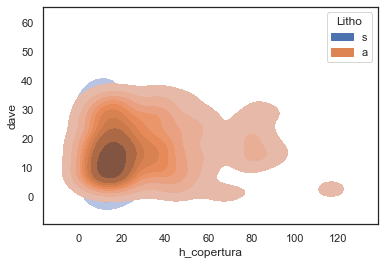

In [1099]:
sns.kdeplot(
    data=df0[df0.type == 'Inbuto'], x="h_copertura", y="dave", hue="Litho", fill=True,
)

In [1402]:
df0

Unnamed: 0.1   ref  n_occ          long           lat    type    type2  \
2                2     3     13  430516.76165  6.150605e+06  Inbuto  Ellisse   
3                3     4     14  430862.37713  6.150958e+06  Inbuto  Ellisse   
4                4     5     15  431581.18011  6.150717e+06  Inbuto  Ellisse   
10              10    11     21  430576.00991  6.152070e+06  Inbuto  Ellisse   
13              13    14     24  431082.66932  6.152832e+06  Inbuto  Ellisse   
...            ...   ...    ...           ...           ...     ...      ...   
1890          1890  1891   3034  432425.74914  6.151813e+06  Inbuto  Ellisse   
1891          1891  1892   3035  432439.88118  6.151870e+06  Inbuto  Ellisse   
1892          1892  1893   3036  432433.02460  6.151897e+06  Inbuto  Ellisse   
1893          1893  1894   3037  432978.80255  6.151652e+06  Inbuto  Ellisse   
1894          1894  1895   3038  434132.95933  6.151390e+06  Inbuto  Ellisse   

         type3  dmax  dmin  dave    h   h/d   area  volume      era  \
2     Piattino  23.9  15.2  19.6  0.0  0.00  285.2     0.0   Antica   
3        Tazza  19.8  17.4  18.6  0.0  0.00  270.4     0.0   Antica   
4        Tazza  26.5  21.7  24.1  0.0  0.00  451.4     0.0   Antica   
10    Piattino  34.6  21.4  28.0  0.0  0.00  581.2     0.0   Antica   
13    Piattino  32.5  25.0  28.8  0.0  0.00  637.8     0.0   Antica   
...        ...   ...   ...   ...  ...   ...    ...     ...      ...   
1890      Cono   3.0   3.0   3.0  3.0  1.00    7.1     8.5  Giovane   
1891     Tazza   2.0   2.0   2.0  1.0  0.50    3.1     1.6  Giovane   
1892  Piattino   3.0   3.0   3.0  0.2  0.07    7.1     0.7  Giovane   
1893  Piattino   2.5   1.0   1.8  0.2  0.11    2.0     0.2  Giovane   
1894      Cono   3.0   3.0   3.0  1.5  0.50    7.1     4.2  Giovane   

                  fonte  sector2000_50  check_100  check_500  check_2000  \
2     Immagini spaziali            0.0      False      False        True   
3     Immagini spaziali            0.0      False      False        True   
4     Immagini spaziali            1.0      False      False        True   
10    Immagini spaziali            0.0      False       True        True   
13    Immagini spaziali            0.0      False      False        True   
...                 ...            ...        ...        ...         ...   
1890  Immagini spaziali            1.0      False       True        True   
1891  Immagini spaziali            1.0      False       True        True   
1892  Immagini spaziali            1.0      False       True        True   
1893  Immagini spaziali            2.0       True       True        True   
1894  Immagini spaziali            3.0       True       True        True   

      sector2000_50_str  h_perm     h_quat IGE IGE_sec  IGE_SEC_PERC  \
2                   0.0     0.0  27.184916  3a       3          0.04   
3                   0.0     0.0  23.735288  3a       3          0.40   
4                   1.0     0.0  10.963859  3a       3          0.40   
10                  0.0     0.0  26.580044  3a       3          0.04   
13                  0.0     0.0  16.338371  3a       3          0.40   
...                 ...     ...        ...  ..     ...           ...   
1890                1.0     0.0  15.290921  3a       3          0.40   
1891                1.0     0.0  15.604321  3a       3          0.40   
1892                1.0     0.0  15.549550  3a       3          0.40   
1893                2.0     0.0  10.720034  3a       3          0.40   
1894                3.0     0.0  10.213781   3      3a          0.30   

      progressiva                Tipo Tipo_plus  h_copertura  h_copertura_ril  \
2       45.754188            Rilevato  Rilevato    27.184916        27.184916   
3      333.235599            Rilevato  Rilevato    23.735288        23.735288   
4     1130.923933            Rilevato  Rilevato    10.963859        10.963859   
10      70.665210            Rilevato  Rilevato    26.580044        26.580044   
13     67

In [1400]:
df0.columns

Index(['Unnamed: 0.1', 'ref', 'n_occ', 'long', 'lat', 'type', 'type2', 'type3',
       'dmax', 'dmin', 'dave', 'h', 'h/d', 'area', 'volume', 'era', 'fonte',
       'sector2000_50', 'check_100', 'check_500', 'check_2000',
       'sector2000_50_str', 'h_perm', 'h_quat', 'IGE', 'IGE_sec',
       'IGE_SEC_PERC', 'progressiva', 'Tipo', 'Tipo_plus', 'h_copertura',
       'h_copertura_ril', 'h_copertura_tri', 'h_copertura_via', 'h_rilevato',
       'h_rilevato_true', 'h_trincea', 'h_viadotto', 'vol_dave', 'Litho',
       'dbase', 'd_sub', 'h_sub', 'step', 'report', 'vol_dbase'],
      dtype='object')

h_copertura  long        type Litho
sector2000_50                                     
0.0              21.194122    76  Subsidenza     s
1.0              11.246535    98  Subsidenza     s
2.0              12.621096    87  Subsidenza     s
3.0               9.993762   104  Subsidenza     s
4.0               8.977362   120  Subsidenza     a
...                    ...   ...         ...   ...
92.0             65.349368     1  Subsidenza     a
93.0             44.910860     4  Subsidenza     a
94.0             37.246241    32  Subsidenza     a
95.0             65.661598    14  Subsidenza     a
96.0             86.353540     9  Subsidenza     a

[65 rows x 4 columns]

(0, 160)

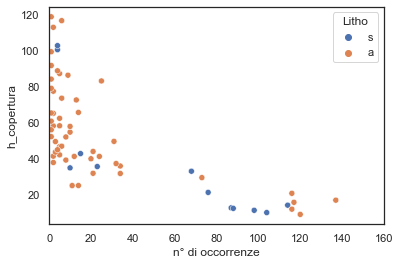

In [1416]:
sns.scatterplot(
    data=df0.groupby('sector2000_50').agg({'h_copertura':'mean', 'long':'count', 'type':'max', 'Litho':'max', 'dave':'mean'}), 
    x="long", y="h_copertura", hue='Litho', sizes='dave'
)
plt.xlabel('n° di occorrenze')
plt.xlim(0,160)


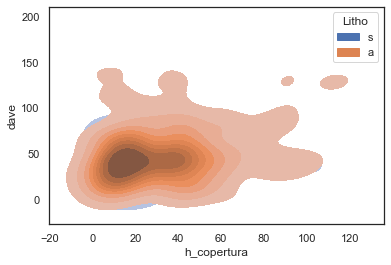

In [1100]:
sns.kdeplot(
    data=df0[df0.type == 'Subsidenza'], x="h_copertura", y="dave", hue="Litho", fill=True,
)

In [1365]:
numero_righe = 8
numero_colonne = 5


fig, axs = plt.subplots(numero_righe, numero_colonne, sharex=True, figsize=(18,24))

h=0

for i in range(numero_righe):
    for e in range(numero_colonne):

        histdata1 = df_zo_100[(df_zo_100.sector2000_50 == h) & (df_zo_100['check_100']==True)].groupby('epoch').sum().ril_klarge
        histdata2 = df_zo_100[(df_zo_100.sector2000_50 == h) & (df_zo_100['check_100']==True)].groupby('epoch').sum().tri_klarge
        histdata = histdata1.append(histdata2)

        sns.kdeplot(histdata, color='grey', fill=True, ax=axs[i, e])
        axs[i, e].set_title('Sector: '+ str(h))

        # Add labels
        axs[i, e].set_xlabel('Number of karst')
        axs[i, e].set_ylabel('Frequency')
        axs[i, e].set_xlim(0,5)
        axs[i, e].set_xticks([0,1,2,3,4,5])
        axs[i, e].set_yticks([])
        _ymin, _ymax = axs[i, e].get_ylim()
        axs[i, e].vlines(np.quantile(histdata,0.25), _ymin, _ymax, colors = 'orange', linestyles= 'dashed',  linewidth=1)
        axs[i, e].vlines(np.quantile(histdata,0.75), _ymin, _ymax, colors = 'orange', linestyles= 'dashed',  linewidth=1)
        axs[i, e].vlines(np.quantile(histdata,0.95), _ymin, _ymax, colors = 'orange', linestyles= 'dashed',  linewidth=1)
        axs[i, e].vlines(np.quantile(histdata,0.50), _ymin, _ymax, colors = 'red', linestyles= 'dashed',  linewidth=2)
        axs[i, e].text(.5,.9,'centered title',
                horizontalalignment='center',
                transform=ax.transAxes)
        h += 1

plt.savefig('kde_klarge.png')
plt.close()


In [1366]:
numero_righe = 8
numero_colonne = 5


fig, axs = plt.subplots(numero_righe, numero_colonne, sharex=True, figsize=(18,24))

h=0

for i in range(numero_righe):
    for e in range(numero_colonne):

        histdata1 = df_zo_100[(df_zo_100.sector2000_50 == h) & (df_zo_100['check_100']==True)].groupby('epoch').sum().ril_ksmall
        histdata2 = df_zo_100[(df_zo_100.sector2000_50 == h) & (df_zo_100['check_100']==True)].groupby('epoch').sum().tri_ksmall
        histdata = histdata1.append(histdata2)

        sns.kdeplot(histdata, color='grey', fill=True, ax=axs[i, e])
        axs[i, e].set_title('Sector: '+ str(h))

        # Add labels
        axs[i, e].set_xlabel('Number of karst')
        axs[i, e].set_ylabel('Frequency')
        axs[i, e].set_xlim(0,5)
        axs[i, e].set_xticks([0,1,2,3,4,5])
        axs[i, e].set_yticks([])
        _ymin, _ymax = axs[i, e].get_ylim()
        axs[i, e].vlines(np.quantile(histdata,0.25), _ymin, _ymax, colors = 'orange', linestyles= 'dashed',  linewidth=1)
        axs[i, e].vlines(np.quantile(histdata,0.75), _ymin, _ymax, colors = 'orange', linestyles= 'dashed',  linewidth=1)
        axs[i, e].vlines(np.quantile(histdata,0.95), _ymin, _ymax, colors = 'orange', linestyles= 'dashed',  linewidth=1)
        axs[i, e].vlines(np.quantile(histdata,0.50), _ymin, _ymax, colors = 'red', linestyles= 'dashed',  linewidth=2)
        h += 1

plt.savefig('kde_ksmall.png')
plt.close()


#### Viadotti

In [1418]:
numero_righe = 4
numero_colonne = 5


fig, axs = plt.subplots(numero_righe, numero_colonne, sharex=True, figsize=(18,12))

h = 0

for i in range(numero_righe):
    for e in range(numero_colonne):
        try:
            histdata1 = df_zo_100[(df_zo_100.sector2000_50 == h) & (df_zo_100['check_100']==True)].groupby('epoch').sum().via_klarge
            histdata2 = df_zo_100[(df_zo_100.sector2000_50 == h) & (df_zo_100['check_100']==True)].groupby('epoch').sum().via_ksmall
            histdata3 = df_zo_100[(df_zo_100.sector2000_50 == h) & (df_zo_100['check_100']==True)].groupby('epoch').sum().pas_klarge
            histdata4 = df_zo_100[(df_zo_100.sector2000_50 == h) & (df_zo_100['check_100']==True)].groupby('epoch').sum().pas_ksmall
            histdata = histdata1.append(histdata2).append(histdata3).append(histdata4)
            
            sns.histplot(histdata, element='step', stat='density', ax=axs[i, e], color='c')
            sns.kdeplot(histdata, color='grey', fill=True, ax=axs[i, e])
            axs[i, e].set_title('Sector: '+ str(h))

            # Add labels
            axs[i, e].set_xlabel('Number of karst')
            axs[i, e].set_ylabel('Frequency')
            axs[i, e].set_xlim(0,5)
            _ymin, _ymax = axs[i, e].get_ylim()
            axs[i, e].vlines(np.quantile(histdata,0.25), _ymin, _ymax, colors = 'lightgreen', linestyles= 'dashed',  linewidth=1)
            axs[i, e].vlines(np.quantile(histdata,0.75), _ymin, _ymax, colors = 'orange', linestyles= 'dashed',  linewidth=1)
            axs[i, e].vlines(np.quantile(histdata,0.95), _ymin, _ymax, colors = 'red', linestyles= 'dashed',  linewidth=1)
            axs[i, e].vlines(np.quantile(histdata,0.50), _ymin, _ymax, colors = 'k', linestyles= 'dashed',  linewidth=1)
            axs[i, e].text(.5,.9,'centered title',
                horizontalalignment='center',
                transform=axs[i, e].transAxes)
        except:
            pass
        h += 1

plt.savefig('kde_via_pas.png')
plt.close()

In [1421]:
numero_righe = 8
numero_colonne = 5


# fig, axs = plt.subplots(numero_righe, numero_colonne, sharex=True, sharey=True, figsize=(18,12))
fig, axs = plt.subplots(numero_righe, numero_colonne, figsize=(18,30))

h = 0
_xmax = 0.5
_nbins = 5
_ymax = 75

for i in range(numero_righe):
    for e in range(numero_colonne):
        try:
            histdata1 = df_zo[(df_zo.sector2000_50 == h)&(df_zo.dbase>0)].groupby('epoch').count().long
            histdata_det = df_g50[(df_g50.sector2000_50==h)].n_karst
            histdata =  (histdata1 + histdata_det.values[0])/ df_g50.sector_area.mean() /100
            
            sns.histplot(histdata, element='step', stat='density', ax=axs[i, e], color='c')
            sns.kdeplot(histdata, color='grey', fill=True, ax=axs[i, e])
            #axs[i, e].set_title('Sector: '+ str(h))

            # Add labels
            axs[i, e].set_xlabel('Number of karst')
            axs[i, e].set_ylabel('')
            #axs[i, e].set_xlim(0,_xmax)
            #axs[i, e].set_ylim(0,_ymax)
            _ymin, _ymax = axs[i, e].get_ylim()
            axs[i, e].vlines(np.quantile(histdata,0.25), _ymin, _ymax, colors = 'lightgreen', linestyles= 'dashed',  linewidth=1)
            axs[i, e].vlines(np.quantile(histdata,0.75), _ymin, _ymax, colors = 'orange', linestyles= 'dashed',  linewidth=1)
            axs[i, e].vlines(np.quantile(histdata,0.95), _ymin, _ymax, colors = 'red', linestyles= 'dashed',  linewidth=1)
            axs[i, e].vlines(np.quantile(histdata,0.50), _ymin, _ymax, colors = 'k', linestyles= 'dashed',  linewidth=1)
            axs[i, e].text(.5,.9,'Sector: '+ str(h),
                horizontalalignment='center',
                transform=axs[i, e].transAxes)
        except:
            pass
        h += 1
plt.locator_params(axis="x", nbins=_nbins)
plt.savefig('kde_all_2000.png')
plt.close()

In [1420]:
numero_righe = 8
numero_colonne = 5


# fig, axs = plt.subplots(numero_righe, numero_colonne, sharex=True, sharey=True, figsize=(18,12))
fig, axs = plt.subplots(numero_righe, numero_colonne, figsize=(18,30))

h = 0
_xmax = 5
_nbins = 5

for i in range(numero_righe):
    for e in range(numero_colonne):
        try:
            histdata1 = df_zo[(df_zo.sector2000_50 == h)&(df_zo.check_100 == True)&(df_zo.dbase>0)].groupby('epoch').count().long
            histdata_det = df_g50[(df_g50.sector2000_50==h)].n_karst
            histdata =  (histdata1 + histdata_det.values[0])
            
            sns.histplot(histdata, element='step', stat='density', ax=axs[i, e], color='c')
            sns.kdeplot(histdata, color='grey', fill=True, ax=axs[i, e])
            #axs[i, e].set_title('Sector: '+ str(h))

            # Add labels
            axs[i, e].set_xlabel('Number of karst')
            axs[i, e].set_ylabel('')
            #axs[i, e].set_xlim(0,_xmax)
            #axs[i, e].set_ylim(0,_ymax)
            _ymin, _ymax = axs[i, e].get_ylim()
            axs[i, e].vlines(np.quantile(histdata,0.25), _ymin, _ymax, colors = 'lightgreen', linestyles= 'dashed',  linewidth=1)
            axs[i, e].vlines(np.quantile(histdata,0.75), _ymin, _ymax, colors = 'orange', linestyles= 'dashed',  linewidth=1)
            axs[i, e].vlines(np.quantile(histdata,0.95), _ymin, _ymax, colors = 'red', linestyles= 'dashed',  linewidth=1)
            axs[i, e].vlines(np.quantile(histdata,0.50), _ymin, _ymax, colors = 'k', linestyles= 'dashed',  linewidth=1)
            axs[i, e].text(.5,.9,'Sector: '+ str(h),
                horizontalalignment='center',
                transform=axs[i, e].transAxes)
        except:
            pass
        h += 1
plt.locator_params(axis="x", nbins=_nbins)
plt.savefig('kde_all_100.png')
plt.close()

### PLOTTO CON PLOTLY

In [ ]:
df_zo.columns

#### Plot  epoch singolo --> per diametri a piano campagna, Pds > 0

In [1441]:
# import plotly.graph_objects as go

# tracciato principale
x = df.POINT_X
y = df.POINT_Y

df0.dropna(inplace = True)
sizeref = 2.*max(df0['dave'])/(300)
# f = px.scatter(df0, x='long', y='lat', color='sector2000_50_str', size='dave')
# # senza colori per settore
#f = px.scatter(df0, x='long', y='lat', size='dave', hover_data=['sector2000_50','dbase'])

sizeref = 2.*max(df_zo.dbase)/300
f = px.scatter(df_zo[(df_zo.Pds>=0.00) & (df_zo.epoch==3)], x='long', y='lat', size='dbase', color = 'dbase', hover_data=['sector2000_50','Pds'])


f.update_traces(marker=dict(
    sizemode='area', sizeref=sizeref, line_width=2))

# f.add_trace(go.Scatter(x=df0.long, y=df0.lat, mode='markers', marker_size=df0.dave, marker=dict(
#     sizemode='area', sizeref=sizeref, line_width=2)))

# senza spessore punti
# f.add_trace(go.Scatter(x=df_zo[(df_zo['dbase'] > 0) & (df_zo.Pds > 0.01)]['long'], y=df_zo[(
#     df_zo['dbase'] > 0) & (df_zo.Pds > 0.01)]['lat'], mode='markers', marker=dict(size=0.5,color=2)))

# con spessore punti
# f.add_trace(go.Scatter(x=df_zo[df_zo['dbase'] > 0]['long'], y=df_zo[df_zo['dbase'] > 0]['lat'], mode='markers', marker_size=sizeref*10))

f.add_trace(go.Scatter(x=x, y=y))

f.add_trace(go.Scatter(x=vtrackup[:, 0], y=vtrackup[:, 1]))
f.add_trace(go.Scatter(x=vtrackdown[:, 0], y=vtrackdown[:, 1]))

f.add_trace(go.Scatter(x=vtrackup500[:, 0], y=vtrackup500[:, 1]))
f.add_trace(go.Scatter(x=vtrackdown500[:, 0], y=vtrackdown500[:, 1]))

f.add_trace(go.Scatter(x=vtrackup2000[:, 0], y=vtrackup2000[:, 1]))
f.add_trace(go.Scatter(x=vtrackdown2000[:, 0], y=vtrackdown2000[:, 1]))




f.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
)


f.update_layout(
    autosize=False,
    width=1100,
    height=800,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0,
        pad=4
    ), legend = dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)

f.show()

#### Plotto intere simulazioni solo subsidenze

In [ ]:
# import plotly.graph_objects as go

# tracciato principale
x = df.POINT_X
y = df.POINT_Y

df0.dropna(inplace = True)
sizeref = 2.*max(df0['dave'])/(300)
# f = px.scatter(df0, x='long', y='lat', color='sector2000_50_str', size='dave')
# # senza colori per settore
#f = px.scatter(df0, x='long', y='lat', size='dave', hover_data=['sector2000_50','dbase'])

sizeref = 2.*max(df_zo.dbase)/300
f = px.scatter(df_zo[(df_zo.Pds>=0.01) & (df_zo.Pds< 0.1)], x='long', y='lat', size='dbase', color = 'dbase', hover_data=['sector2000_50','Pds'])


f.update_traces(marker=dict(
    sizemode='area', sizeref=sizeref, line_width=2))

# f.add_trace(go.Scatter(x=df0.long, y=df0.lat, mode='markers', marker_size=df0.dave, marker=dict(
#     sizemode='area', sizeref=sizeref, line_width=2)))

# senza spessore punti
# f.add_trace(go.Scatter(x=df_zo[(df_zo['dbase'] > 0) & (df_zo.Pds > 0.01)]['long'], y=df_zo[(
#     df_zo['dbase'] > 0) & (df_zo.Pds > 0.01)]['lat'], mode='markers', marker=dict(size=0.5,color=2)))

# con spessore punti
# f.add_trace(go.Scatter(x=df_zo[df_zo['dbase'] > 0]['long'], y=df_zo[df_zo['dbase'] > 0]['lat'], mode='markers', marker_size=sizeref*10))

f.add_trace(go.Scatter(x=x, y=y))

f.add_trace(go.Scatter(x=vtrackup[:, 0], y=vtrackup[:, 1]))
f.add_trace(go.Scatter(x=vtrackdown[:, 0], y=vtrackdown[:, 1]))

f.add_trace(go.Scatter(x=vtrackup500[:, 0], y=vtrackup500[:, 1]))
f.add_trace(go.Scatter(x=vtrackdown500[:, 0], y=vtrackdown500[:, 1]))

f.add_trace(go.Scatter(x=vtrackup2000[:, 0], y=vtrackup2000[:, 1]))
f.add_trace(go.Scatter(x=vtrackdown2000[:, 0], y=vtrackdown2000[:, 1]))




f.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
)


f.update_layout(
    autosize=False,
    width=1100,
    height=800,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0,
        pad=4
    ), legend = dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)

f.show()

#### Plotto intere simulazioni doline + subsidenze - colore Pds 

In [ ]:
# import plotly.graph_objects as go

# tracciato principale
x = df.POINT_X
y = df.POINT_Y

df0.dropna(inplace = True)
sizeref = 2.*max(df0['dave'])/(300)
# f = px.scatter(df0, x='long', y='lat', color='sector2000_50_str', size='dave')
# # senza colori per settore
#f = px.scatter(df0, x='long', y='lat', size='dave', hover_data=['sector2000_50','dbase'])


# #  tutte le simulazioni solo doline
# sizeref = 2.*max(df_zo.dbase)/300
# f = px.scatter(df_zo[(df_zo.Pds>=0.1)], x='long', y='lat', size='dbase', color = 'dbase', hover_data=['sector2000_50','Pds'])

# #  tutte le simulazioni solo subsidenze
# sizeref = 2.*max(df_zo.dbase)/300
# f = px.scatter(df_zo[(df_zo.Pds>=0.01) & df_zo[(df_zo.Pds<0.1)], x='long', y='lat', size='dbase', color = 'dbase', hover_data=['sector2000_50','Pds'])

#  una simulazione Pds >= 0.01
sizeref = 2.*max(df_zo.dbase)/500
f = px.scatter(df_zo[(df_zo.Pds>=0.01) & ((df_zo.epoch==10) | (df_zo.epoch==20))], x='long', y='lat', size='dbase', color = 'Pds', hover_data=['sector2000_50','Pds'])


f.update_traces(marker=dict(
    sizemode='area', sizeref=sizeref, line_width=2))

# f.add_trace(go.Scatter(x=df0.long, y=df0.lat, mode='markers', marker_size=df0.dave, marker=dict(
#     sizemode='area', sizeref=sizeref, line_width=2)))

# senza spessore punti
# f.add_trace(go.Scatter(x=df_zo[(df_zo['dbase'] > 0) & (df_zo.Pds > 0.01)]['long'], y=df_zo[(
#     df_zo['dbase'] > 0) & (df_zo.Pds > 0.01)]['lat'], mode='markers', marker=dict(size=0.5,color=2)))

# con spessore punti
# f.add_trace(go.Scatter(x=df_zo[df_zo['dbase'] > 0]['long'], y=df_zo[df_zo['dbase'] > 0]['lat'], mode='markers', marker_size=sizeref*10))

f.add_trace(go.Scatter(x=x, y=y))

f.add_trace(go.Scatter(x=vtrackup[:, 0], y=vtrackup[:, 1]))
f.add_trace(go.Scatter(x=vtrackdown[:, 0], y=vtrackdown[:, 1]))

f.add_trace(go.Scatter(x=vtrackup500[:, 0], y=vtrackup500[:, 1]))
f.add_trace(go.Scatter(x=vtrackdown500[:, 0], y=vtrackdown500[:, 1]))

f.add_trace(go.Scatter(x=vtrackup2000[:, 0], y=vtrackup2000[:, 1]))
f.add_trace(go.Scatter(x=vtrackdown2000[:, 0], y=vtrackdown2000[:, 1]))




f.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
)


f.update_layout(
    autosize=False,
    width=1100,
    height=800,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0,
        pad=4
    ), legend = dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)

f.show()

In [ ]:
# import plotly.graph_objects as go

# tracciato principale
x = df.POINT_X
y = df.POINT_Y

df0.dropna(inplace = True)
sizeref = 2.*max(df0['dave'])/(300)
# f = px.scatter(df0, x='long', y='lat', color='sector2000_50_str', size='dave')
# # senza colori per settore
#f = px.scatter(df0, x='long', y='lat', size='dave', hover_data=['sector2000_50','dbase'])

sizeref = 2.*max(df_zo.dbase)/300
f = px.scatter(df_zo_100[df_zo_100.epoch<10], x='long', y='lat', size='dbase', hover_data=['sector2000_50','Pds'])


f.update_traces(marker=dict(
    sizemode='area', sizeref=sizeref, line_width=2))

# f.add_trace(go.Scatter(x=df0.long, y=df0.lat, mode='markers', marker_size=df0.dave, marker=dict(
#     sizemode='area', sizeref=sizeref, line_width=2)))

# senza spessore punti
f.add_trace(go.Scatter(x=df_zo_100[(df_zo_100['dbase'] > 0) & (df_zo_100.Pds > 0)&(df_zo_100.epoch<10)]['long'], y=df_zo_100[(
    df_zo_100['dbase'] > 0) & (df_zo_100.Pds > 0)&(df_zo_100.epoch<10)]['lat'], mode='markers', marker=dict(size=8,color=2)))

# con spessore punti
# f.add_trace(go.Scatter(x=df_zo[df_zo['dbase'] > 0]['long'], y=df_zo[df_zo['dbase'] > 0]['lat'], mode='markers', marker_size=sizeref*10))

f.add_trace(go.Scatter(x=x, y=y))

f.add_trace(go.Scatter(x=vtrackup[:, 0], y=vtrackup[:, 1]))
f.add_trace(go.Scatter(x=vtrackdown[:, 0], y=vtrackdown[:, 1]))

f.add_trace(go.Scatter(x=vtrackup500[:, 0], y=vtrackup500[:, 1]))
f.add_trace(go.Scatter(x=vtrackdown500[:, 0], y=vtrackdown500[:, 1]))

f.add_trace(go.Scatter(x=vtrackup2000[:, 0], y=vtrackup2000[:, 1]))
f.add_trace(go.Scatter(x=vtrackdown2000[:, 0], y=vtrackdown2000[:, 1]))




f.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
)


f.update_layout(
    autosize=False,
    width=1100,
    height=600,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0,
        pad=4
    ), legend = dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)

f.show()

In [ ]:
df_g50.columns

## CREO KARST STOCHASTICI

### creo colonne dei boundary 100m 200m e 2000m

###  CONVERSIONE IN COORDINATE UTM

In [ ]:
from pyproj import Proj

In [ ]:
x = tuple(df.POINT_X)
y = tuple(df.POINT_Y)

In [ ]:
myProj = Proj("+proj=utm +zone=38N, +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

In [ ]:
lon, lat = myProj(x, y, inverse=True)

In [ ]:


fig = px.scatter_mapbox(lat=lat, lon=lon, zoom=8, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
fig = px.scatter_mapbox(lat=lat, lon=lon, zoom=7, height=300)
fig.update_layout(
    mapbox_style="white-bg",
    mapbox_layers=[
        {
            "below": 'traces',
            "sourcetype": "raster",
            "sourceattribution": "United States Geological Survey",
            "source": [
                "https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"
            ]
        }
      ])
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()